## Exoplanet Model Work



#### Import packages

In [144]:
import pydot
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import io
from keras.utils import plot_model
import random
import yaml
#import ktrain
from astropy.io import ascii as ap_ascii
import seaborn as sns
import os
import IPython
import time

import matplotlib as mpl
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import kerastuner as kt

pd.set_option('display.float_format', lambda x: '%.5f' % x)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.set_printoptions(precision=None, suppress=True)

from helpers.visualize import chart_curves 
from definitions import PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG
#PROCESSED_DATA_DIR='processed_data'
TCE_LIST='tce_table.csv'
FAILED_LIST='failed_kepids.csv'
MODEL_DIR='models'

BATCH_SIZE=96
METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')
    ]

#### Model analysis plotting and charting functions

In [162]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        plt.legend()
    plt.show()


#roc curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

#confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print('Not Planets Properly Categorized (True Negatives): ', cm[0][0])
    print('Not Planets Categorized as Planets Detected (False Positives): ', cm[0][1])
    print('Planets Missed (False Negatives): ', cm[1][0])
    print('Planets Properly Categorized (True Positives): ', cm[1][1])
    print('Total Planets: ', np.sum(cm[1]))
    print('Accuracy: ',(cm[0][0]+cm[1][1])/len(predictions))
    
#takes in the tce index number, the tce id table, the results table (which figures out tp etc),
#and the two vector tables and then calls the visualization helper function which
#creates a chart and saves inside of processed_data folder structure
def chart(tce_number,tce_id,results,x_global,x_local):
    kepid=tce_id.loc[tce_number].kepid
    result=val_results.loc[tce_number].result
    tce_plnt_num=tce_id.loc[tce_number].tce_plnt_num
    chart_curves(str(kepid),tce_plnt_num,
             result,
             x_global_val[tce_number],x_local_val[tce_number])

def model_results(model):
    val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
    train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)
    plot_cm(Y_val, val_predictions_baseline,p=.6)
    plot_cm(Y_val, val_predictions_baseline)
    plot_cm(Y_val, val_predictions_baseline,p=.4)
    plot_metrics(history)

    plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
    plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')

In [172]:
def load_model(model_name):
    model = tf.keras.models.load_model(os.path.join(MODEL_DIR,model_name))
    return model

def save_model(model_name):
    model.save(os.path.join(MODEL_DIR,model_name))
    
def model_picture(model,model_name):
    tf.keras.utils.plot_model(
        model, to_file=os.path.join(MODEL_DIR,model_name+'.png'), show_shapes=True, show_layer_names=True,
        rankdir='TB', expand_nested=True, dpi=96
    )


In [ ]:
#takes in model and creates full prediction file etc
def create_prediction_output(model,name):
    full_predictions = model.predict([x_local,x_global])
        
    print('Predictions shape from w2p model:',full_predictions.shape)
    print('Original Y shape:',Y.shape)
    plot_cm(Y, full_predictions)

    #this builds a temp df with just the processed tces and w2p result
    temp_df=pd.DataFrame()
    temp_df['kepid']=processed.kepid
    temp_df['tce_plnt_num']=processed.tce_plnt_num
    temp_df['w2p_score']=full_predictions
    
    #this merges into full file (including the ~500 that did not have processed light curves)
    #and then for those that the model did not run on, puts w2p prob at 0
    processed_final=original.merge(temp_df,how='outer',left_on=['kepid','tce_plnt_num'],right_on=['kepid','tce_plnt_num'])
    processed_final.w2p_score = processed_final.w2p_score.fillna(0)
    
    
    processed_final['w2p_disposition']='FALSE POSITIVE'
    processed_final.loc[processed_final.w2p_score>=0.5,['w2p_disposition']]='CONFIRMED'
    processed_final.replace({'koi_disposition':
                       {'1-CONFIRMED':'CONFIRMED','0-FALSE POSITIVE':'FALSE POSITIVE'}},
                      inplace=True)
    
    print('processed_final shape:',processed_final.shape)
    #key columns to compare
    #koi_disposition
    #https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
    #https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html (has AV descriptions)
    #koi_pdisposition and koi_score are ROBOVETTER outcomes (where available)
    print('w2p_disposition:',processed_final.w2p_disposition.value_counts())
    print('koi disposition:',processed_final.koi_disposition.value_counts())
    print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())
    print('koi pdisposition:',processed_final.koi_pdisposition.value_counts())

    #av_pp_pc is posterior probability score from autovetter model (where available).  
    #Have divided by 100 to make comparable to koi_score
    #and created a column representing AV disposition / unclear how differs from av_pred_class
    processed_final.av_vf_pc=processed_final.av_vf_pc/100
    processed_final['av_disposition']='FALSE POSITIVE'
    processed_final.loc[processed_final.av_vf_pc>.5,['av_disposition']]='CONFIRMED'
    print('AV disposition:',processed_final.av_disposition.value_counts())

    #replacing koi_score with zero where NAN.  Only 8000 of TCEs had koi_score and koi_pdisposition (ie robovetter)
    #same with av_vf_pc
    processed_final.koi_score.fillna(0,inplace=True)
    processed_final.av_vf_pc.fillna(0,inplace=True)

    #koi_score is RV monte carlo prob.  koi_pdisposition is some subjective measure beyond RV score
    processed_final[(processed_final.koi_score>=0.5)&(processed_final.koi_pdisposition=='FALSE POSITIVE')][[
        'kepid','tce_plnt_num','koi_disposition','koi_score','koi_pdisposition','w2p_score','w2p_disposition','av_disposition','av_vf_pc']]

    print(processed_final[[
        'kepid','tce_plnt_num','koi_disposition',
        'w2p_score','w2p_disposition',
        'koi_score','koi_pdisposition',
        'av_disposition','av_vf_pc']])

    print('Accuracy after adding back non-processed kepids:',sum(processed_final.koi_disposition==processed_final.w2p_disposition)/processed_final.shape[0])
    processed_final.to_csv(os.path.join(PROCESSED_DATA_DIR,name+'_final.csv'),index=False)
    return processed_final

#### Read in and process data for use in model

(438, 2)
Shape of processed file: (33594, 86)
Original TCE list: FALSE POSITIVE    29835
CONFIRMED          2345
CANDIDATE          1852
Name: koi_disposition, dtype: int64
Processed TCE list: FALSE POSITIVE    29397
CONFIRMED          2345
CANDIDATE          1852
Name: koi_disposition, dtype: int64
0-FALSE POSITIVE    29397
1-CONFIRMED          4197
Name: koi_disposition, dtype: int64
Baseline accuracy: 0.8750669762457581
(33594, 201)
(33594, 2001)
(33594, 201)
(33594, 2001)


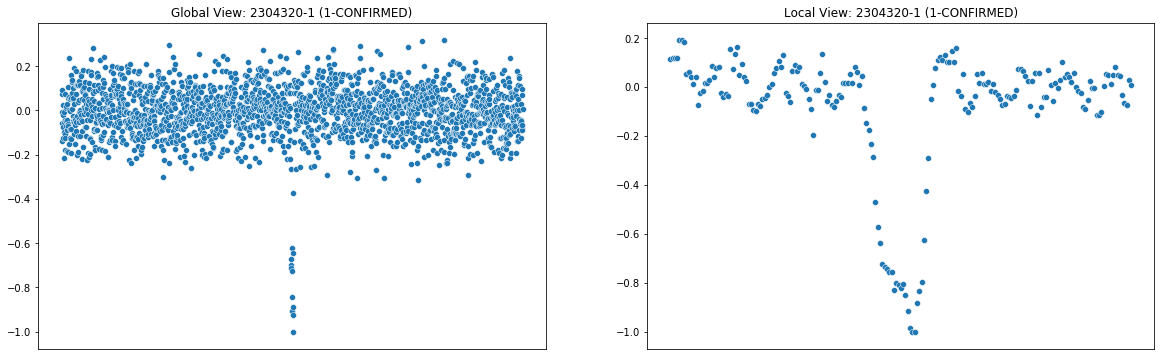

(33594, 201, 1)
(33594, 2001, 1)
(26875, 201, 1)
(26875, 2001, 1)
(26875,)
(26875, 3)
(6719, 201, 1)
(6719, 2001, 1)
(6719,)
(6719, 3)


In [202]:
def get_data():
    #this excludes from tce_list those kepids and planet numbers that failed make_data process
    original=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,TCE_LIST))
    processed=original.copy()
    try:
        failed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,FAILED_LIST))
        failed.columns=['kepid','tce_plnt_num']
        print(failed.shape)
        for index,row in failed.iterrows():
            processed.drop(processed[(processed.kepid==row.kepid) & 
                                     (processed.tce_plnt_num==row.tce_plnt_num)].index,inplace=True)
    except:
        pass

    processed=processed.reset_index(drop=True)
    print('Shape of processed file:',processed.shape)

    #all of the failed KEPIDs from preprocessing pipeline are FALSE POSITIVES

    #save processed list back out (so excludes those KEPIDS/PLNTs with NO light curves)
    processed.to_csv(os.path.join(PROCESSED_DATA_DIR,PROCESSED_DATA_CATALOG),index=False)
    
    
    print('Original TCE list:',original.koi_disposition.value_counts())
    print('Processed TCE list:',processed.koi_disposition.value_counts())

    #combine confirmed and candidate
    #using 0 and 1 in front of name to force positive class to be planets
    processed.replace({'koi_disposition':
                       {'CANDIDATE':'1-CONFIRMED','CONFIRMED':'1-CONFIRMED','FALSE POSITIVE':'0-FALSE POSITIVE'}},
                      inplace=True)
    original.replace({'koi_disposition':
                       {'CANDIDATE':'1-CONFIRMED','CONFIRMED':'1-CONFIRMED','FALSE POSITIVE':'0-FALSE POSITIVE'}},
                      inplace=True)

    print(processed.koi_disposition.value_counts())
    print('Baseline accuracy:', processed[processed.koi_disposition=='0-FALSE POSITIVE'].shape[0]/processed.shape[0])

    
    LOCAL='localbinned_df.csv'
    GLOBAL='globalbinned_df.csv'
    x_local=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,LOCAL))
    x_global=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,GLOBAL))
    print(x_local.shape)
    print(x_global.shape)
    
    
    #add kepid and tce_plnt_number to x
    tce_id=pd.DataFrame()
    tce_id['kepid']=processed.kepid.astype('int')
    tce_id['tce_plnt_num']=processed.tce_plnt_num.astype('int')
    tce_id['koi_disposition']=processed.koi_disposition
    
    #turn into numpy arrays/series
    x_local=x_local.to_numpy()
    x_global=x_global.to_numpy()
    print(x_local.shape)
    print(x_global.shape)
    
    #can print out charts
    tce_number=3
    chart_curves(tce_id.kepid[tce_number],
                 tce_id.tce_plnt_num[tce_number],
                 x_global[tce_number],
                 x_local[tce_number],
                 tce_id.koi_disposition[tce_number])
    #Conv1D layers take in tensors of dimension (length of vector = 201 or 2001, and dimensions of vector=1)
    #So as with Conv2D in BW where need to add a color dimension here have to specify that there is only one
    #dimension in each vector
    x_local=np.expand_dims(x_local,axis=2)
    x_global=np.expand_dims(x_global,axis=2)

    print(x_local.shape)
    print(x_global.shape)
    
    #turn output into categorical variable with encoding
    Y=processed.koi_disposition
    le=LabelEncoder()
    le.fit(['1-CONFIRMED','0-FALSE POSITIVE'])
    Y=le.transform(Y)
    
    x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val,tce_id_train,tce_id_val = train_test_split(
    x_local,x_global, Y,tce_id, test_size=0.2)


    return (x_local, x_local_train, x_local_val, 
            x_global, x_global_train, x_global_val, 
            Y, Y_train, Y_val,
            tce_id_train,tce_id_val,
            processed,original)


x_local, x_local_train, x_local_val, x_global, x_global_train, x_global_val, Y, Y_train, Y_val,tce_id_train,tce_id_val,processed,original=get_data()   
print(x_local_train.shape)
print(x_global_train.shape)
print(Y_train.shape)
print(tce_id_train.shape)
print(x_local_val.shape)
print(x_global_val.shape)
print(Y_val.shape)
print(tce_id_val.shape)
    
    

### CNN model configured for keras-tuner hyper parameter optimization

In [36]:
#revised for keras-tuner
#model making that allows keras-tuner hyperparameter optimization to be run

def make_cnn_model(hp):
    #model = Sequential()   
    
    
    input_local = tf.keras.layers.Input(shape=[x_local_train.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global_train.shape[1],1])
    
    first_global_cnn_filters=hp.Int('first_global_cnn_filters',min_value=8,max_value=32,step=8)
    further_global_cnn_filters=hp.Int('further_global_cnn_filters',min_value=16,max_value=128, step=16)
    #can not have kernel greater than maxpool size?
    cnn_global_kernel=hp.Int('cnn_global_kernel',min_value=3,max_value=5,step=2)
    cnn_global_maxpool=hp.Int('cnn_global_maxpool',min_value=3,max_value=7,step=2)
    cnn_global_stride=hp.Int('cnn_global_stride',min_value=1,max_value=3,step=1)
    
    first_local_cnn_filters=hp.Int('first_local_cnn_filters',min_value=8,max_value=32,step=8)
    further_local_cnn_filters=hp.Int('further_local_cnn_filters',min_value=16,max_value=128, step=16)
    cnn_local_kernel=hp.Int('cnn_local_kernel',min_value=3,max_value=5,step=2)
    cnn_local_maxpool=hp.Int('cnn_local_maxpool',min_value=3,max_value=7,step=2)
    cnn_local_stride=hp.Int('cnn_local_stride',min_value=1,max_value=3,step=1)   
    
    cnn_activation=hp.Choice('cnn_activation',values=['relu'])#,'PReLU()'])
    
    
    #first global cnn
    k_global=tf.keras.layers.Conv1D(filters=first_global_cnn_filters,
                                    kernel_size=cnn_global_kernel,
                                    activation=cnn_activation)(input_global)
    
    k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_maxpool,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    #first local cnn
    k_local=tf.keras.layers.Conv1D(filters=first_local_cnn_filters,
                                    kernel_size=cnn_local_kernel,
                                    activation=cnn_activation)(input_local)
    
    k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_maxpool,
                                              strides=cnn_local_stride,padding='same')(k_local)
    
    
    
    further_global_cnn_layers=hp.Int('further_global_cnn_layers',min_value=1,max_value=3,step=1)
    further_local_cnn_layers=hp.Int('further_global_cnn_layers',min_value=1,max_value=3,step=1)
    
    for i in range(further_global_cnn_layers):
        k_global=tf.keras.layers.Conv1D(filters=further_global_cnn_filters,
                                    kernel_size=cnn_global_kernel,
                                    activation=cnn_activation)(k_global)
        k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_maxpool,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    for i in range(further_local_cnn_layers):
        k_local=tf.keras.layers.Conv1D(filters=further_local_cnn_filters,
                                    kernel_size=cnn_local_kernel,
                                    activation=cnn_activation)(k_local)
        k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_maxpool,
                                              strides=cnn_local_stride,padding='same')(k_local)
        
    #flatten and concatenate
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    
    number_of_dense_layers=hp.Int('number_of_dense_layers',min_value=2,max_value=5,step=1)
    size_of_dense_layers=hp.Int('size_of_dense_layers',min_value=64, max_value=512, step=64)
    dense_activation=hp.Choice('dense_activation',values=['relu'])#,'PReLU()'])
    dense_dropout=hp.Choice('dense_dropout',values=[0.0,.2,.5])
    
    #now add dense layers
    for i in range(number_of_dense_layers):
        k=tf.keras.layers.Dense(size_of_dense_layers,activation=dense_activation)(k)
        k=tf.keras.layers.Dropout(dense_dropout)(k)
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    learning_rate=hp.Choice('learning_rate',values=[1e-4,1e-5,1e-6])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=METRICS)
    return model

#### set up to run keras-tuner

In [43]:

OPTIMIZATION_DIRECTORY='w2p_optimization'


class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

#tuner=kt.BayesianOptimization(
tuner=MyTuner(
    make_cnn_model,
    kt.Objective("val_accuracy",direction="max"),
    max_trials=100,
    executions_per_trial=1,
    project_name=OPTIMIZATION_DIRECTORY
    )


#class ClearTrainingOutput(tf.keras.callbacks.Callback):
#  def on_train_end(*args, **kwargs):
#    IPython.display.clear_output(wait = True)
    
#tf.keras.backend.clear_session()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

NUMBER_OF_EPOCHS=30

INFO:tensorflow:Reloading Oracle from existing project ./w2p_optimization/oracle.json
INFO:tensorflow:Reloading Tuner from ./w2p_optimization/tuner0.json


#### now running tuner - this takes a long time
Note directory removal if model structure has changed

In [17]:
#this is what takes a long time - does hyper paramater search

#have to remove parameter search history if make_model function has been changed in some way
dirpath=os.path.join(OPTIMIZATION_DIRECTORY)
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

#when change model structure, have to remove optimization directory to stop it from
#trying to continue on from old tuning session

start_time=time.time()
print ('Start',start_time)

tuner.search([x_local_train,x_global_train],
             Y_train,
             epochs = NUMBER_OF_EPOCHS, 
             validation_data=([x_local_val,x_global_val],Y_val),
             callbacks = [early_stopping],
             verbose=2)

end_time=time.time()

print('Start',start_time)
print ('End',end_time)
print('Duration (hours)',(end_time-start_time)/3600)

Start 1605873326.444573
Epoch 1/10
840/840 - 21s - loss: 0.3710 - tp: 13.0000 - fp: 116.0000 - tn: 23382.0000 - fn: 3364.0000 - accuracy: 0.8705 - precision: 0.1008 - recall: 0.0038 - auc: 0.6924 - val_loss: 0.3291 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7772
Epoch 2/10
840/840 - 19s - loss: 0.3066 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23498.0000 - fn: 3377.0000 - accuracy: 0.8743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8288 - val_loss: 0.2755 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8919
Epoch 3/10
840/840 - 22s - loss: 0.2532 - tp: 381.0000 - fp: 52.0000 - tn: 23446.0000 - fn: 2996.0000 - accuracy: 0.8866 - precision: 0.8799 - recall: 0.1128 - auc: 0.9162 - val_loss: 0.2308 - val_tp: 208.0000 - val_fp: 45.0000 - v

Epoch 1/10
840/840 - 9s - loss: 0.1873 - tp: 2552.0000 - fp: 739.0000 - tn: 28658.0000 - fn: 1645.0000 - accuracy: 0.9290 - precision: 0.7754 - recall: 0.6081 - auc: 0.9443 - val_loss: 0.1348 - val_tp: 674.0000 - val_fp: 199.0000 - val_tn: 5700.0000 - val_fn: 146.0000 - val_accuracy: 0.9487 - val_precision: 0.7721 - val_recall: 0.8220 - val_auc: 0.9663
Epoch 2/10
840/840 - 9s - loss: 0.1287 - tp: 2648.0000 - fp: 481.0000 - tn: 23017.0000 - fn: 729.0000 - accuracy: 0.9550 - precision: 0.8463 - recall: 0.7841 - auc: 0.9682 - val_loss: 0.1249 - val_tp: 696.0000 - val_fp: 178.0000 - val_tn: 5721.0000 - val_fn: 124.0000 - val_accuracy: 0.9551 - val_precision: 0.7963 - val_recall: 0.8488 - val_auc: 0.9699
Epoch 3/10
840/840 - 9s - loss: 0.1120 - tp: 2761.0000 - fp: 408.0000 - tn: 23090.0000 - fn: 616.0000 - accuracy: 0.9619 - precision: 0.8713 - recall: 0.8176 - auc: 0.9744 - val_loss: 0.1198 - val_tp: 700.0000 - val_fp: 154.0000 - val_tn: 5745.0000 - val_fn: 120.0000 - val_accuracy: 0.9592 

Epoch 1/10
105/105 - 8s - loss: 0.6819 - tp: 1721.0000 - fp: 7547.0000 - tn: 21850.0000 - fn: 2476.0000 - accuracy: 0.7016 - precision: 0.1857 - recall: 0.4101 - auc: 0.6697 - val_loss: 0.6788 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7829
Epoch 2/10
105/105 - 7s - loss: 0.6671 - tp: 950.0000 - fp: 6438.0000 - tn: 17060.0000 - fn: 2427.0000 - accuracy: 0.6701 - precision: 0.1286 - recall: 0.2813 - auc: 0.5558 - val_loss: 0.6605 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8045
Epoch 3/10
105/105 - 7s - loss: 0.6487 - tp: 820.0000 - fp: 5851.0000 - tn: 17647.0000 - fn: 2557.0000 - accuracy: 0.6871 - precision: 0.1229 - recall: 0.2428 - auc: 0.5584 - val_loss: 0.6404 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 8

Epoch 1/10
105/105 - 3s - loss: 0.2534 - tp: 876.0000 - fp: 297.0000 - tn: 29100.0000 - fn: 3321.0000 - accuracy: 0.8923 - precision: 0.7468 - recall: 0.2087 - auc: 0.8100 - val_loss: 0.1848 - val_tp: 661.0000 - val_fp: 317.0000 - val_tn: 5582.0000 - val_fn: 159.0000 - val_accuracy: 0.9292 - val_precision: 0.6759 - val_recall: 0.8061 - val_auc: 0.9541
Epoch 2/10
105/105 - 2s - loss: 0.1566 - tp: 2435.0000 - fp: 633.0000 - tn: 22865.0000 - fn: 942.0000 - accuracy: 0.9414 - precision: 0.7937 - recall: 0.7211 - auc: 0.9610 - val_loss: 0.1401 - val_tp: 590.0000 - val_fp: 111.0000 - val_tn: 5788.0000 - val_fn: 230.0000 - val_accuracy: 0.9492 - val_precision: 0.8417 - val_recall: 0.7195 - val_auc: 0.9645
Epoch 3/10
105/105 - 2s - loss: 0.1346 - tp: 2618.0000 - fp: 495.0000 - tn: 23003.0000 - fn: 759.0000 - accuracy: 0.9533 - precision: 0.8410 - recall: 0.7752 - auc: 0.9674 - val_loss: 0.1301 - val_tp: 676.0000 - val_fp: 169.0000 - val_tn: 5730.0000 - val_fn: 144.0000 - val_accuracy: 0.9534 -

Epoch 1/10
105/105 - 4s - loss: 0.2692 - tp: 1245.0000 - fp: 362.0000 - tn: 29035.0000 - fn: 2952.0000 - accuracy: 0.9014 - precision: 0.7747 - recall: 0.2966 - auc: 0.8997 - val_loss: 0.1774 - val_tp: 564.0000 - val_fp: 214.0000 - val_tn: 5685.0000 - val_fn: 256.0000 - val_accuracy: 0.9300 - val_precision: 0.7249 - val_recall: 0.6878 - val_auc: 0.9482
Epoch 2/10
105/105 - 4s - loss: 0.1806 - tp: 2258.0000 - fp: 781.0000 - tn: 22717.0000 - fn: 1119.0000 - accuracy: 0.9293 - precision: 0.7430 - recall: 0.6686 - auc: 0.9487 - val_loss: 0.1637 - val_tp: 556.0000 - val_fp: 177.0000 - val_tn: 5722.0000 - val_fn: 264.0000 - val_accuracy: 0.9344 - val_precision: 0.7585 - val_recall: 0.6780 - val_auc: 0.9547
Epoch 3/10
105/105 - 4s - loss: 0.1641 - tp: 2444.0000 - fp: 745.0000 - tn: 22753.0000 - fn: 933.0000 - accuracy: 0.9376 - precision: 0.7664 - recall: 0.7237 - auc: 0.9557 - val_loss: 0.1515 - val_tp: 581.0000 - val_fp: 171.0000 - val_tn: 5728.0000 - val_fn: 239.0000 - val_accuracy: 0.9390

Epoch 1/10
840/840 - 10s - loss: 0.2228 - tp: 2031.0000 - fp: 497.0000 - tn: 28900.0000 - fn: 2166.0000 - accuracy: 0.9207 - precision: 0.8034 - recall: 0.4839 - auc: 0.9360 - val_loss: 0.1736 - val_tp: 618.0000 - val_fp: 173.0000 - val_tn: 5726.0000 - val_fn: 202.0000 - val_accuracy: 0.9442 - val_precision: 0.7813 - val_recall: 0.7537 - val_auc: 0.9573
Epoch 2/10
840/840 - 10s - loss: 0.1528 - tp: 2648.0000 - fp: 563.0000 - tn: 22935.0000 - fn: 729.0000 - accuracy: 0.9519 - precision: 0.8247 - recall: 0.7841 - auc: 0.9619 - val_loss: 0.1295 - val_tp: 633.0000 - val_fp: 117.0000 - val_tn: 5782.0000 - val_fn: 187.0000 - val_accuracy: 0.9548 - val_precision: 0.8440 - val_recall: 0.7720 - val_auc: 0.9679
Epoch 3/10
840/840 - 10s - loss: 0.1228 - tp: 2733.0000 - fp: 388.0000 - tn: 23110.0000 - fn: 644.0000 - accuracy: 0.9616 - precision: 0.8757 - recall: 0.8093 - auc: 0.9722 - val_loss: 0.1252 - val_tp: 701.0000 - val_fp: 155.0000 - val_tn: 5744.0000 - val_fn: 119.0000 - val_accuracy: 0.95

Epoch 1/10
840/840 - 10s - loss: 0.1832 - tp: 2748.0000 - fp: 765.0000 - tn: 28632.0000 - fn: 1449.0000 - accuracy: 0.9341 - precision: 0.7822 - recall: 0.6548 - auc: 0.9482 - val_loss: 0.1444 - val_tp: 589.0000 - val_fp: 150.0000 - val_tn: 5749.0000 - val_fn: 231.0000 - val_accuracy: 0.9433 - val_precision: 0.7970 - val_recall: 0.7183 - val_auc: 0.9613
Epoch 2/10
840/840 - 9s - loss: 0.1312 - tp: 2719.0000 - fp: 591.0000 - tn: 22907.0000 - fn: 658.0000 - accuracy: 0.9535 - precision: 0.8215 - recall: 0.8052 - auc: 0.9673 - val_loss: 0.1253 - val_tp: 678.0000 - val_fp: 157.0000 - val_tn: 5742.0000 - val_fn: 142.0000 - val_accuracy: 0.9555 - val_precision: 0.8120 - val_recall: 0.8268 - val_auc: 0.9675
Epoch 3/10
840/840 - 9s - loss: 0.1064 - tp: 2829.0000 - fp: 446.0000 - tn: 23052.0000 - fn: 548.0000 - accuracy: 0.9630 - precision: 0.8638 - recall: 0.8377 - auc: 0.9763 - val_loss: 0.1231 - val_tp: 715.0000 - val_fp: 190.0000 - val_tn: 5709.0000 - val_fn: 105.0000 - val_accuracy: 0.9561

Epoch 1/10
840/840 - 14s - loss: 0.1569 - tp: 2992.0000 - fp: 671.0000 - tn: 28726.0000 - fn: 1205.0000 - accuracy: 0.9442 - precision: 0.8168 - recall: 0.7129 - auc: 0.9574 - val_loss: 0.1260 - val_tp: 638.0000 - val_fp: 96.0000 - val_tn: 5803.0000 - val_fn: 182.0000 - val_accuracy: 0.9586 - val_precision: 0.8692 - val_recall: 0.7780 - val_auc: 0.9686
Epoch 2/10
840/840 - 13s - loss: 0.1183 - tp: 2730.0000 - fp: 461.0000 - tn: 23037.0000 - fn: 647.0000 - accuracy: 0.9588 - precision: 0.8555 - recall: 0.8084 - auc: 0.9724 - val_loss: 0.1191 - val_tp: 669.0000 - val_fp: 122.0000 - val_tn: 5777.0000 - val_fn: 151.0000 - val_accuracy: 0.9594 - val_precision: 0.8458 - val_recall: 0.8159 - val_auc: 0.9712
Epoch 3/10
840/840 - 12s - loss: 0.1034 - tp: 2822.0000 - fp: 407.0000 - tn: 23091.0000 - fn: 555.0000 - accuracy: 0.9642 - precision: 0.8740 - recall: 0.8357 - auc: 0.9781 - val_loss: 0.1270 - val_tp: 603.0000 - val_fp: 83.0000 - val_tn: 5816.0000 - val_fn: 217.0000 - val_accuracy: 0.9554

Epoch 1/10
840/840 - 5s - loss: 0.2947 - tp: 680.0000 - fp: 242.0000 - tn: 29155.0000 - fn: 3517.0000 - accuracy: 0.8881 - precision: 0.7375 - recall: 0.1620 - auc: 0.8730 - val_loss: 0.1979 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9462
Epoch 2/10
840/840 - 5s - loss: 0.2018 - tp: 1424.0000 - fp: 367.0000 - tn: 23131.0000 - fn: 1953.0000 - accuracy: 0.9137 - precision: 0.7951 - recall: 0.4217 - auc: 0.9435 - val_loss: 0.1698 - val_tp: 538.0000 - val_fp: 138.0000 - val_tn: 5761.0000 - val_fn: 282.0000 - val_accuracy: 0.9375 - val_precision: 0.7959 - val_recall: 0.6561 - val_auc: 0.9592
Epoch 3/10
840/840 - 5s - loss: 0.1810 - tp: 2250.0000 - fp: 564.0000 - tn: 22934.0000 - fn: 1127.0000 - accuracy: 0.9371 - precision: 0.7996 - recall: 0.6663 - auc: 0.9519 - val_loss: 0.1563 - val_tp: 616.0000 - val_fp: 153.0000 - val_tn: 5746.0000 - val_fn: 204.0000 - val_accu

Epoch 1/10
840/840 - 9s - loss: 0.2072 - tp: 2605.0000 - fp: 811.0000 - tn: 28586.0000 - fn: 1592.0000 - accuracy: 0.9285 - precision: 0.7626 - recall: 0.6207 - auc: 0.9361 - val_loss: 0.1690 - val_tp: 669.0000 - val_fp: 294.0000 - val_tn: 5605.0000 - val_fn: 151.0000 - val_accuracy: 0.9338 - val_precision: 0.6947 - val_recall: 0.8159 - val_auc: 0.9550
Epoch 2/10
840/840 - 9s - loss: 0.1491 - tp: 2621.0000 - fp: 708.0000 - tn: 22790.0000 - fn: 756.0000 - accuracy: 0.9455 - precision: 0.7873 - recall: 0.7761 - auc: 0.9615 - val_loss: 0.1507 - val_tp: 619.0000 - val_fp: 161.0000 - val_tn: 5738.0000 - val_fn: 201.0000 - val_accuracy: 0.9461 - val_precision: 0.7936 - val_recall: 0.7549 - val_auc: 0.9608
Epoch 3/10
840/840 - 8s - loss: 0.1248 - tp: 2718.0000 - fp: 540.0000 - tn: 22958.0000 - fn: 659.0000 - accuracy: 0.9554 - precision: 0.8343 - recall: 0.8049 - auc: 0.9714 - val_loss: 0.1314 - val_tp: 650.0000 - val_fp: 156.0000 - val_tn: 5743.0000 - val_fn: 170.0000 - val_accuracy: 0.9515 

Epoch 1/10
840/840 - 6s - loss: 0.1959 - tp: 2529.0000 - fp: 741.0000 - tn: 28656.0000 - fn: 1668.0000 - accuracy: 0.9283 - precision: 0.7734 - recall: 0.6026 - auc: 0.9402 - val_loss: 0.1546 - val_tp: 616.0000 - val_fp: 195.0000 - val_tn: 5704.0000 - val_fn: 204.0000 - val_accuracy: 0.9406 - val_precision: 0.7596 - val_recall: 0.7512 - val_auc: 0.9582
Epoch 2/10
840/840 - 5s - loss: 0.1419 - tp: 2573.0000 - fp: 626.0000 - tn: 22872.0000 - fn: 804.0000 - accuracy: 0.9468 - precision: 0.8043 - recall: 0.7619 - auc: 0.9646 - val_loss: 0.1378 - val_tp: 689.0000 - val_fp: 214.0000 - val_tn: 5685.0000 - val_fn: 131.0000 - val_accuracy: 0.9487 - val_precision: 0.7630 - val_recall: 0.8402 - val_auc: 0.9658
Epoch 3/10
840/840 - 5s - loss: 0.1230 - tp: 2712.0000 - fp: 528.0000 - tn: 22970.0000 - fn: 665.0000 - accuracy: 0.9556 - precision: 0.8370 - recall: 0.8031 - auc: 0.9712 - val_loss: 0.1270 - val_tp: 644.0000 - val_fp: 141.0000 - val_tn: 5758.0000 - val_fn: 176.0000 - val_accuracy: 0.9528 

Epoch 1/10
840/840 - 6s - loss: 0.1871 - tp: 2597.0000 - fp: 656.0000 - tn: 28741.0000 - fn: 1600.0000 - accuracy: 0.9328 - precision: 0.7983 - recall: 0.6188 - auc: 0.9456 - val_loss: 0.1481 - val_tp: 653.0000 - val_fp: 221.0000 - val_tn: 5678.0000 - val_fn: 167.0000 - val_accuracy: 0.9423 - val_precision: 0.7471 - val_recall: 0.7963 - val_auc: 0.9611
Epoch 2/10
840/840 - 5s - loss: 0.1306 - tp: 2690.0000 - fp: 557.0000 - tn: 22941.0000 - fn: 687.0000 - accuracy: 0.9537 - precision: 0.8285 - recall: 0.7966 - auc: 0.9676 - val_loss: 0.1219 - val_tp: 678.0000 - val_fp: 158.0000 - val_tn: 5741.0000 - val_fn: 142.0000 - val_accuracy: 0.9554 - val_precision: 0.8110 - val_recall: 0.8268 - val_auc: 0.9691
Epoch 3/10
840/840 - 5s - loss: 0.1148 - tp: 2776.0000 - fp: 488.0000 - tn: 23010.0000 - fn: 601.0000 - accuracy: 0.9595 - precision: 0.8505 - recall: 0.8220 - auc: 0.9735 - val_loss: 0.1188 - val_tp: 665.0000 - val_fp: 126.0000 - val_tn: 5773.0000 - val_fn: 155.0000 - val_accuracy: 0.9582 

Epoch 1/10
840/840 - 9s - loss: 0.3751 - tp: 683.0000 - fp: 277.0000 - tn: 29120.0000 - fn: 3514.0000 - accuracy: 0.8872 - precision: 0.7115 - recall: 0.1627 - auc: 0.7725 - val_loss: 0.3226 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7955
Epoch 2/10
840/840 - 8s - loss: 0.3186 - tp: 1.0000 - fp: 3.0000 - tn: 23495.0000 - fn: 3376.0000 - accuracy: 0.8743 - precision: 0.2500 - recall: 2.9612e-04 - auc: 0.8010 - val_loss: 0.2814 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8700
Epoch 3/10
840/840 - 9s - loss: 0.2817 - tp: 77.0000 - fp: 37.0000 - tn: 23461.0000 - fn: 3300.0000 - accuracy: 0.8758 - precision: 0.6754 - recall: 0.0228 - auc: 0.8664 - val_loss: 0.2477 - val_tp: 47.0000 - val_fp: 17.0000 - val_tn: 5882.0000 - val_fn: 773.0000 - va

Epoch 1/10
105/105 - 5s - loss: 0.2688 - tp: 1291.0000 - fp: 389.0000 - tn: 29008.0000 - fn: 2906.0000 - accuracy: 0.9019 - precision: 0.7685 - recall: 0.3076 - auc: 0.8892 - val_loss: 0.1622 - val_tp: 529.0000 - val_fp: 127.0000 - val_tn: 5772.0000 - val_fn: 291.0000 - val_accuracy: 0.9378 - val_precision: 0.8064 - val_recall: 0.6451 - val_auc: 0.9567
Epoch 2/10
105/105 - 4s - loss: 0.1511 - tp: 2588.0000 - fp: 615.0000 - tn: 22883.0000 - fn: 789.0000 - accuracy: 0.9478 - precision: 0.8080 - recall: 0.7664 - auc: 0.9612 - val_loss: 0.1295 - val_tp: 656.0000 - val_fp: 159.0000 - val_tn: 5740.0000 - val_fn: 164.0000 - val_accuracy: 0.9519 - val_precision: 0.8049 - val_recall: 0.8000 - val_auc: 0.9658
Epoch 3/10
105/105 - 4s - loss: 0.1239 - tp: 2726.0000 - fp: 489.0000 - tn: 23009.0000 - fn: 651.0000 - accuracy: 0.9576 - precision: 0.8479 - recall: 0.8072 - auc: 0.9690 - val_loss: 0.1139 - val_tp: 647.0000 - val_fp: 101.0000 - val_tn: 5798.0000 - val_fn: 173.0000 - val_accuracy: 0.9592 

Epoch 1/10
168/168 - 13s - loss: 0.2403 - tp: 1991.0000 - fp: 619.0000 - tn: 28778.0000 - fn: 2206.0000 - accuracy: 0.9159 - precision: 0.7628 - recall: 0.4744 - auc: 0.9181 - val_loss: 0.1569 - val_tp: 629.0000 - val_fp: 213.0000 - val_tn: 5686.0000 - val_fn: 191.0000 - val_accuracy: 0.9399 - val_precision: 0.7470 - val_recall: 0.7671 - val_auc: 0.9570
Epoch 2/10
168/168 - 15s - loss: 0.1472 - tp: 2600.0000 - fp: 703.0000 - tn: 22795.0000 - fn: 777.0000 - accuracy: 0.9449 - precision: 0.7872 - recall: 0.7699 - auc: 0.9614 - val_loss: 0.1459 - val_tp: 557.0000 - val_fp: 117.0000 - val_tn: 5782.0000 - val_fn: 263.0000 - val_accuracy: 0.9434 - val_precision: 0.8264 - val_recall: 0.6793 - val_auc: 0.9630
Epoch 3/10
168/168 - 15s - loss: 0.1248 - tp: 2750.0000 - fp: 579.0000 - tn: 22919.0000 - fn: 627.0000 - accuracy: 0.9551 - precision: 0.8261 - recall: 0.8143 - auc: 0.9706 - val_loss: 0.1321 - val_tp: 696.0000 - val_fp: 207.0000 - val_tn: 5692.0000 - val_fn: 124.0000 - val_accuracy: 0.95

Epoch 1/10
120/120 - 21s - loss: 0.2247 - tp: 2158.0000 - fp: 783.0000 - tn: 28614.0000 - fn: 2039.0000 - accuracy: 0.9160 - precision: 0.7338 - recall: 0.5142 - auc: 0.9205 - val_loss: 0.1601 - val_tp: 569.0000 - val_fp: 182.0000 - val_tn: 5717.0000 - val_fn: 251.0000 - val_accuracy: 0.9356 - val_precision: 0.7577 - val_recall: 0.6939 - val_auc: 0.9542
Epoch 2/10
120/120 - 24s - loss: 0.1545 - tp: 2512.0000 - fp: 720.0000 - tn: 22778.0000 - fn: 865.0000 - accuracy: 0.9410 - precision: 0.7772 - recall: 0.7439 - auc: 0.9590 - val_loss: 0.1544 - val_tp: 565.0000 - val_fp: 139.0000 - val_tn: 5760.0000 - val_fn: 255.0000 - val_accuracy: 0.9414 - val_precision: 0.8026 - val_recall: 0.6890 - val_auc: 0.9575
Epoch 3/10
120/120 - 25s - loss: 0.1394 - tp: 2643.0000 - fp: 671.0000 - tn: 22827.0000 - fn: 734.0000 - accuracy: 0.9477 - precision: 0.7975 - recall: 0.7826 - auc: 0.9658 - val_loss: 0.1440 - val_tp: 616.0000 - val_fp: 154.0000 - val_tn: 5745.0000 - val_fn: 204.0000 - val_accuracy: 0.94

Epoch 1/10
105/105 - 3s - loss: 0.3698 - tp: 733.0000 - fp: 483.0000 - tn: 28914.0000 - fn: 3464.0000 - accuracy: 0.8825 - precision: 0.6028 - recall: 0.1746 - auc: 0.7817 - val_loss: 0.2295 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9321
Epoch 2/10
105/105 - 2s - loss: 0.2181 - tp: 3.0000 - fp: 1.0000 - tn: 23497.0000 - fn: 3374.0000 - accuracy: 0.8744 - precision: 0.7500 - recall: 8.8836e-04 - auc: 0.9351 - val_loss: 0.1860 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9519
Epoch 3/10
105/105 - 2s - loss: 0.1925 - tp: 1534.0000 - fp: 364.0000 - tn: 23134.0000 - fn: 1843.0000 - accuracy: 0.9179 - precision: 0.8082 - recall: 0.4542 - auc: 0.9506 - val_loss: 0.1782 - val_tp: 509.0000 - val_fp: 144.0000 - val_tn: 5755.0000 - val_fn: 311.0000

Epoch 1/10
840/840 - 6s - loss: 0.1825 - tp: 2732.0000 - fp: 671.0000 - tn: 28726.0000 - fn: 1465.0000 - accuracy: 0.9364 - precision: 0.8028 - recall: 0.6509 - auc: 0.9511 - val_loss: 0.1392 - val_tp: 702.0000 - val_fp: 209.0000 - val_tn: 5690.0000 - val_fn: 118.0000 - val_accuracy: 0.9513 - val_precision: 0.7706 - val_recall: 0.8561 - val_auc: 0.9666
Epoch 2/10
840/840 - 5s - loss: 0.1264 - tp: 2711.0000 - fp: 529.0000 - tn: 22969.0000 - fn: 666.0000 - accuracy: 0.9555 - precision: 0.8367 - recall: 0.8028 - auc: 0.9698 - val_loss: 0.1292 - val_tp: 577.0000 - val_fp: 76.0000 - val_tn: 5823.0000 - val_fn: 243.0000 - val_accuracy: 0.9525 - val_precision: 0.8836 - val_recall: 0.7037 - val_auc: 0.9699
Epoch 3/10
840/840 - 5s - loss: 0.1132 - tp: 2797.0000 - fp: 472.0000 - tn: 23026.0000 - fn: 580.0000 - accuracy: 0.9609 - precision: 0.8556 - recall: 0.8282 - auc: 0.9739 - val_loss: 0.1218 - val_tp: 614.0000 - val_fp: 90.0000 - val_tn: 5809.0000 - val_fn: 206.0000 - val_accuracy: 0.9559 - 

Epoch 1/10
140/140 - 10s - loss: 0.2625 - tp: 1449.0000 - fp: 536.0000 - tn: 28861.0000 - fn: 2748.0000 - accuracy: 0.9022 - precision: 0.7300 - recall: 0.3452 - auc: 0.9054 - val_loss: 0.1725 - val_tp: 510.0000 - val_fp: 160.0000 - val_tn: 5739.0000 - val_fn: 310.0000 - val_accuracy: 0.9300 - val_precision: 0.7612 - val_recall: 0.6220 - val_auc: 0.9516
Epoch 2/10
140/140 - 9s - loss: 0.1627 - tp: 2367.0000 - fp: 659.0000 - tn: 22839.0000 - fn: 1010.0000 - accuracy: 0.9379 - precision: 0.7822 - recall: 0.7009 - auc: 0.9566 - val_loss: 0.1567 - val_tp: 608.0000 - val_fp: 200.0000 - val_tn: 5699.0000 - val_fn: 212.0000 - val_accuracy: 0.9387 - val_precision: 0.7525 - val_recall: 0.7415 - val_auc: 0.9574
Epoch 3/10
140/140 - 9s - loss: 0.1483 - tp: 2511.0000 - fp: 628.0000 - tn: 22870.0000 - fn: 866.0000 - accuracy: 0.9444 - precision: 0.7999 - recall: 0.7436 - auc: 0.9633 - val_loss: 0.1583 - val_tp: 683.0000 - val_fp: 245.0000 - val_tn: 5654.0000 - val_fn: 137.0000 - val_accuracy: 0.943

Epoch 1/10
105/105 - 4s - loss: 0.2489 - tp: 1612.0000 - fp: 663.0000 - tn: 28734.0000 - fn: 2585.0000 - accuracy: 0.9033 - precision: 0.7086 - recall: 0.3841 - auc: 0.9127 - val_loss: 0.1582 - val_tp: 593.0000 - val_fp: 170.0000 - val_tn: 5729.0000 - val_fn: 227.0000 - val_accuracy: 0.9409 - val_precision: 0.7772 - val_recall: 0.7232 - val_auc: 0.9611
Epoch 2/10
105/105 - 3s - loss: 0.1579 - tp: 2437.0000 - fp: 646.0000 - tn: 22852.0000 - fn: 940.0000 - accuracy: 0.9410 - precision: 0.7905 - recall: 0.7216 - auc: 0.9599 - val_loss: 0.1357 - val_tp: 599.0000 - val_fp: 102.0000 - val_tn: 5797.0000 - val_fn: 221.0000 - val_accuracy: 0.9519 - val_precision: 0.8545 - val_recall: 0.7305 - val_auc: 0.9666
Epoch 3/10
105/105 - 3s - loss: 0.1356 - tp: 2615.0000 - fp: 553.0000 - tn: 22945.0000 - fn: 762.0000 - accuracy: 0.9511 - precision: 0.8254 - recall: 0.7744 - auc: 0.9675 - val_loss: 0.1278 - val_tp: 638.0000 - val_fp: 128.0000 - val_tn: 5771.0000 - val_fn: 182.0000 - val_accuracy: 0.9539 

Epoch 1/10
840/840 - 9s - loss: 0.1801 - tp: 2918.0000 - fp: 856.0000 - tn: 28541.0000 - fn: 1279.0000 - accuracy: 0.9364 - precision: 0.7732 - recall: 0.6953 - auc: 0.9508 - val_loss: 0.1389 - val_tp: 693.0000 - val_fp: 208.0000 - val_tn: 5691.0000 - val_fn: 127.0000 - val_accuracy: 0.9501 - val_precision: 0.7691 - val_recall: 0.8451 - val_auc: 0.9653
Epoch 2/10
840/840 - 8s - loss: 0.1226 - tp: 2749.0000 - fp: 503.0000 - tn: 22995.0000 - fn: 628.0000 - accuracy: 0.9579 - precision: 0.8453 - recall: 0.8140 - auc: 0.9704 - val_loss: 0.1178 - val_tp: 665.0000 - val_fp: 114.0000 - val_tn: 5785.0000 - val_fn: 155.0000 - val_accuracy: 0.9600 - val_precision: 0.8537 - val_recall: 0.8110 - val_auc: 0.9699
Epoch 3/10
840/840 - 8s - loss: 0.1030 - tp: 2841.0000 - fp: 390.0000 - tn: 23108.0000 - fn: 536.0000 - accuracy: 0.9655 - precision: 0.8793 - recall: 0.8413 - auc: 0.9774 - val_loss: 0.1205 - val_tp: 658.0000 - val_fp: 121.0000 - val_tn: 5778.0000 - val_fn: 162.0000 - val_accuracy: 0.9579 

Epoch 1/10
840/840 - 11s - loss: 0.1991 - tp: 2648.0000 - fp: 759.0000 - tn: 28638.0000 - fn: 1549.0000 - accuracy: 0.9313 - precision: 0.7772 - recall: 0.6309 - auc: 0.9385 - val_loss: 0.1589 - val_tp: 547.0000 - val_fp: 139.0000 - val_tn: 5760.0000 - val_fn: 273.0000 - val_accuracy: 0.9387 - val_precision: 0.7974 - val_recall: 0.6671 - val_auc: 0.9559
Epoch 2/10
840/840 - 10s - loss: 0.1449 - tp: 2618.0000 - fp: 682.0000 - tn: 22816.0000 - fn: 759.0000 - accuracy: 0.9464 - precision: 0.7933 - recall: 0.7752 - auc: 0.9617 - val_loss: 0.1477 - val_tp: 645.0000 - val_fp: 220.0000 - val_tn: 5679.0000 - val_fn: 175.0000 - val_accuracy: 0.9412 - val_precision: 0.7457 - val_recall: 0.7866 - val_auc: 0.9618
Epoch 3/10
840/840 - 10s - loss: 0.1247 - tp: 2765.0000 - fp: 568.0000 - tn: 22930.0000 - fn: 612.0000 - accuracy: 0.9561 - precision: 0.8296 - recall: 0.8188 - auc: 0.9711 - val_loss: 0.1323 - val_tp: 673.0000 - val_fp: 174.0000 - val_tn: 5725.0000 - val_fn: 147.0000 - val_accuracy: 0.95

Epoch 1/10
840/840 - 8s - loss: 0.1854 - tp: 2743.0000 - fp: 796.0000 - tn: 28601.0000 - fn: 1454.0000 - accuracy: 0.9330 - precision: 0.7751 - recall: 0.6536 - auc: 0.9400 - val_loss: 0.1503 - val_tp: 702.0000 - val_fp: 254.0000 - val_tn: 5645.0000 - val_fn: 118.0000 - val_accuracy: 0.9446 - val_precision: 0.7343 - val_recall: 0.8561 - val_auc: 0.9660
Epoch 2/10
840/840 - 7s - loss: 0.1249 - tp: 2740.0000 - fp: 563.0000 - tn: 22935.0000 - fn: 637.0000 - accuracy: 0.9553 - precision: 0.8295 - recall: 0.8114 - auc: 0.9700 - val_loss: 0.1237 - val_tp: 708.0000 - val_fp: 176.0000 - val_tn: 5723.0000 - val_fn: 112.0000 - val_accuracy: 0.9571 - val_precision: 0.8009 - val_recall: 0.8634 - val_auc: 0.9686
Epoch 3/10
840/840 - 7s - loss: 0.1047 - tp: 2803.0000 - fp: 430.0000 - tn: 23068.0000 - fn: 574.0000 - accuracy: 0.9626 - precision: 0.8670 - recall: 0.8300 - auc: 0.9778 - val_loss: 0.1329 - val_tp: 577.0000 - val_fp: 86.0000 - val_tn: 5813.0000 - val_fn: 243.0000 - val_accuracy: 0.9510 -

Epoch 1/10
840/840 - 6s - loss: 0.2498 - tp: 1052.0000 - fp: 211.0000 - tn: 29186.0000 - fn: 3145.0000 - accuracy: 0.9001 - precision: 0.8329 - recall: 0.2507 - auc: 0.9164 - val_loss: 0.1850 - val_tp: 363.0000 - val_fp: 64.0000 - val_tn: 5835.0000 - val_fn: 457.0000 - val_accuracy: 0.9225 - val_precision: 0.8501 - val_recall: 0.4427 - val_auc: 0.9562
Epoch 2/10
840/840 - 5s - loss: 0.1819 - tp: 2179.0000 - fp: 526.0000 - tn: 22972.0000 - fn: 1198.0000 - accuracy: 0.9359 - precision: 0.8055 - recall: 0.6452 - auc: 0.9538 - val_loss: 0.1543 - val_tp: 559.0000 - val_fp: 115.0000 - val_tn: 5784.0000 - val_fn: 261.0000 - val_accuracy: 0.9440 - val_precision: 0.8294 - val_recall: 0.6817 - val_auc: 0.9643
Epoch 3/10
840/840 - 5s - loss: 0.1530 - tp: 2562.0000 - fp: 588.0000 - tn: 22910.0000 - fn: 815.0000 - accuracy: 0.9478 - precision: 0.8133 - recall: 0.7587 - auc: 0.9617 - val_loss: 0.1345 - val_tp: 595.0000 - val_fp: 100.0000 - val_tn: 5799.0000 - val_fn: 225.0000 - val_accuracy: 0.9516 

Epoch 1/10
105/105 - 5s - loss: 0.6778 - tp: 1137.0000 - fp: 3131.0000 - tn: 26266.0000 - fn: 3060.0000 - accuracy: 0.8157 - precision: 0.2664 - recall: 0.2709 - auc: 0.6954 - val_loss: 0.6573 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6977
Epoch 2/10
105/105 - 4s - loss: 0.6323 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23498.0000 - fn: 3377.0000 - accuracy: 0.8743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6586 - val_loss: 0.6011 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7118
Epoch 3/10
105/105 - 4s - loss: 0.5638 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23498.0000 - fn: 3377.0000 - accuracy: 0.8743 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6716 - val_loss: 0.5190 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn:

Epoch 1/10
840/840 - 6s - loss: 0.2035 - tp: 1522.0000 - fp: 442.0000 - tn: 28955.0000 - fn: 2675.0000 - accuracy: 0.9072 - precision: 0.7749 - recall: 0.3626 - auc: 0.8981 - val_loss: 0.1608 - val_tp: 683.0000 - val_fp: 247.0000 - val_tn: 5652.0000 - val_fn: 137.0000 - val_accuracy: 0.9428 - val_precision: 0.7344 - val_recall: 0.8329 - val_auc: 0.9600
Epoch 2/10
840/840 - 5s - loss: 0.1404 - tp: 2574.0000 - fp: 617.0000 - tn: 22881.0000 - fn: 803.0000 - accuracy: 0.9472 - precision: 0.8066 - recall: 0.7622 - auc: 0.9663 - val_loss: 0.1352 - val_tp: 654.0000 - val_fp: 163.0000 - val_tn: 5736.0000 - val_fn: 166.0000 - val_accuracy: 0.9510 - val_precision: 0.8005 - val_recall: 0.7976 - val_auc: 0.9669
Epoch 3/10
840/840 - 5s - loss: 0.1234 - tp: 2702.0000 - fp: 507.0000 - tn: 22991.0000 - fn: 675.0000 - accuracy: 0.9560 - precision: 0.8420 - recall: 0.8001 - auc: 0.9729 - val_loss: 0.1299 - val_tp: 650.0000 - val_fp: 155.0000 - val_tn: 5744.0000 - val_fn: 170.0000 - val_accuracy: 0.9516 

Epoch 1/10
840/840 - 6s - loss: 0.1821 - tp: 2674.0000 - fp: 670.0000 - tn: 28727.0000 - fn: 1523.0000 - accuracy: 0.9347 - precision: 0.7996 - recall: 0.6371 - auc: 0.9501 - val_loss: 0.1534 - val_tp: 697.0000 - val_fp: 256.0000 - val_tn: 5643.0000 - val_fn: 123.0000 - val_accuracy: 0.9436 - val_precision: 0.7314 - val_recall: 0.8500 - val_auc: 0.9637
Epoch 2/10
840/840 - 5s - loss: 0.1339 - tp: 2620.0000 - fp: 547.0000 - tn: 22951.0000 - fn: 757.0000 - accuracy: 0.9515 - precision: 0.8273 - recall: 0.7758 - auc: 0.9685 - val_loss: 0.1330 - val_tp: 611.0000 - val_fp: 129.0000 - val_tn: 5770.0000 - val_fn: 209.0000 - val_accuracy: 0.9497 - val_precision: 0.8257 - val_recall: 0.7451 - val_auc: 0.9661
Epoch 3/10
840/840 - 5s - loss: 0.1181 - tp: 2725.0000 - fp: 470.0000 - tn: 23028.0000 - fn: 652.0000 - accuracy: 0.9583 - precision: 0.8529 - recall: 0.8069 - auc: 0.9737 - val_loss: 0.1269 - val_tp: 644.0000 - val_fp: 126.0000 - val_tn: 5773.0000 - val_fn: 176.0000 - val_accuracy: 0.9551 

Epoch 1/10
420/420 - 6s - loss: 0.1761 - tp: 2750.0000 - fp: 691.0000 - tn: 28706.0000 - fn: 1447.0000 - accuracy: 0.9364 - precision: 0.7992 - recall: 0.6552 - auc: 0.9512 - val_loss: 0.1371 - val_tp: 596.0000 - val_fp: 132.0000 - val_tn: 5767.0000 - val_fn: 224.0000 - val_accuracy: 0.9470 - val_precision: 0.8187 - val_recall: 0.7268 - val_auc: 0.9653
Epoch 2/10
420/420 - 5s - loss: 0.1291 - tp: 2654.0000 - fp: 502.0000 - tn: 22996.0000 - fn: 723.0000 - accuracy: 0.9544 - precision: 0.8409 - recall: 0.7859 - auc: 0.9697 - val_loss: 0.1231 - val_tp: 638.0000 - val_fp: 106.0000 - val_tn: 5793.0000 - val_fn: 182.0000 - val_accuracy: 0.9571 - val_precision: 0.8575 - val_recall: 0.7780 - val_auc: 0.9696
Epoch 3/10
420/420 - 5s - loss: 0.1142 - tp: 2734.0000 - fp: 442.0000 - tn: 23056.0000 - fn: 643.0000 - accuracy: 0.9596 - precision: 0.8608 - recall: 0.8096 - auc: 0.9747 - val_loss: 0.1238 - val_tp: 687.0000 - val_fp: 152.0000 - val_tn: 5747.0000 - val_fn: 133.0000 - val_accuracy: 0.9576 

Epoch 1/10
280/280 - 4s - loss: 0.2483 - tp: 1168.0000 - fp: 273.0000 - tn: 29124.0000 - fn: 3029.0000 - accuracy: 0.9017 - precision: 0.8105 - recall: 0.2783 - auc: 0.9159 - val_loss: 0.1855 - val_tp: 382.0000 - val_fp: 87.0000 - val_tn: 5812.0000 - val_fn: 438.0000 - val_accuracy: 0.9219 - val_precision: 0.8145 - val_recall: 0.4659 - val_auc: 0.9520
Epoch 2/10
280/280 - 3s - loss: 0.1866 - tp: 1845.0000 - fp: 515.0000 - tn: 22983.0000 - fn: 1532.0000 - accuracy: 0.9238 - precision: 0.7818 - recall: 0.5463 - auc: 0.9496 - val_loss: 0.1661 - val_tp: 548.0000 - val_fp: 159.0000 - val_tn: 5740.0000 - val_fn: 272.0000 - val_accuracy: 0.9359 - val_precision: 0.7751 - val_recall: 0.6683 - val_auc: 0.9569
Epoch 3/10
280/280 - 3s - loss: 0.1687 - tp: 2357.0000 - fp: 625.0000 - tn: 22873.0000 - fn: 1020.0000 - accuracy: 0.9388 - precision: 0.7904 - recall: 0.6980 - auc: 0.9563 - val_loss: 0.1489 - val_tp: 636.0000 - val_fp: 177.0000 - val_tn: 5722.0000 - val_fn: 184.0000 - val_accuracy: 0.9463

Epoch 1/10
105/105 - 11s - loss: 0.2659 - tp: 1550.0000 - fp: 588.0000 - tn: 28809.0000 - fn: 2647.0000 - accuracy: 0.9037 - precision: 0.7250 - recall: 0.3693 - auc: 0.8986 - val_loss: 0.1792 - val_tp: 610.0000 - val_fp: 244.0000 - val_tn: 5655.0000 - val_fn: 210.0000 - val_accuracy: 0.9324 - val_precision: 0.7143 - val_recall: 0.7439 - val_auc: 0.9498
Epoch 2/10
105/105 - 10s - loss: 0.1657 - tp: 2387.0000 - fp: 754.0000 - tn: 22744.0000 - fn: 990.0000 - accuracy: 0.9351 - precision: 0.7599 - recall: 0.7068 - auc: 0.9535 - val_loss: 0.1605 - val_tp: 553.0000 - val_fp: 171.0000 - val_tn: 5728.0000 - val_fn: 267.0000 - val_accuracy: 0.9348 - val_precision: 0.7638 - val_recall: 0.6744 - val_auc: 0.9547
Epoch 3/10
105/105 - 10s - loss: 0.1476 - tp: 2562.0000 - fp: 710.0000 - tn: 22788.0000 - fn: 815.0000 - accuracy: 0.9433 - precision: 0.7830 - recall: 0.7587 - auc: 0.9630 - val_loss: 0.1536 - val_tp: 584.0000 - val_fp: 159.0000 - val_tn: 5740.0000 - val_fn: 236.0000 - val_accuracy: 0.94

Epoch 1/10
105/105 - 4s - loss: 0.3975 - tp: 708.0000 - fp: 437.0000 - tn: 28960.0000 - fn: 3489.0000 - accuracy: 0.8831 - precision: 0.6183 - recall: 0.1687 - auc: 0.7420 - val_loss: 0.2829 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8794
Epoch 2/10
105/105 - 3s - loss: 0.2671 - tp: 81.0000 - fp: 58.0000 - tn: 23440.0000 - fn: 3296.0000 - accuracy: 0.8752 - precision: 0.5827 - recall: 0.0240 - auc: 0.8828 - val_loss: 0.2039 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9448
Epoch 3/10
105/105 - 3s - loss: 0.2148 - tp: 486.0000 - fp: 148.0000 - tn: 23350.0000 - fn: 2891.0000 - accuracy: 0.8869 - precision: 0.7666 - recall: 0.1439 - auc: 0.9353 - val_loss: 0.1869 - val_tp: 425.0000 - val_fp: 125.0000 - val_tn: 5774.0000 - val_fn: 395.0000 - 

Epoch 1/10
840/840 - 5s - loss: 0.1947 - tp: 2375.0000 - fp: 604.0000 - tn: 28793.0000 - fn: 1822.0000 - accuracy: 0.9278 - precision: 0.7972 - recall: 0.5659 - auc: 0.9466 - val_loss: 0.1454 - val_tp: 563.0000 - val_fp: 136.0000 - val_tn: 5763.0000 - val_fn: 257.0000 - val_accuracy: 0.9415 - val_precision: 0.8054 - val_recall: 0.6866 - val_auc: 0.9622
Epoch 2/10
840/840 - 5s - loss: 0.1391 - tp: 2558.0000 - fp: 554.0000 - tn: 22944.0000 - fn: 819.0000 - accuracy: 0.9489 - precision: 0.8220 - recall: 0.7575 - auc: 0.9657 - val_loss: 0.1329 - val_tp: 622.0000 - val_fp: 134.0000 - val_tn: 5765.0000 - val_fn: 198.0000 - val_accuracy: 0.9506 - val_precision: 0.8228 - val_recall: 0.7585 - val_auc: 0.9660
Epoch 3/10
840/840 - 5s - loss: 0.1271 - tp: 2659.0000 - fp: 489.0000 - tn: 23009.0000 - fn: 718.0000 - accuracy: 0.9551 - precision: 0.8447 - recall: 0.7874 - auc: 0.9702 - val_loss: 0.1296 - val_tp: 634.0000 - val_fp: 133.0000 - val_tn: 5766.0000 - val_fn: 186.0000 - val_accuracy: 0.9525 

Epoch 1/10
840/840 - 9s - loss: 0.1868 - tp: 2779.0000 - fp: 853.0000 - tn: 28544.0000 - fn: 1418.0000 - accuracy: 0.9324 - precision: 0.7651 - recall: 0.6621 - auc: 0.9466 - val_loss: 0.1503 - val_tp: 598.0000 - val_fp: 190.0000 - val_tn: 5709.0000 - val_fn: 222.0000 - val_accuracy: 0.9387 - val_precision: 0.7589 - val_recall: 0.7293 - val_auc: 0.9591
Epoch 2/10
840/840 - 8s - loss: 0.1361 - tp: 2657.0000 - fp: 646.0000 - tn: 22852.0000 - fn: 720.0000 - accuracy: 0.9492 - precision: 0.8044 - recall: 0.7868 - auc: 0.9666 - val_loss: 0.1425 - val_tp: 713.0000 - val_fp: 229.0000 - val_tn: 5670.0000 - val_fn: 107.0000 - val_accuracy: 0.9500 - val_precision: 0.7569 - val_recall: 0.8695 - val_auc: 0.9654
Epoch 3/10
840/840 - 8s - loss: 0.1087 - tp: 2843.0000 - fp: 484.0000 - tn: 23014.0000 - fn: 534.0000 - accuracy: 0.9621 - precision: 0.8545 - recall: 0.8419 - auc: 0.9768 - val_loss: 0.1268 - val_tp: 655.0000 - val_fp: 137.0000 - val_tn: 5762.0000 - val_fn: 165.0000 - val_accuracy: 0.9551 

Epoch 1/10
105/105 - 3s - loss: 0.3431 - tp: 678.0000 - fp: 233.0000 - tn: 29164.0000 - fn: 3519.0000 - accuracy: 0.8883 - precision: 0.7442 - recall: 0.1615 - auc: 0.8112 - val_loss: 0.2600 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8886
Epoch 2/10
105/105 - 2s - loss: 0.2136 - tp: 1207.0000 - fp: 329.0000 - tn: 23169.0000 - fn: 2170.0000 - accuracy: 0.9070 - precision: 0.7858 - recall: 0.3574 - auc: 0.9338 - val_loss: 0.1719 - val_tp: 521.0000 - val_fp: 164.0000 - val_tn: 5735.0000 - val_fn: 299.0000 - val_accuracy: 0.9311 - val_precision: 0.7606 - val_recall: 0.6354 - val_auc: 0.9533
Epoch 3/10
105/105 - 2s - loss: 0.1639 - tp: 2318.0000 - fp: 605.0000 - tn: 22893.0000 - fn: 1059.0000 - accuracy: 0.9381 - precision: 0.7930 - recall: 0.6864 - auc: 0.9574 - val_loss: 0.1513 - val_tp: 625.0000 - val_fp: 170.0000 - val_tn: 5729.0000 - val_fn: 195.0000 - val_accu

Epoch 1/10
840/840 - 6s - loss: 0.2961 - tp: 686.0000 - fp: 286.0000 - tn: 29111.0000 - fn: 3511.0000 - accuracy: 0.8870 - precision: 0.7058 - recall: 0.1635 - auc: 0.8800 - val_loss: 0.2061 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9518
Epoch 2/10
840/840 - 5s - loss: 0.2128 - tp: 721.0000 - fp: 233.0000 - tn: 23265.0000 - fn: 2656.0000 - accuracy: 0.8925 - precision: 0.7558 - recall: 0.2135 - auc: 0.9406 - val_loss: 0.2006 - val_tp: 473.0000 - val_fp: 107.0000 - val_tn: 5792.0000 - val_fn: 347.0000 - val_accuracy: 0.9324 - val_precision: 0.8155 - val_recall: 0.5768 - val_auc: 0.9553
Epoch 3/10
840/840 - 5s - loss: 0.2023 - tp: 2219.0000 - fp: 622.0000 - tn: 22876.0000 - fn: 1158.0000 - accuracy: 0.9338 - precision: 0.7811 - recall: 0.6571 - auc: 0.9471 - val_loss: 0.1987 - val_tp: 598.0000 - val_fp: 185.0000 - val_tn: 5714.0000 - val_fn: 222.0000 - val_accur

Epoch 1/10
420/420 - 5s - loss: 0.2005 - tp: 2366.0000 - fp: 703.0000 - tn: 28694.0000 - fn: 1831.0000 - accuracy: 0.9246 - precision: 0.7709 - recall: 0.5637 - auc: 0.9405 - val_loss: 0.1480 - val_tp: 599.0000 - val_fp: 171.0000 - val_tn: 5728.0000 - val_fn: 221.0000 - val_accuracy: 0.9417 - val_precision: 0.7779 - val_recall: 0.7305 - val_auc: 0.9607
Epoch 2/10
420/420 - 4s - loss: 0.1368 - tp: 2619.0000 - fp: 592.0000 - tn: 22906.0000 - fn: 758.0000 - accuracy: 0.9498 - precision: 0.8156 - recall: 0.7755 - auc: 0.9677 - val_loss: 0.1348 - val_tp: 594.0000 - val_fp: 108.0000 - val_tn: 5791.0000 - val_fn: 226.0000 - val_accuracy: 0.9503 - val_precision: 0.8462 - val_recall: 0.7244 - val_auc: 0.9660
Epoch 3/10
420/420 - 4s - loss: 0.1172 - tp: 2734.0000 - fp: 477.0000 - tn: 23021.0000 - fn: 643.0000 - accuracy: 0.9583 - precision: 0.8514 - recall: 0.8096 - auc: 0.9740 - val_loss: 0.1274 - val_tp: 652.0000 - val_fp: 133.0000 - val_tn: 5766.0000 - val_fn: 168.0000 - val_accuracy: 0.9552 

Epoch 1/10
840/840 - 9s - loss: 0.1697 - tp: 2961.0000 - fp: 836.0000 - tn: 28561.0000 - fn: 1236.0000 - accuracy: 0.9383 - precision: 0.7798 - recall: 0.7055 - auc: 0.9516 - val_loss: 0.1327 - val_tp: 612.0000 - val_fp: 118.0000 - val_tn: 5781.0000 - val_fn: 208.0000 - val_accuracy: 0.9515 - val_precision: 0.8384 - val_recall: 0.7463 - val_auc: 0.9669
Epoch 2/10
840/840 - 9s - loss: 0.1266 - tp: 2677.0000 - fp: 529.0000 - tn: 22969.0000 - fn: 700.0000 - accuracy: 0.9543 - precision: 0.8350 - recall: 0.7927 - auc: 0.9686 - val_loss: 0.1245 - val_tp: 641.0000 - val_fp: 117.0000 - val_tn: 5782.0000 - val_fn: 179.0000 - val_accuracy: 0.9559 - val_precision: 0.8456 - val_recall: 0.7817 - val_auc: 0.9680
Epoch 3/10
840/840 - 9s - loss: 0.1081 - tp: 2786.0000 - fp: 440.0000 - tn: 23058.0000 - fn: 591.0000 - accuracy: 0.9616 - precision: 0.8636 - recall: 0.8250 - auc: 0.9771 - val_loss: 0.1235 - val_tp: 662.0000 - val_fp: 128.0000 - val_tn: 5771.0000 - val_fn: 158.0000 - val_accuracy: 0.9574 

Epoch 1/10
840/840 - 6s - loss: 0.2247 - tp: 2031.0000 - fp: 653.0000 - tn: 28744.0000 - fn: 2166.0000 - accuracy: 0.9161 - precision: 0.7567 - recall: 0.4839 - auc: 0.9280 - val_loss: 0.1541 - val_tp: 544.0000 - val_fp: 124.0000 - val_tn: 5775.0000 - val_fn: 276.0000 - val_accuracy: 0.9405 - val_precision: 0.8144 - val_recall: 0.6634 - val_auc: 0.9611
Epoch 2/10
840/840 - 5s - loss: 0.1458 - tp: 2565.0000 - fp: 594.0000 - tn: 22904.0000 - fn: 812.0000 - accuracy: 0.9477 - precision: 0.8120 - recall: 0.7595 - auc: 0.9636 - val_loss: 0.1292 - val_tp: 616.0000 - val_fp: 118.0000 - val_tn: 5781.0000 - val_fn: 204.0000 - val_accuracy: 0.9521 - val_precision: 0.8392 - val_recall: 0.7512 - val_auc: 0.9673
Epoch 3/10
840/840 - 5s - loss: 0.1301 - tp: 2663.0000 - fp: 506.0000 - tn: 22992.0000 - fn: 714.0000 - accuracy: 0.9546 - precision: 0.8403 - recall: 0.7886 - auc: 0.9684 - val_loss: 0.1234 - val_tp: 625.0000 - val_fp: 105.0000 - val_tn: 5794.0000 - val_fn: 195.0000 - val_accuracy: 0.9554 

Epoch 1/10
840/840 - 6s - loss: 0.2152 - tp: 1944.0000 - fp: 411.0000 - tn: 28986.0000 - fn: 2253.0000 - accuracy: 0.9207 - precision: 0.8255 - recall: 0.4632 - auc: 0.9375 - val_loss: 0.1437 - val_tp: 582.0000 - val_fp: 130.0000 - val_tn: 5769.0000 - val_fn: 238.0000 - val_accuracy: 0.9452 - val_precision: 0.8174 - val_recall: 0.7098 - val_auc: 0.9647
Epoch 2/10
840/840 - 5s - loss: 0.1412 - tp: 2544.0000 - fp: 528.0000 - tn: 22970.0000 - fn: 833.0000 - accuracy: 0.9494 - precision: 0.8281 - recall: 0.7533 - auc: 0.9650 - val_loss: 0.1319 - val_tp: 676.0000 - val_fp: 176.0000 - val_tn: 5723.0000 - val_fn: 144.0000 - val_accuracy: 0.9524 - val_precision: 0.7934 - val_recall: 0.8244 - val_auc: 0.9692
Epoch 3/10
840/840 - 5s - loss: 0.1286 - tp: 2632.0000 - fp: 493.0000 - tn: 23005.0000 - fn: 745.0000 - accuracy: 0.9539 - precision: 0.8422 - recall: 0.7794 - auc: 0.9697 - val_loss: 0.1318 - val_tp: 713.0000 - val_fp: 195.0000 - val_tn: 5704.0000 - val_fn: 107.0000 - val_accuracy: 0.9551 

Epoch 1/10
840/840 - 14s - loss: 0.1895 - tp: 2641.0000 - fp: 703.0000 - tn: 28694.0000 - fn: 1556.0000 - accuracy: 0.9328 - precision: 0.7898 - recall: 0.6293 - auc: 0.9464 - val_loss: 0.1560 - val_tp: 686.0000 - val_fp: 262.0000 - val_tn: 5637.0000 - val_fn: 134.0000 - val_accuracy: 0.9411 - val_precision: 0.7236 - val_recall: 0.8366 - val_auc: 0.9595
Epoch 2/10
840/840 - 13s - loss: 0.1375 - tp: 2701.0000 - fp: 667.0000 - tn: 22831.0000 - fn: 676.0000 - accuracy: 0.9500 - precision: 0.8020 - recall: 0.7998 - auc: 0.9658 - val_loss: 0.1309 - val_tp: 654.0000 - val_fp: 157.0000 - val_tn: 5742.0000 - val_fn: 166.0000 - val_accuracy: 0.9519 - val_precision: 0.8064 - val_recall: 0.7976 - val_auc: 0.9666
Epoch 3/10
840/840 - 13s - loss: 0.1154 - tp: 2818.0000 - fp: 503.0000 - tn: 22995.0000 - fn: 559.0000 - accuracy: 0.9605 - precision: 0.8485 - recall: 0.8345 - auc: 0.9742 - val_loss: 0.1266 - val_tp: 634.0000 - val_fp: 118.0000 - val_tn: 5781.0000 - val_fn: 186.0000 - val_accuracy: 0.95

Epoch 1/10
840/840 - 5s - loss: 0.1848 - tp: 2619.0000 - fp: 670.0000 - tn: 28727.0000 - fn: 1578.0000 - accuracy: 0.9331 - precision: 0.7963 - recall: 0.6240 - auc: 0.9466 - val_loss: 0.1506 - val_tp: 698.0000 - val_fp: 231.0000 - val_tn: 5668.0000 - val_fn: 122.0000 - val_accuracy: 0.9475 - val_precision: 0.7513 - val_recall: 0.8512 - val_auc: 0.9646
Epoch 2/10
840/840 - 5s - loss: 0.1348 - tp: 2588.0000 - fp: 522.0000 - tn: 22976.0000 - fn: 789.0000 - accuracy: 0.9512 - precision: 0.8322 - recall: 0.7664 - auc: 0.9667 - val_loss: 0.1278 - val_tp: 634.0000 - val_fp: 132.0000 - val_tn: 5767.0000 - val_fn: 186.0000 - val_accuracy: 0.9527 - val_precision: 0.8277 - val_recall: 0.7732 - val_auc: 0.9682
Epoch 3/10
840/840 - 5s - loss: 0.1230 - tp: 2681.0000 - fp: 485.0000 - tn: 23013.0000 - fn: 696.0000 - accuracy: 0.9561 - precision: 0.8468 - recall: 0.7939 - auc: 0.9712 - val_loss: 0.1244 - val_tp: 650.0000 - val_fp: 135.0000 - val_tn: 5764.0000 - val_fn: 170.0000 - val_accuracy: 0.9546 

Epoch 1/10
210/210 - 8s - loss: 0.2220 - tp: 2195.0000 - fp: 739.0000 - tn: 28658.0000 - fn: 2002.0000 - accuracy: 0.9184 - precision: 0.7481 - recall: 0.5230 - auc: 0.9307 - val_loss: 0.1556 - val_tp: 606.0000 - val_fp: 201.0000 - val_tn: 5698.0000 - val_fn: 214.0000 - val_accuracy: 0.9382 - val_precision: 0.7509 - val_recall: 0.7390 - val_auc: 0.9561
Epoch 2/10
210/210 - 7s - loss: 0.1410 - tp: 2625.0000 - fp: 647.0000 - tn: 22851.0000 - fn: 752.0000 - accuracy: 0.9479 - precision: 0.8023 - recall: 0.7773 - auc: 0.9652 - val_loss: 0.1437 - val_tp: 600.0000 - val_fp: 135.0000 - val_tn: 5764.0000 - val_fn: 220.0000 - val_accuracy: 0.9472 - val_precision: 0.8163 - val_recall: 0.7317 - val_auc: 0.9609
Epoch 3/10
210/210 - 7s - loss: 0.1170 - tp: 2797.0000 - fp: 524.0000 - tn: 22974.0000 - fn: 580.0000 - accuracy: 0.9589 - precision: 0.8422 - recall: 0.8282 - auc: 0.9752 - val_loss: 0.1346 - val_tp: 663.0000 - val_fp: 166.0000 - val_tn: 5733.0000 - val_fn: 157.0000 - val_accuracy: 0.9519 

Epoch 1/10
840/840 - 8s - loss: 0.1909 - tp: 2698.0000 - fp: 803.0000 - tn: 28594.0000 - fn: 1499.0000 - accuracy: 0.9315 - precision: 0.7706 - recall: 0.6428 - auc: 0.9434 - val_loss: 0.1575 - val_tp: 669.0000 - val_fp: 258.0000 - val_tn: 5641.0000 - val_fn: 151.0000 - val_accuracy: 0.9391 - val_precision: 0.7217 - val_recall: 0.8159 - val_auc: 0.9601
Epoch 2/10
840/840 - 7s - loss: 0.1325 - tp: 2695.0000 - fp: 572.0000 - tn: 22926.0000 - fn: 682.0000 - accuracy: 0.9533 - precision: 0.8249 - recall: 0.7980 - auc: 0.9685 - val_loss: 0.1381 - val_tp: 624.0000 - val_fp: 143.0000 - val_tn: 5756.0000 - val_fn: 196.0000 - val_accuracy: 0.9495 - val_precision: 0.8136 - val_recall: 0.7610 - val_auc: 0.9642
Epoch 3/10
840/840 - 7s - loss: 0.1081 - tp: 2833.0000 - fp: 463.0000 - tn: 23035.0000 - fn: 544.0000 - accuracy: 0.9625 - precision: 0.8595 - recall: 0.8389 - auc: 0.9780 - val_loss: 0.1280 - val_tp: 677.0000 - val_fp: 152.0000 - val_tn: 5747.0000 - val_fn: 143.0000 - val_accuracy: 0.9561 

Epoch 1/10
280/280 - 4s - loss: 0.2324 - tp: 1892.0000 - fp: 514.0000 - tn: 28883.0000 - fn: 2305.0000 - accuracy: 0.9161 - precision: 0.7864 - recall: 0.4508 - auc: 0.9189 - val_loss: 0.1658 - val_tp: 608.0000 - val_fp: 215.0000 - val_tn: 5684.0000 - val_fn: 212.0000 - val_accuracy: 0.9364 - val_precision: 0.7388 - val_recall: 0.7415 - val_auc: 0.9538
Epoch 2/10
280/280 - 3s - loss: 0.1579 - tp: 2497.0000 - fp: 674.0000 - tn: 22824.0000 - fn: 880.0000 - accuracy: 0.9422 - precision: 0.7874 - recall: 0.7394 - auc: 0.9573 - val_loss: 0.1510 - val_tp: 554.0000 - val_fp: 139.0000 - val_tn: 5760.0000 - val_fn: 266.0000 - val_accuracy: 0.9397 - val_precision: 0.7994 - val_recall: 0.6756 - val_auc: 0.9610
Epoch 3/10
280/280 - 3s - loss: 0.1351 - tp: 2660.0000 - fp: 611.0000 - tn: 22887.0000 - fn: 717.0000 - accuracy: 0.9506 - precision: 0.8132 - recall: 0.7877 - auc: 0.9672 - val_loss: 0.1340 - val_tp: 678.0000 - val_fp: 185.0000 - val_tn: 5714.0000 - val_fn: 142.0000 - val_accuracy: 0.9513 

Epoch 1/10
840/840 - 9s - loss: 0.2033 - tp: 2405.0000 - fp: 673.0000 - tn: 28724.0000 - fn: 1792.0000 - accuracy: 0.9266 - precision: 0.7814 - recall: 0.5730 - auc: 0.9415 - val_loss: 0.1502 - val_tp: 667.0000 - val_fp: 239.0000 - val_tn: 5660.0000 - val_fn: 153.0000 - val_accuracy: 0.9417 - val_precision: 0.7362 - val_recall: 0.8134 - val_auc: 0.9614
Epoch 2/10
840/840 - 9s - loss: 0.1480 - tp: 2574.0000 - fp: 656.0000 - tn: 22842.0000 - fn: 803.0000 - accuracy: 0.9457 - precision: 0.7969 - recall: 0.7622 - auc: 0.9620 - val_loss: 0.1321 - val_tp: 688.0000 - val_fp: 193.0000 - val_tn: 5706.0000 - val_fn: 132.0000 - val_accuracy: 0.9516 - val_precision: 0.7809 - val_recall: 0.8390 - val_auc: 0.9674
Epoch 3/10
840/840 - 9s - loss: 0.1281 - tp: 2693.0000 - fp: 501.0000 - tn: 22997.0000 - fn: 684.0000 - accuracy: 0.9559 - precision: 0.8431 - recall: 0.7975 - auc: 0.9690 - val_loss: 0.1200 - val_tp: 653.0000 - val_fp: 109.0000 - val_tn: 5790.0000 - val_fn: 167.0000 - val_accuracy: 0.9589 

Epoch 1/10
840/840 - 7s - loss: 0.1806 - tp: 2728.0000 - fp: 657.0000 - tn: 28740.0000 - fn: 1469.0000 - accuracy: 0.9367 - precision: 0.8059 - recall: 0.6500 - auc: 0.9497 - val_loss: 0.1352 - val_tp: 668.0000 - val_fp: 176.0000 - val_tn: 5723.0000 - val_fn: 152.0000 - val_accuracy: 0.9512 - val_precision: 0.7915 - val_recall: 0.8146 - val_auc: 0.9675
Epoch 2/10
840/840 - 6s - loss: 0.1342 - tp: 2605.0000 - fp: 538.0000 - tn: 22960.0000 - fn: 772.0000 - accuracy: 0.9513 - precision: 0.8288 - recall: 0.7714 - auc: 0.9668 - val_loss: 0.1247 - val_tp: 618.0000 - val_fp: 114.0000 - val_tn: 5785.0000 - val_fn: 202.0000 - val_accuracy: 0.9530 - val_precision: 0.8443 - val_recall: 0.7537 - val_auc: 0.9687
Epoch 3/10
840/840 - 6s - loss: 0.1195 - tp: 2718.0000 - fp: 445.0000 - tn: 23053.0000 - fn: 659.0000 - accuracy: 0.9589 - precision: 0.8593 - recall: 0.8049 - auc: 0.9720 - val_loss: 0.1197 - val_tp: 640.0000 - val_fp: 111.0000 - val_tn: 5788.0000 - val_fn: 180.0000 - val_accuracy: 0.9567 

Epoch 1/10
840/840 - 12s - loss: 0.2571 - tp: 1135.0000 - fp: 301.0000 - tn: 29096.0000 - fn: 3062.0000 - accuracy: 0.8999 - precision: 0.7904 - recall: 0.2704 - auc: 0.9128 - val_loss: 0.1899 - val_tp: 304.0000 - val_fp: 58.0000 - val_tn: 5841.0000 - val_fn: 516.0000 - val_accuracy: 0.9146 - val_precision: 0.8398 - val_recall: 0.3707 - val_auc: 0.9502
Epoch 2/10
840/840 - 12s - loss: 0.1992 - tp: 1979.0000 - fp: 472.0000 - tn: 23026.0000 - fn: 1398.0000 - accuracy: 0.9304 - precision: 0.8074 - recall: 0.5860 - auc: 0.9462 - val_loss: 0.1762 - val_tp: 554.0000 - val_fp: 149.0000 - val_tn: 5750.0000 - val_fn: 266.0000 - val_accuracy: 0.9382 - val_precision: 0.7881 - val_recall: 0.6756 - val_auc: 0.9551
Epoch 3/10
840/840 - 12s - loss: 0.1824 - tp: 2339.0000 - fp: 574.0000 - tn: 22924.0000 - fn: 1038.0000 - accuracy: 0.9400 - precision: 0.8030 - recall: 0.6926 - auc: 0.9555 - val_loss: 0.1718 - val_tp: 647.0000 - val_fp: 191.0000 - val_tn: 5708.0000 - val_fn: 173.0000 - val_accuracy: 0.9

Epoch 1/10
840/840 - 6s - loss: 0.1779 - tp: 2753.0000 - fp: 743.0000 - tn: 28654.0000 - fn: 1444.0000 - accuracy: 0.9349 - precision: 0.7875 - recall: 0.6559 - auc: 0.9493 - val_loss: 0.1393 - val_tp: 596.0000 - val_fp: 127.0000 - val_tn: 5772.0000 - val_fn: 224.0000 - val_accuracy: 0.9478 - val_precision: 0.8243 - val_recall: 0.7268 - val_auc: 0.9632
Epoch 2/10
840/840 - 6s - loss: 0.1340 - tp: 2622.0000 - fp: 544.0000 - tn: 22954.0000 - fn: 755.0000 - accuracy: 0.9517 - precision: 0.8282 - recall: 0.7764 - auc: 0.9668 - val_loss: 0.1310 - val_tp: 641.0000 - val_fp: 145.0000 - val_tn: 5754.0000 - val_fn: 179.0000 - val_accuracy: 0.9518 - val_precision: 0.8155 - val_recall: 0.7817 - val_auc: 0.9669
Epoch 3/10
840/840 - 6s - loss: 0.1200 - tp: 2691.0000 - fp: 467.0000 - tn: 23031.0000 - fn: 686.0000 - accuracy: 0.9571 - precision: 0.8521 - recall: 0.7969 - auc: 0.9718 - val_loss: 0.1285 - val_tp: 649.0000 - val_fp: 151.0000 - val_tn: 5748.0000 - val_fn: 171.0000 - val_accuracy: 0.9521 

Epoch 1/10
840/840 - 10s - loss: 0.1855 - tp: 2809.0000 - fp: 787.0000 - tn: 28610.0000 - fn: 1388.0000 - accuracy: 0.9353 - precision: 0.7811 - recall: 0.6693 - auc: 0.9473 - val_loss: 0.1457 - val_tp: 610.0000 - val_fp: 165.0000 - val_tn: 5734.0000 - val_fn: 210.0000 - val_accuracy: 0.9442 - val_precision: 0.7871 - val_recall: 0.7439 - val_auc: 0.9613
Epoch 2/10
840/840 - 9s - loss: 0.1302 - tp: 2738.0000 - fp: 609.0000 - tn: 22889.0000 - fn: 639.0000 - accuracy: 0.9536 - precision: 0.8180 - recall: 0.8108 - auc: 0.9686 - val_loss: 0.1252 - val_tp: 633.0000 - val_fp: 107.0000 - val_tn: 5792.0000 - val_fn: 187.0000 - val_accuracy: 0.9562 - val_precision: 0.8554 - val_recall: 0.7720 - val_auc: 0.9686
Epoch 3/10
840/840 - 9s - loss: 0.1021 - tp: 2850.0000 - fp: 410.0000 - tn: 23088.0000 - fn: 527.0000 - accuracy: 0.9651 - precision: 0.8742 - recall: 0.8439 - auc: 0.9779 - val_loss: 0.1194 - val_tp: 637.0000 - val_fp: 106.0000 - val_tn: 5793.0000 - val_fn: 183.0000 - val_accuracy: 0.9570

Epoch 1/10
840/840 - 7s - loss: 0.1639 - tp: 2947.0000 - fp: 747.0000 - tn: 28650.0000 - fn: 1250.0000 - accuracy: 0.9406 - precision: 0.7978 - recall: 0.7022 - auc: 0.9524 - val_loss: 0.1447 - val_tp: 722.0000 - val_fp: 275.0000 - val_tn: 5624.0000 - val_fn: 98.0000 - val_accuracy: 0.9445 - val_precision: 0.7242 - val_recall: 0.8805 - val_auc: 0.9691
Epoch 2/10
840/840 - 6s - loss: 0.1258 - tp: 2651.0000 - fp: 505.0000 - tn: 22993.0000 - fn: 726.0000 - accuracy: 0.9542 - precision: 0.8400 - recall: 0.7850 - auc: 0.9697 - val_loss: 0.1311 - val_tp: 706.0000 - val_fp: 195.0000 - val_tn: 5704.0000 - val_fn: 114.0000 - val_accuracy: 0.9540 - val_precision: 0.7836 - val_recall: 0.8610 - val_auc: 0.9714
Epoch 3/10
840/840 - 6s - loss: 0.1136 - tp: 2723.0000 - fp: 436.0000 - tn: 23062.0000 - fn: 654.0000 - accuracy: 0.9594 - precision: 0.8620 - recall: 0.8063 - auc: 0.9750 - val_loss: 0.1195 - val_tp: 649.0000 - val_fp: 104.0000 - val_tn: 5795.0000 - val_fn: 171.0000 - val_accuracy: 0.9591 -

Epoch 1/10
840/840 - 6s - loss: 0.1914 - tp: 2657.0000 - fp: 763.0000 - tn: 28634.0000 - fn: 1540.0000 - accuracy: 0.9314 - precision: 0.7769 - recall: 0.6331 - auc: 0.9461 - val_loss: 0.1546 - val_tp: 666.0000 - val_fp: 221.0000 - val_tn: 5678.0000 - val_fn: 154.0000 - val_accuracy: 0.9442 - val_precision: 0.7508 - val_recall: 0.8122 - val_auc: 0.9601
Epoch 2/10
840/840 - 6s - loss: 0.1337 - tp: 2702.0000 - fp: 593.0000 - tn: 22905.0000 - fn: 675.0000 - accuracy: 0.9528 - precision: 0.8200 - recall: 0.8001 - auc: 0.9675 - val_loss: 0.1327 - val_tp: 585.0000 - val_fp: 86.0000 - val_tn: 5813.0000 - val_fn: 235.0000 - val_accuracy: 0.9522 - val_precision: 0.8718 - val_recall: 0.7134 - val_auc: 0.9672
Epoch 3/10
840/840 - 6s - loss: 0.1118 - tp: 2801.0000 - fp: 459.0000 - tn: 23039.0000 - fn: 576.0000 - accuracy: 0.9615 - precision: 0.8592 - recall: 0.8294 - auc: 0.9755 - val_loss: 0.1195 - val_tp: 665.0000 - val_fp: 119.0000 - val_tn: 5780.0000 - val_fn: 155.0000 - val_accuracy: 0.9592 -

Epoch 1/10
840/840 - 7s - loss: 0.1820 - tp: 2705.0000 - fp: 737.0000 - tn: 28660.0000 - fn: 1492.0000 - accuracy: 0.9336 - precision: 0.7859 - recall: 0.6445 - auc: 0.9484 - val_loss: 0.1418 - val_tp: 612.0000 - val_fp: 165.0000 - val_tn: 5734.0000 - val_fn: 208.0000 - val_accuracy: 0.9445 - val_precision: 0.7876 - val_recall: 0.7463 - val_auc: 0.9653
Epoch 2/10
840/840 - 7s - loss: 0.1292 - tp: 2675.0000 - fp: 524.0000 - tn: 22974.0000 - fn: 702.0000 - accuracy: 0.9544 - precision: 0.8362 - recall: 0.7921 - auc: 0.9689 - val_loss: 0.1266 - val_tp: 684.0000 - val_fp: 162.0000 - val_tn: 5737.0000 - val_fn: 136.0000 - val_accuracy: 0.9556 - val_precision: 0.8085 - val_recall: 0.8341 - val_auc: 0.9698
Epoch 3/10
840/840 - 6s - loss: 0.1086 - tp: 2766.0000 - fp: 442.0000 - tn: 23056.0000 - fn: 611.0000 - accuracy: 0.9608 - precision: 0.8622 - recall: 0.8191 - auc: 0.9777 - val_loss: 0.1316 - val_tp: 584.0000 - val_fp: 85.0000 - val_tn: 5814.0000 - val_fn: 236.0000 - val_accuracy: 0.9522 -

Epoch 1/10
840/840 - 6s - loss: 0.2374 - tp: 1411.0000 - fp: 374.0000 - tn: 29023.0000 - fn: 2786.0000 - accuracy: 0.9059 - precision: 0.7905 - recall: 0.3362 - auc: 0.9229 - val_loss: 0.1764 - val_tp: 426.0000 - val_fp: 102.0000 - val_tn: 5797.0000 - val_fn: 394.0000 - val_accuracy: 0.9262 - val_precision: 0.8068 - val_recall: 0.5195 - val_auc: 0.9579
Epoch 2/10
840/840 - 6s - loss: 0.1778 - tp: 2241.0000 - fp: 520.0000 - tn: 22978.0000 - fn: 1136.0000 - accuracy: 0.9384 - precision: 0.8117 - recall: 0.6636 - auc: 0.9569 - val_loss: 0.1560 - val_tp: 570.0000 - val_fp: 130.0000 - val_tn: 5769.0000 - val_fn: 250.0000 - val_accuracy: 0.9434 - val_precision: 0.8143 - val_recall: 0.6951 - val_auc: 0.9646
Epoch 3/10
840/840 - 6s - loss: 0.1551 - tp: 2578.0000 - fp: 558.0000 - tn: 22940.0000 - fn: 799.0000 - accuracy: 0.9495 - precision: 0.8221 - recall: 0.7634 - auc: 0.9646 - val_loss: 0.1418 - val_tp: 657.0000 - val_fp: 176.0000 - val_tn: 5723.0000 - val_fn: 163.0000 - val_accuracy: 0.9495

Epoch 1/10
280/280 - 4s - loss: 0.2454 - tp: 1656.0000 - fp: 530.0000 - tn: 28867.0000 - fn: 2541.0000 - accuracy: 0.9086 - precision: 0.7575 - recall: 0.3946 - auc: 0.9171 - val_loss: 0.1665 - val_tp: 562.0000 - val_fp: 161.0000 - val_tn: 5738.0000 - val_fn: 258.0000 - val_accuracy: 0.9376 - val_precision: 0.7773 - val_recall: 0.6854 - val_auc: 0.9569
Epoch 2/10
280/280 - 3s - loss: 0.1665 - tp: 2235.0000 - fp: 573.0000 - tn: 22925.0000 - fn: 1142.0000 - accuracy: 0.9362 - precision: 0.7959 - recall: 0.6618 - auc: 0.9563 - val_loss: 0.1500 - val_tp: 577.0000 - val_fp: 137.0000 - val_tn: 5762.0000 - val_fn: 243.0000 - val_accuracy: 0.9434 - val_precision: 0.8081 - val_recall: 0.7037 - val_auc: 0.9613
Epoch 3/10
280/280 - 3s - loss: 0.1499 - tp: 2504.0000 - fp: 580.0000 - tn: 22918.0000 - fn: 873.0000 - accuracy: 0.9459 - precision: 0.8119 - recall: 0.7415 - auc: 0.9625 - val_loss: 0.1364 - val_tp: 644.0000 - val_fp: 151.0000 - val_tn: 5748.0000 - val_fn: 176.0000 - val_accuracy: 0.9513

Epoch 1/10
420/420 - 4s - loss: 0.2337 - tp: 1881.0000 - fp: 482.0000 - tn: 28915.0000 - fn: 2316.0000 - accuracy: 0.9167 - precision: 0.7960 - recall: 0.4482 - auc: 0.9239 - val_loss: 0.1626 - val_tp: 565.0000 - val_fp: 180.0000 - val_tn: 5719.0000 - val_fn: 255.0000 - val_accuracy: 0.9353 - val_precision: 0.7584 - val_recall: 0.6890 - val_auc: 0.9543
Epoch 2/10
420/420 - 3s - loss: 0.1611 - tp: 2435.0000 - fp: 684.0000 - tn: 22814.0000 - fn: 942.0000 - accuracy: 0.9395 - precision: 0.7807 - recall: 0.7211 - auc: 0.9568 - val_loss: 0.1473 - val_tp: 647.0000 - val_fp: 201.0000 - val_tn: 5698.0000 - val_fn: 173.0000 - val_accuracy: 0.9443 - val_precision: 0.7630 - val_recall: 0.7890 - val_auc: 0.9615
Epoch 3/10
420/420 - 3s - loss: 0.1415 - tp: 2588.0000 - fp: 633.0000 - tn: 22865.0000 - fn: 789.0000 - accuracy: 0.9471 - precision: 0.8035 - recall: 0.7664 - auc: 0.9650 - val_loss: 0.1356 - val_tp: 642.0000 - val_fp: 161.0000 - val_tn: 5738.0000 - val_fn: 178.0000 - val_accuracy: 0.9495 

Epoch 1/10
840/840 - 6s - loss: 0.1909 - tp: 2600.0000 - fp: 699.0000 - tn: 28698.0000 - fn: 1597.0000 - accuracy: 0.9317 - precision: 0.7881 - recall: 0.6195 - auc: 0.9468 - val_loss: 0.1405 - val_tp: 602.0000 - val_fp: 141.0000 - val_tn: 5758.0000 - val_fn: 218.0000 - val_accuracy: 0.9466 - val_precision: 0.8102 - val_recall: 0.7341 - val_auc: 0.9650
Epoch 2/10
840/840 - 5s - loss: 0.1305 - tp: 2667.0000 - fp: 542.0000 - tn: 22956.0000 - fn: 710.0000 - accuracy: 0.9534 - precision: 0.8311 - recall: 0.7898 - auc: 0.9682 - val_loss: 0.1281 - val_tp: 599.0000 - val_fp: 108.0000 - val_tn: 5791.0000 - val_fn: 221.0000 - val_accuracy: 0.9510 - val_precision: 0.8472 - val_recall: 0.7305 - val_auc: 0.9695
Epoch 3/10
840/840 - 5s - loss: 0.1114 - tp: 2771.0000 - fp: 438.0000 - tn: 23060.0000 - fn: 606.0000 - accuracy: 0.9612 - precision: 0.8635 - recall: 0.8206 - auc: 0.9760 - val_loss: 0.1222 - val_tp: 667.0000 - val_fp: 140.0000 - val_tn: 5759.0000 - val_fn: 153.0000 - val_accuracy: 0.9564 

Epoch 1/10
280/280 - 3s - loss: 0.2370 - tp: 1625.0000 - fp: 414.0000 - tn: 28983.0000 - fn: 2572.0000 - accuracy: 0.9111 - precision: 0.7970 - recall: 0.3872 - auc: 0.9207 - val_loss: 0.1604 - val_tp: 556.0000 - val_fp: 155.0000 - val_tn: 5744.0000 - val_fn: 264.0000 - val_accuracy: 0.9376 - val_precision: 0.7820 - val_recall: 0.6780 - val_auc: 0.9574
Epoch 2/10
280/280 - 2s - loss: 0.1529 - tp: 2473.0000 - fp: 612.0000 - tn: 22886.0000 - fn: 904.0000 - accuracy: 0.9436 - precision: 0.8016 - recall: 0.7323 - auc: 0.9609 - val_loss: 0.1430 - val_tp: 644.0000 - val_fp: 175.0000 - val_tn: 5724.0000 - val_fn: 176.0000 - val_accuracy: 0.9478 - val_precision: 0.7863 - val_recall: 0.7854 - val_auc: 0.9648
Epoch 3/10
280/280 - 2s - loss: 0.1357 - tp: 2598.0000 - fp: 534.0000 - tn: 22964.0000 - fn: 779.0000 - accuracy: 0.9511 - precision: 0.8295 - recall: 0.7693 - auc: 0.9672 - val_loss: 0.1330 - val_tp: 632.0000 - val_fp: 157.0000 - val_tn: 5742.0000 - val_fn: 188.0000 - val_accuracy: 0.9487 

Epoch 1/10
840/840 - 6s - loss: 0.2014 - tp: 2326.0000 - fp: 625.0000 - tn: 28772.0000 - fn: 1871.0000 - accuracy: 0.9257 - precision: 0.7882 - recall: 0.5542 - auc: 0.9425 - val_loss: 0.1497 - val_tp: 595.0000 - val_fp: 172.0000 - val_tn: 5727.0000 - val_fn: 225.0000 - val_accuracy: 0.9409 - val_precision: 0.7757 - val_recall: 0.7256 - val_auc: 0.9600
Epoch 2/10
840/840 - 5s - loss: 0.1417 - tp: 2555.0000 - fp: 603.0000 - tn: 22895.0000 - fn: 822.0000 - accuracy: 0.9470 - precision: 0.8091 - recall: 0.7566 - auc: 0.9653 - val_loss: 0.1321 - val_tp: 626.0000 - val_fp: 143.0000 - val_tn: 5756.0000 - val_fn: 194.0000 - val_accuracy: 0.9498 - val_precision: 0.8140 - val_recall: 0.7634 - val_auc: 0.9679
Epoch 3/10
840/840 - 5s - loss: 0.1252 - tp: 2670.0000 - fp: 501.0000 - tn: 22997.0000 - fn: 707.0000 - accuracy: 0.9551 - precision: 0.8420 - recall: 0.7906 - auc: 0.9714 - val_loss: 0.1329 - val_tp: 623.0000 - val_fp: 148.0000 - val_tn: 5751.0000 - val_fn: 197.0000 - val_accuracy: 0.9487 

Epoch 1/10
210/210 - 3s - loss: 0.2643 - tp: 1590.0000 - fp: 559.0000 - tn: 28838.0000 - fn: 2607.0000 - accuracy: 0.9058 - precision: 0.7399 - recall: 0.3788 - auc: 0.8998 - val_loss: 0.1777 - val_tp: 444.0000 - val_fp: 126.0000 - val_tn: 5773.0000 - val_fn: 376.0000 - val_accuracy: 0.9253 - val_precision: 0.7789 - val_recall: 0.5415 - val_auc: 0.9481
Epoch 2/10
210/210 - 2s - loss: 0.1633 - tp: 2348.0000 - fp: 660.0000 - tn: 22838.0000 - fn: 1029.0000 - accuracy: 0.9372 - precision: 0.7806 - recall: 0.6953 - auc: 0.9559 - val_loss: 0.1578 - val_tp: 625.0000 - val_fp: 207.0000 - val_tn: 5692.0000 - val_fn: 195.0000 - val_accuracy: 0.9402 - val_precision: 0.7512 - val_recall: 0.7622 - val_auc: 0.9575
Epoch 3/10
210/210 - 2s - loss: 0.1491 - tp: 2515.0000 - fp: 657.0000 - tn: 22841.0000 - fn: 862.0000 - accuracy: 0.9435 - precision: 0.7929 - recall: 0.7447 - auc: 0.9621 - val_loss: 0.1518 - val_tp: 572.0000 - val_fp: 149.0000 - val_tn: 5750.0000 - val_fn: 248.0000 - val_accuracy: 0.9409

Epoch 1/10
840/840 - 7s - loss: 0.2038 - tp: 2432.0000 - fp: 669.0000 - tn: 28728.0000 - fn: 1765.0000 - accuracy: 0.9275 - precision: 0.7843 - recall: 0.5795 - auc: 0.9404 - val_loss: 0.1611 - val_tp: 605.0000 - val_fp: 208.0000 - val_tn: 5691.0000 - val_fn: 215.0000 - val_accuracy: 0.9370 - val_precision: 0.7442 - val_recall: 0.7378 - val_auc: 0.9535
Epoch 2/10
840/840 - 6s - loss: 0.1543 - tp: 2538.0000 - fp: 716.0000 - tn: 22782.0000 - fn: 839.0000 - accuracy: 0.9421 - precision: 0.7800 - recall: 0.7516 - auc: 0.9590 - val_loss: 0.1596 - val_tp: 688.0000 - val_fp: 265.0000 - val_tn: 5634.0000 - val_fn: 132.0000 - val_accuracy: 0.9409 - val_precision: 0.7219 - val_recall: 0.8390 - val_auc: 0.9589
Epoch 3/10
840/840 - 6s - loss: 0.1390 - tp: 2648.0000 - fp: 640.0000 - tn: 22858.0000 - fn: 729.0000 - accuracy: 0.9491 - precision: 0.8054 - recall: 0.7841 - auc: 0.9657 - val_loss: 0.1423 - val_tp: 622.0000 - val_fp: 167.0000 - val_tn: 5732.0000 - val_fn: 198.0000 - val_accuracy: 0.9457 

Epoch 1/10
840/840 - 9s - loss: 0.1793 - tp: 2769.0000 - fp: 716.0000 - tn: 28681.0000 - fn: 1428.0000 - accuracy: 0.9362 - precision: 0.7945 - recall: 0.6598 - auc: 0.9503 - val_loss: 0.1328 - val_tp: 657.0000 - val_fp: 174.0000 - val_tn: 5725.0000 - val_fn: 163.0000 - val_accuracy: 0.9498 - val_precision: 0.7906 - val_recall: 0.8012 - val_auc: 0.9659
Epoch 2/10
840/840 - 8s - loss: 0.1260 - tp: 2721.0000 - fp: 535.0000 - tn: 22963.0000 - fn: 656.0000 - accuracy: 0.9557 - precision: 0.8357 - recall: 0.8057 - auc: 0.9692 - val_loss: 0.1350 - val_tp: 733.0000 - val_fp: 260.0000 - val_tn: 5639.0000 - val_fn: 87.0000 - val_accuracy: 0.9484 - val_precision: 0.7382 - val_recall: 0.8939 - val_auc: 0.9715
Epoch 3/10
840/840 - 9s - loss: 0.1087 - tp: 2802.0000 - fp: 429.0000 - tn: 23069.0000 - fn: 575.0000 - accuracy: 0.9626 - precision: 0.8672 - recall: 0.8297 - auc: 0.9755 - val_loss: 0.1239 - val_tp: 718.0000 - val_fp: 200.0000 - val_tn: 5699.0000 - val_fn: 102.0000 - val_accuracy: 0.9551 -

Epoch 1/10
840/840 - 30s - loss: 0.2164 - tp: 2363.0000 - fp: 721.0000 - tn: 28676.0000 - fn: 1834.0000 - accuracy: 0.9239 - precision: 0.7662 - recall: 0.5630 - auc: 0.9289 - val_loss: 0.1554 - val_tp: 638.0000 - val_fp: 229.0000 - val_tn: 5670.0000 - val_fn: 182.0000 - val_accuracy: 0.9388 - val_precision: 0.7359 - val_recall: 0.7780 - val_auc: 0.9578
Epoch 2/10
840/840 - 33s - loss: 0.1521 - tp: 2579.0000 - fp: 687.0000 - tn: 22811.0000 - fn: 798.0000 - accuracy: 0.9447 - precision: 0.7897 - recall: 0.7637 - auc: 0.9605 - val_loss: 0.1387 - val_tp: 614.0000 - val_fp: 130.0000 - val_tn: 5769.0000 - val_fn: 206.0000 - val_accuracy: 0.9500 - val_precision: 0.8253 - val_recall: 0.7488 - val_auc: 0.9650
Epoch 3/10
840/840 - 33s - loss: 0.1270 - tp: 2732.0000 - fp: 533.0000 - tn: 22965.0000 - fn: 645.0000 - accuracy: 0.9562 - precision: 0.8368 - recall: 0.8090 - auc: 0.9709 - val_loss: 0.1262 - val_tp: 664.0000 - val_fp: 128.0000 - val_tn: 5771.0000 - val_fn: 156.0000 - val_accuracy: 0.95

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
420/420 - 6s - loss: 0.1950 - tp: 2536.0000 - fp: 674.0000 - tn: 28723.0000 - fn: 1661.0000 - accuracy: 0.9305 - precision: 0.7900 - recall: 0.6042 - auc: 0.9416 - val_loss: 0.1692 - val_tp: 428.0000 - val_fp: 78.0000 - val_tn: 5821.0000 - val_fn: 392.0000 - val_accuracy: 0.9300 - val_precision: 0.8458 - val_recall: 0.5220 - val_auc: 0.9592
Epoch 2/10
420/420 - 5s - loss: 0.1369 - tp: 2581.0000 - fp: 559.0000 - tn: 22939.0000 - fn: 796.0000 - accuracy: 0.9496 - precision: 0.8220 - recall: 0.7643 - auc: 0.9666 - val_loss: 0.1367 - val_tp: 688.0000 - val_fp: 200.0000 - val_tn: 5699.0000 - val_fn: 132.0000 - val_accuracy: 0.9506 - val_precision: 0.7748 - val_recall: 0.8390 - val_auc: 0.9678
Epoch 3/10
420/420 - 5s - loss: 0.1147 - tp: 2741.0000 - fp: 498.0000 - tn: 23000.0000 - fn: 636.0000 - accuracy: 0.9578 - precision: 0.8462 - recall: 0.8117 - auc: 0.9755 - val_loss: 0.1248 - val_tp: 665.0000 - val_fp: 145.0000 - val_tn: 5754.0000 - val_fn: 155.0000 - val_accuracy: 0.9554 -

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
840/840 - 6s - loss: 0.1873 - tp: 2620.0000 - fp: 718.0000 - tn: 28679.0000 - fn: 1577.0000 - accuracy: 0.9317 - precision: 0.7849 - recall: 0.6243 - auc: 0.9470 - val_loss: 0.1409 - val_tp: 597.0000 - val_fp: 143.0000 - val_tn: 5756.0000 - val_fn: 223.0000 - val_accuracy: 0.9455 - val_precision: 0.8068 - val_recall: 0.7280 - val_auc: 0.9646
Epoch 2/10
840/840 - 5s - loss: 0.1323 - tp: 2623.0000 - fp: 532.0000 - tn: 22966.0000 - fn: 754.0000 - accuracy: 0.9521 - precision: 0.8314 - recall: 0.7767 - auc: 0.9688 - val_loss: 0.1287 - val_tp: 668.0000 - val_fp: 157.0000 - val_tn: 5742.0000 - val_fn: 152.0000 - val_accuracy: 0.9540 - val_precision: 0.8097 - val_recall: 0.8146 - val_auc: 0.9678
Epoch 3/10
840/840 - 5s - loss: 0.1177 - tp: 2718.0000 - fp: 452.0000 - tn: 23046.0000 - fn: 659.0000 - accuracy: 0.9587 - precision: 0.8574 - recall: 0.8049 - auc: 0.9742 - val_loss: 0.1275 - val_tp: 697.0000 - val_fp: 170.0000 - val_tn: 5729.0000 - val_fn: 123.0000 - val_accuracy: 0.9564 

Epoch 1/10
840/840 - 7s - loss: 0.1817 - tp: 2784.0000 - fp: 786.0000 - tn: 28611.0000 - fn: 1413.0000 - accuracy: 0.9345 - precision: 0.7798 - recall: 0.6633 - auc: 0.9472 - val_loss: 0.1470 - val_tp: 678.0000 - val_fp: 216.0000 - val_tn: 5683.0000 - val_fn: 142.0000 - val_accuracy: 0.9467 - val_precision: 0.7584 - val_recall: 0.8268 - val_auc: 0.9633
Epoch 2/10
840/840 - 7s - loss: 0.1277 - tp: 2689.0000 - fp: 572.0000 - tn: 22926.0000 - fn: 688.0000 - accuracy: 0.9531 - precision: 0.8246 - recall: 0.7963 - auc: 0.9701 - val_loss: 0.1327 - val_tp: 609.0000 - val_fp: 115.0000 - val_tn: 5784.0000 - val_fn: 211.0000 - val_accuracy: 0.9515 - val_precision: 0.8412 - val_recall: 0.7427 - val_auc: 0.9658
Epoch 3/10
840/840 - 7s - loss: 0.1077 - tp: 2806.0000 - fp: 439.0000 - tn: 23059.0000 - fn: 571.0000 - accuracy: 0.9624 - precision: 0.8647 - recall: 0.8309 - auc: 0.9770 - val_loss: 0.1284 - val_tp: 707.0000 - val_fp: 201.0000 - val_tn: 5698.0000 - val_fn: 113.0000 - val_accuracy: 0.9533 

Epoch 1/10
840/840 - 6s - loss: 0.1877 - tp: 2661.0000 - fp: 788.0000 - tn: 28609.0000 - fn: 1536.0000 - accuracy: 0.9308 - precision: 0.7715 - recall: 0.6340 - auc: 0.9450 - val_loss: 0.1478 - val_tp: 603.0000 - val_fp: 181.0000 - val_tn: 5718.0000 - val_fn: 217.0000 - val_accuracy: 0.9408 - val_precision: 0.7691 - val_recall: 0.7354 - val_auc: 0.9604
Epoch 2/10
840/840 - 6s - loss: 0.1309 - tp: 2672.0000 - fp: 566.0000 - tn: 22932.0000 - fn: 705.0000 - accuracy: 0.9527 - precision: 0.8252 - recall: 0.7912 - auc: 0.9680 - val_loss: 0.1242 - val_tp: 656.0000 - val_fp: 131.0000 - val_tn: 5768.0000 - val_fn: 164.0000 - val_accuracy: 0.9561 - val_precision: 0.8335 - val_recall: 0.8000 - val_auc: 0.9679
Epoch 3/10
840/840 - 6s - loss: 0.1086 - tp: 2810.0000 - fp: 430.0000 - tn: 23068.0000 - fn: 567.0000 - accuracy: 0.9629 - precision: 0.8673 - recall: 0.8321 - auc: 0.9762 - val_loss: 0.1228 - val_tp: 680.0000 - val_fp: 145.0000 - val_tn: 5754.0000 - val_fn: 140.0000 - val_accuracy: 0.9576 

Epoch 1/10
840/840 - 7s - loss: 0.1946 - tp: 2681.0000 - fp: 837.0000 - tn: 28560.0000 - fn: 1516.0000 - accuracy: 0.9300 - precision: 0.7621 - recall: 0.6388 - auc: 0.9418 - val_loss: 0.1506 - val_tp: 599.0000 - val_fp: 180.0000 - val_tn: 5719.0000 - val_fn: 221.0000 - val_accuracy: 0.9403 - val_precision: 0.7689 - val_recall: 0.7305 - val_auc: 0.9602
Epoch 2/10
840/840 - 7s - loss: 0.1355 - tp: 2659.0000 - fp: 638.0000 - tn: 22860.0000 - fn: 718.0000 - accuracy: 0.9495 - precision: 0.8065 - recall: 0.7874 - auc: 0.9681 - val_loss: 0.1274 - val_tp: 690.0000 - val_fp: 168.0000 - val_tn: 5731.0000 - val_fn: 130.0000 - val_accuracy: 0.9556 - val_precision: 0.8042 - val_recall: 0.8415 - val_auc: 0.9674
Epoch 3/10
840/840 - 7s - loss: 0.1116 - tp: 2788.0000 - fp: 465.0000 - tn: 23033.0000 - fn: 589.0000 - accuracy: 0.9608 - precision: 0.8571 - recall: 0.8256 - auc: 0.9756 - val_loss: 0.1248 - val_tp: 697.0000 - val_fp: 163.0000 - val_tn: 5736.0000 - val_fn: 123.0000 - val_accuracy: 0.9574 

Epoch 1/10
840/840 - 10s - loss: 0.2023 - tp: 2430.0000 - fp: 698.0000 - tn: 28699.0000 - fn: 1767.0000 - accuracy: 0.9266 - precision: 0.7769 - recall: 0.5790 - auc: 0.9395 - val_loss: 0.1491 - val_tp: 708.0000 - val_fp: 267.0000 - val_tn: 5632.0000 - val_fn: 112.0000 - val_accuracy: 0.9436 - val_precision: 0.7262 - val_recall: 0.8634 - val_auc: 0.9657
Epoch 2/10
840/840 - 9s - loss: 0.1440 - tp: 2578.0000 - fp: 597.0000 - tn: 22901.0000 - fn: 799.0000 - accuracy: 0.9481 - precision: 0.8120 - recall: 0.7634 - auc: 0.9635 - val_loss: 0.1292 - val_tp: 615.0000 - val_fp: 117.0000 - val_tn: 5782.0000 - val_fn: 205.0000 - val_accuracy: 0.9521 - val_precision: 0.8402 - val_recall: 0.7500 - val_auc: 0.9665
Epoch 3/10
840/840 - 9s - loss: 0.1266 - tp: 2648.0000 - fp: 490.0000 - tn: 23008.0000 - fn: 729.0000 - accuracy: 0.9546 - precision: 0.8438 - recall: 0.7841 - auc: 0.9704 - val_loss: 0.1223 - val_tp: 673.0000 - val_fp: 131.0000 - val_tn: 5768.0000 - val_fn: 147.0000 - val_accuracy: 0.9586

Epoch 1/10
840/840 - 6s - loss: 0.1838 - tp: 2594.0000 - fp: 675.0000 - tn: 28722.0000 - fn: 1603.0000 - accuracy: 0.9322 - precision: 0.7935 - recall: 0.6181 - auc: 0.9490 - val_loss: 0.1406 - val_tp: 600.0000 - val_fp: 138.0000 - val_tn: 5761.0000 - val_fn: 220.0000 - val_accuracy: 0.9467 - val_precision: 0.8130 - val_recall: 0.7317 - val_auc: 0.9625
Epoch 2/10
840/840 - 5s - loss: 0.1338 - tp: 2624.0000 - fp: 543.0000 - tn: 22955.0000 - fn: 753.0000 - accuracy: 0.9518 - precision: 0.8285 - recall: 0.7770 - auc: 0.9674 - val_loss: 0.1395 - val_tp: 538.0000 - val_fp: 77.0000 - val_tn: 5822.0000 - val_fn: 282.0000 - val_accuracy: 0.9466 - val_precision: 0.8748 - val_recall: 0.6561 - val_auc: 0.9657
Epoch 3/10
840/840 - 6s - loss: 0.1182 - tp: 2714.0000 - fp: 463.0000 - tn: 23035.0000 - fn: 663.0000 - accuracy: 0.9581 - precision: 0.8543 - recall: 0.8037 - auc: 0.9728 - val_loss: 0.1301 - val_tp: 703.0000 - val_fp: 186.0000 - val_tn: 5713.0000 - val_fn: 117.0000 - val_accuracy: 0.9549 -

Epoch 1/10
420/420 - 8s - loss: 0.1908 - tp: 2653.0000 - fp: 764.0000 - tn: 28633.0000 - fn: 1544.0000 - accuracy: 0.9313 - precision: 0.7764 - recall: 0.6321 - auc: 0.9457 - val_loss: 0.1728 - val_tp: 435.0000 - val_fp: 68.0000 - val_tn: 5831.0000 - val_fn: 385.0000 - val_accuracy: 0.9326 - val_precision: 0.8648 - val_recall: 0.5305 - val_auc: 0.9582
Epoch 2/10
420/420 - 7s - loss: 0.1332 - tp: 2611.0000 - fp: 575.0000 - tn: 22923.0000 - fn: 766.0000 - accuracy: 0.9501 - precision: 0.8195 - recall: 0.7732 - auc: 0.9683 - val_loss: 0.1278 - val_tp: 651.0000 - val_fp: 145.0000 - val_tn: 5754.0000 - val_fn: 169.0000 - val_accuracy: 0.9533 - val_precision: 0.8178 - val_recall: 0.7939 - val_auc: 0.9682
Epoch 3/10
420/420 - 6s - loss: 0.1179 - tp: 2720.0000 - fp: 504.0000 - tn: 22994.0000 - fn: 657.0000 - accuracy: 0.9568 - precision: 0.8437 - recall: 0.8054 - auc: 0.9743 - val_loss: 0.1330 - val_tp: 555.0000 - val_fp: 74.0000 - val_tn: 5825.0000 - val_fn: 265.0000 - val_accuracy: 0.9495 - 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
840/840 - 10s - loss: 0.1863 - tp: 2783.0000 - fp: 821.0000 - tn: 28576.0000 - fn: 1414.0000 - accuracy: 0.9335 - precision: 0.7722 - recall: 0.6631 - auc: 0.9490 - val_loss: 0.1545 - val_tp: 510.0000 - val_fp: 103.0000 - val_tn: 5796.0000 - val_fn: 310.0000 - val_accuracy: 0.9385 - val_precision: 0.8320 - val_recall: 0.6220 - val_auc: 0.9608
Epoch 2/10
840/840 - 9s - loss: 0.1293 - tp: 2726.0000 - fp: 598.0000 - tn: 22900.0000 - fn: 651.0000 - accuracy: 0.9535 - precision: 0.8201 - recall: 0.8072 - auc: 0.9688 - val_loss: 0.1239 - val_tp: 688.0000 - val_fp: 168.0000 - val_tn: 5731.0000 - val_fn: 132.0000 - val_accuracy: 0.9554 - val_precision: 0.8037 - val_recall: 0.8390 - val_auc: 0.9710
Epoch 3/10
840/840 - 9s - loss: 0.1049 - tp: 2823.0000 - fp: 433.0000 - tn: 23065.0000 - fn: 554.0000 - accuracy: 0.9633 - precision: 0.8670 - recall: 0.8359 - auc: 0.9778 - val_loss: 0.1380 - val_tp: 725.0000 - val_fp: 241.0000 - val_tn: 5658.0000 - val_fn: 95.0000 - val_accuracy: 0.9500 

Epoch 1/10
840/840 - 10s - loss: 0.1852 - tp: 2682.0000 - fp: 740.0000 - tn: 28657.0000 - fn: 1515.0000 - accuracy: 0.9329 - precision: 0.7838 - recall: 0.6390 - auc: 0.9459 - val_loss: 0.1571 - val_tp: 683.0000 - val_fp: 245.0000 - val_tn: 5654.0000 - val_fn: 137.0000 - val_accuracy: 0.9431 - val_precision: 0.7360 - val_recall: 0.8329 - val_auc: 0.9615
Epoch 2/10
840/840 - 9s - loss: 0.1352 - tp: 2673.0000 - fp: 632.0000 - tn: 22866.0000 - fn: 704.0000 - accuracy: 0.9503 - precision: 0.8088 - recall: 0.7915 - auc: 0.9676 - val_loss: 0.1297 - val_tp: 637.0000 - val_fp: 135.0000 - val_tn: 5764.0000 - val_fn: 183.0000 - val_accuracy: 0.9527 - val_precision: 0.8251 - val_recall: 0.7768 - val_auc: 0.9668
Epoch 3/10
840/840 - 8s - loss: 0.1113 - tp: 2778.0000 - fp: 479.0000 - tn: 23019.0000 - fn: 599.0000 - accuracy: 0.9599 - precision: 0.8529 - recall: 0.8226 - auc: 0.9765 - val_loss: 0.1386 - val_tp: 719.0000 - val_fp: 250.0000 - val_tn: 5649.0000 - val_fn: 101.0000 - val_accuracy: 0.9478

Epoch 1/10
840/840 - 6s - loss: 0.2274 - tp: 2000.0000 - fp: 643.0000 - tn: 28754.0000 - fn: 2197.0000 - accuracy: 0.9155 - precision: 0.7567 - recall: 0.4765 - auc: 0.9253 - val_loss: 0.1724 - val_tp: 458.0000 - val_fp: 123.0000 - val_tn: 5776.0000 - val_fn: 362.0000 - val_accuracy: 0.9278 - val_precision: 0.7883 - val_recall: 0.5585 - val_auc: 0.9542
Epoch 2/10
840/840 - 5s - loss: 0.1623 - tp: 2456.0000 - fp: 708.0000 - tn: 22790.0000 - fn: 921.0000 - accuracy: 0.9394 - precision: 0.7762 - recall: 0.7273 - auc: 0.9568 - val_loss: 0.1450 - val_tp: 666.0000 - val_fp: 213.0000 - val_tn: 5686.0000 - val_fn: 154.0000 - val_accuracy: 0.9454 - val_precision: 0.7577 - val_recall: 0.8122 - val_auc: 0.9634
Epoch 3/10
840/840 - 5s - loss: 0.1441 - tp: 2606.0000 - fp: 606.0000 - tn: 22892.0000 - fn: 771.0000 - accuracy: 0.9488 - precision: 0.8113 - recall: 0.7717 - auc: 0.9639 - val_loss: 0.1348 - val_tp: 648.0000 - val_fp: 170.0000 - val_tn: 5729.0000 - val_fn: 172.0000 - val_accuracy: 0.9491 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
840/840 - 6s - loss: 0.2001 - tp: 2268.0000 - fp: 538.0000 - tn: 28859.0000 - fn: 1929.0000 - accuracy: 0.9266 - precision: 0.8083 - recall: 0.5404 - auc: 0.9428 - val_loss: 0.1462 - val_tp: 612.0000 - val_fp: 171.0000 - val_tn: 5728.0000 - val_fn: 208.0000 - val_accuracy: 0.9436 - val_precision: 0.7816 - val_recall: 0.7463 - val_auc: 0.9624
Epoch 2/10
840/840 - 5s - loss: 0.1385 - tp: 2560.0000 - fp: 578.0000 - tn: 22920.0000 - fn: 817.0000 - accuracy: 0.9481 - precision: 0.8158 - recall: 0.7581 - auc: 0.9661 - val_loss: 0.1356 - val_tp: 660.0000 - val_fp: 167.0000 - val_tn: 5732.0000 - val_fn: 160.0000 - val_accuracy: 0.9513 - val_precision: 0.7981 - val_recall: 0.8049 - val_auc: 0.9665
Epoch 3/10
840/840 - 5s - loss: 0.1247 - tp: 2673.0000 - fp: 483.0000 - tn: 23015.0000 - fn: 704.0000 - accuracy: 0.9558 - precision: 0.8470 - recall: 0.7915 - auc: 0.9715 - val_loss: 0.1295 - val_tp: 611.0000 - val_fp: 114.0000 - val_tn: 5785.0000 - val_fn: 209.0000 - val_accuracy: 0.9519 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
840/840 - 5s - loss: 0.2162 - tp: 2153.0000 - fp: 680.0000 - tn: 28717.0000 - fn: 2044.0000 - accuracy: 0.9189 - precision: 0.7600 - recall: 0.5130 - auc: 0.9335 - val_loss: 0.1531 - val_tp: 572.0000 - val_fp: 162.0000 - val_tn: 5737.0000 - val_fn: 248.0000 - val_accuracy: 0.9390 - val_precision: 0.7793 - val_recall: 0.6976 - val_auc: 0.9584
Epoch 2/10
840/840 - 5s - loss: 0.1460 - tp: 2554.0000 - fp: 631.0000 - tn: 22867.0000 - fn: 823.0000 - accuracy: 0.9459 - precision: 0.8019 - recall: 0.7563 - auc: 0.9627 - val_loss: 0.1357 - val_tp: 666.0000 - val_fp: 179.0000 - val_tn: 5720.0000 - val_fn: 154.0000 - val_accuracy: 0.9504 - val_precision: 0.7882 - val_recall: 0.8122 - val_auc: 0.9656
Epoch 3/10
840/840 - 5s - loss: 0.1263 - tp: 2680.0000 - fp: 544.0000 - tn: 22954.0000 - fn: 697.0000 - accuracy: 0.9538 - precision: 0.8313 - recall: 0.7936 - auc: 0.9700 - val_loss: 0.1231 - val_tp: 663.0000 - val_fp: 156.0000 - val_tn: 5743.0000 - val_fn: 157.0000 - val_accuracy: 0.9534 

Epoch 1/10
840/840 - 6s - loss: 0.1819 - tp: 2667.0000 - fp: 697.0000 - tn: 28700.0000 - fn: 1530.0000 - accuracy: 0.9337 - precision: 0.7928 - recall: 0.6355 - auc: 0.9513 - val_loss: 0.1388 - val_tp: 608.0000 - val_fp: 150.0000 - val_tn: 5749.0000 - val_fn: 212.0000 - val_accuracy: 0.9461 - val_precision: 0.8021 - val_recall: 0.7415 - val_auc: 0.9645
Epoch 2/10
840/840 - 5s - loss: 0.1331 - tp: 2610.0000 - fp: 554.0000 - tn: 22944.0000 - fn: 767.0000 - accuracy: 0.9508 - precision: 0.8249 - recall: 0.7729 - auc: 0.9677 - val_loss: 0.1315 - val_tp: 657.0000 - val_fp: 172.0000 - val_tn: 5727.0000 - val_fn: 163.0000 - val_accuracy: 0.9501 - val_precision: 0.7925 - val_recall: 0.8012 - val_auc: 0.9680
Epoch 3/10
840/840 - 5s - loss: 0.1186 - tp: 2707.0000 - fp: 489.0000 - tn: 23009.0000 - fn: 670.0000 - accuracy: 0.9569 - precision: 0.8470 - recall: 0.8016 - auc: 0.9737 - val_loss: 0.1293 - val_tp: 683.0000 - val_fp: 174.0000 - val_tn: 5725.0000 - val_fn: 137.0000 - val_accuracy: 0.9537 

Epoch 1/10
840/840 - 5s - loss: 0.2814 - tp: 682.0000 - fp: 181.0000 - tn: 29216.0000 - fn: 3515.0000 - accuracy: 0.8900 - precision: 0.7903 - recall: 0.1625 - auc: 0.8826 - val_loss: 0.1978 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9447
Epoch 2/10
840/840 - 5s - loss: 0.2018 - tp: 1283.0000 - fp: 322.0000 - tn: 23176.0000 - fn: 2094.0000 - accuracy: 0.9101 - precision: 0.7994 - recall: 0.3799 - auc: 0.9432 - val_loss: 0.1730 - val_tp: 589.0000 - val_fp: 168.0000 - val_tn: 5731.0000 - val_fn: 231.0000 - val_accuracy: 0.9406 - val_precision: 0.7781 - val_recall: 0.7183 - val_auc: 0.9550
Epoch 3/10
840/840 - 4s - loss: 0.1817 - tp: 2241.0000 - fp: 588.0000 - tn: 22910.0000 - fn: 1136.0000 - accuracy: 0.9359 - precision: 0.7922 - recall: 0.6636 - auc: 0.9513 - val_loss: 0.1609 - val_tp: 611.0000 - val_fp: 181.0000 - val_tn: 5718.0000 - val_fn: 209.0000 - val_accu

Epoch 1/10
840/840 - 8s - loss: 0.1744 - tp: 2855.0000 - fp: 719.0000 - tn: 28678.0000 - fn: 1342.0000 - accuracy: 0.9386 - precision: 0.7988 - recall: 0.6802 - auc: 0.9530 - val_loss: 0.1507 - val_tp: 717.0000 - val_fp: 261.0000 - val_tn: 5638.0000 - val_fn: 103.0000 - val_accuracy: 0.9458 - val_precision: 0.7331 - val_recall: 0.8744 - val_auc: 0.9657
Epoch 2/10
840/840 - 8s - loss: 0.1247 - tp: 2710.0000 - fp: 540.0000 - tn: 22958.0000 - fn: 667.0000 - accuracy: 0.9551 - precision: 0.8338 - recall: 0.8025 - auc: 0.9707 - val_loss: 0.1220 - val_tp: 661.0000 - val_fp: 128.0000 - val_tn: 5771.0000 - val_fn: 159.0000 - val_accuracy: 0.9573 - val_precision: 0.8378 - val_recall: 0.8061 - val_auc: 0.9699
Epoch 3/10
840/840 - 8s - loss: 0.1060 - tp: 2814.0000 - fp: 430.0000 - tn: 23068.0000 - fn: 563.0000 - accuracy: 0.9631 - precision: 0.8674 - recall: 0.8333 - auc: 0.9770 - val_loss: 0.1195 - val_tp: 672.0000 - val_fp: 135.0000 - val_tn: 5764.0000 - val_fn: 148.0000 - val_accuracy: 0.9579 

Epoch 1/10
840/840 - 6s - loss: 0.1984 - tp: 2521.0000 - fp: 661.0000 - tn: 28736.0000 - fn: 1676.0000 - accuracy: 0.9304 - precision: 0.7923 - recall: 0.6007 - auc: 0.9400 - val_loss: 0.1546 - val_tp: 522.0000 - val_fp: 119.0000 - val_tn: 5780.0000 - val_fn: 298.0000 - val_accuracy: 0.9379 - val_precision: 0.8144 - val_recall: 0.6366 - val_auc: 0.9596
Epoch 2/10
840/840 - 5s - loss: 0.1363 - tp: 2589.0000 - fp: 586.0000 - tn: 22912.0000 - fn: 788.0000 - accuracy: 0.9489 - precision: 0.8154 - recall: 0.7667 - auc: 0.9676 - val_loss: 0.1468 - val_tp: 707.0000 - val_fp: 258.0000 - val_tn: 5641.0000 - val_fn: 113.0000 - val_accuracy: 0.9448 - val_precision: 0.7326 - val_recall: 0.8622 - val_auc: 0.9680
Epoch 3/10
840/840 - 5s - loss: 0.1164 - tp: 2761.0000 - fp: 492.0000 - tn: 23006.0000 - fn: 616.0000 - accuracy: 0.9588 - precision: 0.8488 - recall: 0.8176 - auc: 0.9753 - val_loss: 0.1478 - val_tp: 719.0000 - val_fp: 259.0000 - val_tn: 5640.0000 - val_fn: 101.0000 - val_accuracy: 0.9464 

Epoch 1/10
840/840 - 9s - loss: 0.1820 - tp: 2782.0000 - fp: 823.0000 - tn: 28574.0000 - fn: 1415.0000 - accuracy: 0.9334 - precision: 0.7717 - recall: 0.6629 - auc: 0.9472 - val_loss: 0.1449 - val_tp: 656.0000 - val_fp: 205.0000 - val_tn: 5694.0000 - val_fn: 164.0000 - val_accuracy: 0.9451 - val_precision: 0.7619 - val_recall: 0.8000 - val_auc: 0.9634
Epoch 2/10
840/840 - 8s - loss: 0.1269 - tp: 2680.0000 - fp: 536.0000 - tn: 22962.0000 - fn: 697.0000 - accuracy: 0.9541 - precision: 0.8333 - recall: 0.7936 - auc: 0.9704 - val_loss: 0.1460 - val_tp: 726.0000 - val_fp: 254.0000 - val_tn: 5645.0000 - val_fn: 94.0000 - val_accuracy: 0.9482 - val_precision: 0.7408 - val_recall: 0.8854 - val_auc: 0.9676
Epoch 3/10
840/840 - 8s - loss: 0.1028 - tp: 2830.0000 - fp: 410.0000 - tn: 23088.0000 - fn: 547.0000 - accuracy: 0.9644 - precision: 0.8735 - recall: 0.8380 - auc: 0.9785 - val_loss: 0.1216 - val_tp: 663.0000 - val_fp: 134.0000 - val_tn: 5765.0000 - val_fn: 157.0000 - val_accuracy: 0.9567 -

Epoch 1/10
840/840 - 15s - loss: 0.2003 - tp: 2524.0000 - fp: 695.0000 - tn: 28702.0000 - fn: 1673.0000 - accuracy: 0.9295 - precision: 0.7841 - recall: 0.6014 - auc: 0.9373 - val_loss: 0.1545 - val_tp: 577.0000 - val_fp: 173.0000 - val_tn: 5726.0000 - val_fn: 243.0000 - val_accuracy: 0.9381 - val_precision: 0.7693 - val_recall: 0.7037 - val_auc: 0.9571
Epoch 2/10
840/840 - 15s - loss: 0.1499 - tp: 2579.0000 - fp: 683.0000 - tn: 22815.0000 - fn: 798.0000 - accuracy: 0.9449 - precision: 0.7906 - recall: 0.7637 - auc: 0.9607 - val_loss: 0.1533 - val_tp: 651.0000 - val_fp: 211.0000 - val_tn: 5688.0000 - val_fn: 169.0000 - val_accuracy: 0.9434 - val_precision: 0.7552 - val_recall: 0.7939 - val_auc: 0.9594
Epoch 3/10
840/840 - 15s - loss: 0.1254 - tp: 2719.0000 - fp: 567.0000 - tn: 22931.0000 - fn: 658.0000 - accuracy: 0.9544 - precision: 0.8274 - recall: 0.8052 - auc: 0.9723 - val_loss: 0.1358 - val_tp: 657.0000 - val_fp: 167.0000 - val_tn: 5732.0000 - val_fn: 163.0000 - val_accuracy: 0.95

Epoch 1/10
280/280 - 3s - loss: 0.2581 - tp: 1506.0000 - fp: 449.0000 - tn: 28948.0000 - fn: 2691.0000 - accuracy: 0.9065 - precision: 0.7703 - recall: 0.3588 - auc: 0.8937 - val_loss: 0.1630 - val_tp: 565.0000 - val_fp: 166.0000 - val_tn: 5733.0000 - val_fn: 255.0000 - val_accuracy: 0.9373 - val_precision: 0.7729 - val_recall: 0.6890 - val_auc: 0.9577
Epoch 2/10
280/280 - 2s - loss: 0.1507 - tp: 2436.0000 - fp: 568.0000 - tn: 22930.0000 - fn: 941.0000 - accuracy: 0.9439 - precision: 0.8109 - recall: 0.7214 - auc: 0.9622 - val_loss: 0.1413 - val_tp: 655.0000 - val_fp: 174.0000 - val_tn: 5725.0000 - val_fn: 165.0000 - val_accuracy: 0.9495 - val_precision: 0.7901 - val_recall: 0.7988 - val_auc: 0.9647
Epoch 3/10
280/280 - 2s - loss: 0.1381 - tp: 2561.0000 - fp: 528.0000 - tn: 22970.0000 - fn: 816.0000 - accuracy: 0.9500 - precision: 0.8291 - recall: 0.7584 - auc: 0.9652 - val_loss: 0.1347 - val_tp: 660.0000 - val_fp: 162.0000 - val_tn: 5737.0000 - val_fn: 160.0000 - val_accuracy: 0.9521 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
420/420 - 4s - loss: 0.3130 - tp: 792.0000 - fp: 310.0000 - tn: 29087.0000 - fn: 3405.0000 - accuracy: 0.8894 - precision: 0.7187 - recall: 0.1887 - auc: 0.8540 - val_loss: 0.1915 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9510
Epoch 2/10
420/420 - 3s - loss: 0.2027 - tp: 1107.0000 - fp: 280.0000 - tn: 23218.0000 - fn: 2270.0000 - accuracy: 0.9051 - precision: 0.7981 - recall: 0.3278 - auc: 0.9431 - val_loss: 0.1736 - val_tp: 557.0000 - val_fp: 176.0000 - val_tn: 5723.0000 - val_fn: 263.0000 - val_accuracy: 0.9347 - val_precision: 0.7599 - val_recall: 0.6793 - val_auc: 0.9554
Epoch 3/10
420/420 - 3s - loss: 0.1835 - tp: 2192.0000 - fp: 609.0000 - tn: 22889.0000 - fn: 1185.0000 - accuracy: 0.9332 - precision: 0.7826 - recall: 0.6491 - auc: 0.9512 - val_loss: 0.1642 - val_tp: 615.0000 - val_fp: 188.0000 - val_tn: 5711.0000 - val_fn: 205.0000 - val_accu

Epoch 1/10
840/840 - 6s - loss: 0.2017 - tp: 2332.0000 - fp: 600.0000 - tn: 28797.0000 - fn: 1865.0000 - accuracy: 0.9266 - precision: 0.7954 - recall: 0.5556 - auc: 0.9418 - val_loss: 0.1549 - val_tp: 559.0000 - val_fp: 144.0000 - val_tn: 5755.0000 - val_fn: 261.0000 - val_accuracy: 0.9397 - val_precision: 0.7952 - val_recall: 0.6817 - val_auc: 0.9572
Epoch 2/10
840/840 - 5s - loss: 0.1404 - tp: 2593.0000 - fp: 607.0000 - tn: 22891.0000 - fn: 784.0000 - accuracy: 0.9482 - precision: 0.8103 - recall: 0.7678 - auc: 0.9662 - val_loss: 0.1398 - val_tp: 618.0000 - val_fp: 155.0000 - val_tn: 5744.0000 - val_fn: 202.0000 - val_accuracy: 0.9469 - val_precision: 0.7995 - val_recall: 0.7537 - val_auc: 0.9634
Epoch 3/10
840/840 - 5s - loss: 0.1244 - tp: 2679.0000 - fp: 539.0000 - tn: 22959.0000 - fn: 698.0000 - accuracy: 0.9540 - precision: 0.8325 - recall: 0.7933 - auc: 0.9721 - val_loss: 0.1342 - val_tp: 637.0000 - val_fp: 149.0000 - val_tn: 5750.0000 - val_fn: 183.0000 - val_accuracy: 0.9506 

Epoch 1/10
840/840 - 7s - loss: 0.1941 - tp: 2541.0000 - fp: 784.0000 - tn: 28613.0000 - fn: 1656.0000 - accuracy: 0.9274 - precision: 0.7642 - recall: 0.6054 - auc: 0.9435 - val_loss: 0.1466 - val_tp: 638.0000 - val_fp: 187.0000 - val_tn: 5712.0000 - val_fn: 182.0000 - val_accuracy: 0.9451 - val_precision: 0.7733 - val_recall: 0.7780 - val_auc: 0.9624
Epoch 2/10
840/840 - 6s - loss: 0.1360 - tp: 2629.0000 - fp: 568.0000 - tn: 22930.0000 - fn: 748.0000 - accuracy: 0.9510 - precision: 0.8223 - recall: 0.7785 - auc: 0.9666 - val_loss: 0.1364 - val_tp: 692.0000 - val_fp: 192.0000 - val_tn: 5707.0000 - val_fn: 128.0000 - val_accuracy: 0.9524 - val_precision: 0.7828 - val_recall: 0.8439 - val_auc: 0.9680
Epoch 3/10
840/840 - 6s - loss: 0.1217 - tp: 2719.0000 - fp: 494.0000 - tn: 23004.0000 - fn: 658.0000 - accuracy: 0.9571 - precision: 0.8462 - recall: 0.8052 - auc: 0.9717 - val_loss: 0.1246 - val_tp: 656.0000 - val_fp: 139.0000 - val_tn: 5760.0000 - val_fn: 164.0000 - val_accuracy: 0.9549 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
140/140 - 6s - loss: 0.2498 - tp: 1727.0000 - fp: 564.0000 - tn: 28833.0000 - fn: 2470.0000 - accuracy: 0.9097 - precision: 0.7538 - recall: 0.4115 - auc: 0.9086 - val_loss: 0.1711 - val_tp: 640.0000 - val_fp: 242.0000 - val_tn: 5657.0000 - val_fn: 180.0000 - val_accuracy: 0.9372 - val_precision: 0.7256 - val_recall: 0.7805 - val_auc: 0.9556
Epoch 2/10
140/140 - 5s - loss: 0.1537 - tp: 2465.0000 - fp: 661.0000 - tn: 22837.0000 - fn: 912.0000 - accuracy: 0.9415 - precision: 0.7885 - recall: 0.7299 - auc: 0.9598 - val_loss: 0.1489 - val_tp: 566.0000 - val_fp: 155.0000 - val_tn: 5744.0000 - val_fn: 254.0000 - val_accuracy: 0.9391 - val_precision: 0.7850 - val_recall: 0.6902 - val_auc: 0.9605
Epoch 3/10
140/140 - 6s - loss: 0.1288 - tp: 2671.0000 - fp: 568.0000 - tn: 22930.0000 - fn: 706.0000 - accuracy: 0.9526 - precision: 0.8246 - recall: 0.7909 - auc: 0.9702 - val_loss: 0.1359 - val_tp: 633.0000 - val_fp: 161.0000 - val_tn: 5738.0000 - val_fn: 187.0000 - val_accuracy: 0.9482 

Epoch 1/10
280/280 - 5s - loss: 0.2267 - tp: 2075.0000 - fp: 658.0000 - tn: 28739.0000 - fn: 2122.0000 - accuracy: 0.9172 - precision: 0.7592 - recall: 0.4944 - auc: 0.9232 - val_loss: 0.1722 - val_tp: 535.0000 - val_fp: 177.0000 - val_tn: 5722.0000 - val_fn: 285.0000 - val_accuracy: 0.9312 - val_precision: 0.7514 - val_recall: 0.6524 - val_auc: 0.9487
Epoch 2/10
280/280 - 4s - loss: 0.1570 - tp: 2536.0000 - fp: 716.0000 - tn: 22782.0000 - fn: 841.0000 - accuracy: 0.9421 - precision: 0.7798 - recall: 0.7510 - auc: 0.9584 - val_loss: 0.1576 - val_tp: 542.0000 - val_fp: 137.0000 - val_tn: 5762.0000 - val_fn: 278.0000 - val_accuracy: 0.9382 - val_precision: 0.7982 - val_recall: 0.6610 - val_auc: 0.9577
Epoch 3/10
280/280 - 4s - loss: 0.1370 - tp: 2677.0000 - fp: 647.0000 - tn: 22851.0000 - fn: 700.0000 - accuracy: 0.9499 - precision: 0.8054 - recall: 0.7927 - auc: 0.9679 - val_loss: 0.1501 - val_tp: 588.0000 - val_fp: 145.0000 - val_tn: 5754.0000 - val_fn: 232.0000 - val_accuracy: 0.9439 

Epoch 1/10
840/840 - 7s - loss: 0.1745 - tp: 2787.0000 - fp: 707.0000 - tn: 28690.0000 - fn: 1410.0000 - accuracy: 0.9370 - precision: 0.7977 - recall: 0.6640 - auc: 0.9486 - val_loss: 0.1444 - val_tp: 700.0000 - val_fp: 240.0000 - val_tn: 5659.0000 - val_fn: 120.0000 - val_accuracy: 0.9464 - val_precision: 0.7447 - val_recall: 0.8537 - val_auc: 0.9670
Epoch 2/10
840/840 - 7s - loss: 0.1231 - tp: 2683.0000 - fp: 471.0000 - tn: 23027.0000 - fn: 694.0000 - accuracy: 0.9567 - precision: 0.8507 - recall: 0.7945 - auc: 0.9717 - val_loss: 0.1254 - val_tp: 661.0000 - val_fp: 130.0000 - val_tn: 5769.0000 - val_fn: 159.0000 - val_accuracy: 0.9570 - val_precision: 0.8357 - val_recall: 0.8061 - val_auc: 0.9684
Epoch 3/10
840/840 - 6s - loss: 0.1024 - tp: 2812.0000 - fp: 387.0000 - tn: 23111.0000 - fn: 565.0000 - accuracy: 0.9646 - precision: 0.8790 - recall: 0.8327 - auc: 0.9792 - val_loss: 0.1256 - val_tp: 679.0000 - val_fp: 148.0000 - val_tn: 5751.0000 - val_fn: 141.0000 - val_accuracy: 0.9570 

Epoch 1/10
840/840 - 8s - loss: 0.1721 - tp: 2814.0000 - fp: 730.0000 - tn: 28667.0000 - fn: 1383.0000 - accuracy: 0.9371 - precision: 0.7940 - recall: 0.6705 - auc: 0.9527 - val_loss: 0.1379 - val_tp: 596.0000 - val_fp: 110.0000 - val_tn: 5789.0000 - val_fn: 224.0000 - val_accuracy: 0.9503 - val_precision: 0.8442 - val_recall: 0.7268 - val_auc: 0.9669
Epoch 2/10
840/840 - 6s - loss: 0.1329 - tp: 2634.0000 - fp: 524.0000 - tn: 22974.0000 - fn: 743.0000 - accuracy: 0.9529 - precision: 0.8341 - recall: 0.7800 - auc: 0.9675 - val_loss: 0.1314 - val_tp: 699.0000 - val_fp: 187.0000 - val_tn: 5712.0000 - val_fn: 121.0000 - val_accuracy: 0.9542 - val_precision: 0.7889 - val_recall: 0.8524 - val_auc: 0.9691
Epoch 3/10
840/840 - 6s - loss: 0.1180 - tp: 2730.0000 - fp: 467.0000 - tn: 23031.0000 - fn: 647.0000 - accuracy: 0.9585 - precision: 0.8539 - recall: 0.8084 - auc: 0.9731 - val_loss: 0.1256 - val_tp: 684.0000 - val_fp: 159.0000 - val_tn: 5740.0000 - val_fn: 136.0000 - val_accuracy: 0.9561 

Epoch 1/10
840/840 - 9s - loss: 0.1818 - tp: 2842.0000 - fp: 858.0000 - tn: 28539.0000 - fn: 1355.0000 - accuracy: 0.9341 - precision: 0.7681 - recall: 0.6772 - auc: 0.9491 - val_loss: 0.1407 - val_tp: 615.0000 - val_fp: 159.0000 - val_tn: 5740.0000 - val_fn: 205.0000 - val_accuracy: 0.9458 - val_precision: 0.7946 - val_recall: 0.7500 - val_auc: 0.9644
Epoch 2/10
840/840 - 8s - loss: 0.1278 - tp: 2689.0000 - fp: 571.0000 - tn: 22927.0000 - fn: 688.0000 - accuracy: 0.9532 - precision: 0.8248 - recall: 0.7963 - auc: 0.9694 - val_loss: 0.1194 - val_tp: 647.0000 - val_fp: 102.0000 - val_tn: 5797.0000 - val_fn: 173.0000 - val_accuracy: 0.9591 - val_precision: 0.8638 - val_recall: 0.7890 - val_auc: 0.9696
Epoch 3/10
840/840 - 8s - loss: 0.1075 - tp: 2781.0000 - fp: 438.0000 - tn: 23060.0000 - fn: 596.0000 - accuracy: 0.9615 - precision: 0.8639 - recall: 0.8235 - auc: 0.9765 - val_loss: 0.1301 - val_tp: 698.0000 - val_fp: 177.0000 - val_tn: 5722.0000 - val_fn: 122.0000 - val_accuracy: 0.9555 

Epoch 1/10
840/840 - 9s - loss: 0.2024 - tp: 2467.0000 - fp: 762.0000 - tn: 28635.0000 - fn: 1730.0000 - accuracy: 0.9258 - precision: 0.7640 - recall: 0.5878 - auc: 0.9410 - val_loss: 0.1421 - val_tp: 661.0000 - val_fp: 185.0000 - val_tn: 5714.0000 - val_fn: 159.0000 - val_accuracy: 0.9488 - val_precision: 0.7813 - val_recall: 0.8061 - val_auc: 0.9646
Epoch 2/10
840/840 - 8s - loss: 0.1469 - tp: 2535.0000 - fp: 571.0000 - tn: 22927.0000 - fn: 842.0000 - accuracy: 0.9474 - precision: 0.8162 - recall: 0.7507 - auc: 0.9629 - val_loss: 0.1271 - val_tp: 611.0000 - val_fp: 97.0000 - val_tn: 5802.0000 - val_fn: 209.0000 - val_accuracy: 0.9545 - val_precision: 0.8630 - val_recall: 0.7451 - val_auc: 0.9685
Epoch 3/10
840/840 - 8s - loss: 0.1292 - tp: 2647.0000 - fp: 490.0000 - tn: 23008.0000 - fn: 730.0000 - accuracy: 0.9546 - precision: 0.8438 - recall: 0.7838 - auc: 0.9692 - val_loss: 0.1251 - val_tp: 604.0000 - val_fp: 87.0000 - val_tn: 5812.0000 - val_fn: 216.0000 - val_accuracy: 0.9549 - 

Epoch 1/10
840/840 - 7s - loss: 0.1890 - tp: 2525.0000 - fp: 644.0000 - tn: 28753.0000 - fn: 1672.0000 - accuracy: 0.9311 - precision: 0.7968 - recall: 0.6016 - auc: 0.9483 - val_loss: 0.1385 - val_tp: 631.0000 - val_fp: 145.0000 - val_tn: 5754.0000 - val_fn: 189.0000 - val_accuracy: 0.9503 - val_precision: 0.8131 - val_recall: 0.7695 - val_auc: 0.9647
Epoch 2/10
840/840 - 6s - loss: 0.1310 - tp: 2651.0000 - fp: 527.0000 - tn: 22971.0000 - fn: 726.0000 - accuracy: 0.9534 - precision: 0.8342 - recall: 0.7850 - auc: 0.9689 - val_loss: 0.1268 - val_tp: 675.0000 - val_fp: 161.0000 - val_tn: 5738.0000 - val_fn: 145.0000 - val_accuracy: 0.9545 - val_precision: 0.8074 - val_recall: 0.8232 - val_auc: 0.9689
Epoch 3/10
840/840 - 6s - loss: 0.1167 - tp: 2742.0000 - fp: 469.0000 - tn: 23029.0000 - fn: 635.0000 - accuracy: 0.9589 - precision: 0.8539 - recall: 0.8120 - auc: 0.9744 - val_loss: 0.1255 - val_tp: 639.0000 - val_fp: 117.0000 - val_tn: 5782.0000 - val_fn: 181.0000 - val_accuracy: 0.9556 

Epoch 1/10
840/840 - 6s - loss: 0.2113 - tp: 2292.0000 - fp: 665.0000 - tn: 28732.0000 - fn: 1905.0000 - accuracy: 0.9235 - precision: 0.7751 - recall: 0.5461 - auc: 0.9348 - val_loss: 0.1543 - val_tp: 662.0000 - val_fp: 236.0000 - val_tn: 5663.0000 - val_fn: 158.0000 - val_accuracy: 0.9414 - val_precision: 0.7372 - val_recall: 0.8073 - val_auc: 0.9583
Epoch 2/10
840/840 - 5s - loss: 0.1532 - tp: 2550.0000 - fp: 708.0000 - tn: 22790.0000 - fn: 827.0000 - accuracy: 0.9429 - precision: 0.7827 - recall: 0.7551 - auc: 0.9590 - val_loss: 0.1391 - val_tp: 602.0000 - val_fp: 132.0000 - val_tn: 5767.0000 - val_fn: 218.0000 - val_accuracy: 0.9479 - val_precision: 0.8202 - val_recall: 0.7341 - val_auc: 0.9642
Epoch 3/10
840/840 - 6s - loss: 0.1315 - tp: 2692.0000 - fp: 552.0000 - tn: 22946.0000 - fn: 685.0000 - accuracy: 0.9540 - precision: 0.8298 - recall: 0.7972 - auc: 0.9681 - val_loss: 0.1267 - val_tp: 670.0000 - val_fp: 154.0000 - val_tn: 5745.0000 - val_fn: 150.0000 - val_accuracy: 0.9548 

Epoch 1/10
840/840 - 5s - loss: 0.2072 - tp: 2136.0000 - fp: 504.0000 - tn: 28893.0000 - fn: 2061.0000 - accuracy: 0.9236 - precision: 0.8091 - recall: 0.5089 - auc: 0.9396 - val_loss: 0.1523 - val_tp: 707.0000 - val_fp: 260.0000 - val_tn: 5639.0000 - val_fn: 113.0000 - val_accuracy: 0.9445 - val_precision: 0.7311 - val_recall: 0.8622 - val_auc: 0.9649
Epoch 2/10
840/840 - 5s - loss: 0.1477 - tp: 2568.0000 - fp: 571.0000 - tn: 22927.0000 - fn: 809.0000 - accuracy: 0.9487 - precision: 0.8181 - recall: 0.7604 - auc: 0.9616 - val_loss: 0.1375 - val_tp: 565.0000 - val_fp: 83.0000 - val_tn: 5816.0000 - val_fn: 255.0000 - val_accuracy: 0.9497 - val_precision: 0.8719 - val_recall: 0.6890 - val_auc: 0.9670
Epoch 3/10
840/840 - 5s - loss: 0.1367 - tp: 2640.0000 - fp: 542.0000 - tn: 22956.0000 - fn: 737.0000 - accuracy: 0.9524 - precision: 0.8297 - recall: 0.7818 - auc: 0.9661 - val_loss: 0.1344 - val_tp: 566.0000 - val_fp: 79.0000 - val_tn: 5820.0000 - val_fn: 254.0000 - val_accuracy: 0.9504 - 

/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Epoch 1/10
840/840 - 6s - loss: 0.1748 - tp: 2727.0000 - fp: 607.0000 - tn: 28790.0000 - fn: 1470.0000 - accuracy: 0.9382 - precision: 0.8179 - recall: 0.6497 - auc: 0.9546 - val_loss: 0.1444 - val_tp: 529.0000 - val_fp: 86.0000 - val_tn: 5813.0000 - val_fn: 291.0000 - val_accuracy: 0.9439 - val_precision: 0.8602 - val_recall: 0.6451 - val_auc: 0.9638
Epoch 2/10
840/840 - 5s - loss: 0.1277 - tp: 2660.0000 - fp: 511.0000 - tn: 22987.0000 - fn: 717.0000 - accuracy: 0.9543 - precision: 0.8389 - recall: 0.7877 - auc: 0.9702 - val_loss: 0.1261 - val_tp: 609.0000 - val_fp: 99.0000 - val_tn: 5800.0000 - val_fn: 211.0000 - val_accuracy: 0.9539 - val_precision: 0.8602 - val_recall: 0.7427 - val_auc: 0.9684
Epoch 3/10
840/840 - 5s - loss: 0.1143 - tp: 2731.0000 - fp: 441.0000 - tn: 23057.0000 - fn: 646.0000 - accuracy: 0.9596 - precision: 0.8610 - recall: 0.8087 - auc: 0.9751 - val_loss: 0.1235 - val_tp: 615.0000 - val_fp: 96.0000 - val_tn: 5803.0000 - val_fn: 205.0000 - val_accuracy: 0.9552 - v

Epoch 1/10
840/840 - 6s - loss: 0.1699 - tp: 2754.0000 - fp: 637.0000 - tn: 28760.0000 - fn: 1443.0000 - accuracy: 0.9381 - precision: 0.8121 - recall: 0.6562 - auc: 0.9533 - val_loss: 0.1359 - val_tp: 677.0000 - val_fp: 186.0000 - val_tn: 5713.0000 - val_fn: 143.0000 - val_accuracy: 0.9510 - val_precision: 0.7845 - val_recall: 0.8256 - val_auc: 0.9663
Epoch 2/10
840/840 - 5s - loss: 0.1273 - tp: 2646.0000 - fp: 509.0000 - tn: 22989.0000 - fn: 731.0000 - accuracy: 0.9539 - precision: 0.8387 - recall: 0.7835 - auc: 0.9696 - val_loss: 0.1326 - val_tp: 577.0000 - val_fp: 89.0000 - val_tn: 5810.0000 - val_fn: 243.0000 - val_accuracy: 0.9506 - val_precision: 0.8664 - val_recall: 0.7037 - val_auc: 0.9673
Epoch 3/10
840/840 - 5s - loss: 0.1144 - tp: 2730.0000 - fp: 466.0000 - tn: 23032.0000 - fn: 647.0000 - accuracy: 0.9586 - precision: 0.8542 - recall: 0.8084 - auc: 0.9747 - val_loss: 0.1194 - val_tp: 677.0000 - val_fp: 119.0000 - val_tn: 5780.0000 - val_fn: 143.0000 - val_accuracy: 0.9610 -

Epoch 1/10
840/840 - 7s - loss: 0.1727 - tp: 2955.0000 - fp: 778.0000 - tn: 28619.0000 - fn: 1242.0000 - accuracy: 0.9399 - precision: 0.7916 - recall: 0.7041 - auc: 0.9552 - val_loss: 0.1315 - val_tp: 687.0000 - val_fp: 183.0000 - val_tn: 5716.0000 - val_fn: 133.0000 - val_accuracy: 0.9530 - val_precision: 0.7897 - val_recall: 0.8378 - val_auc: 0.9670
Epoch 2/10
840/840 - 6s - loss: 0.1220 - tp: 2769.0000 - fp: 516.0000 - tn: 22982.0000 - fn: 608.0000 - accuracy: 0.9582 - precision: 0.8429 - recall: 0.8200 - auc: 0.9702 - val_loss: 0.1277 - val_tp: 577.0000 - val_fp: 73.0000 - val_tn: 5826.0000 - val_fn: 243.0000 - val_accuracy: 0.9530 - val_precision: 0.8877 - val_recall: 0.7037 - val_auc: 0.9699
Epoch 3/10
840/840 - 6s - loss: 0.1062 - tp: 2814.0000 - fp: 440.0000 - tn: 23058.0000 - fn: 563.0000 - accuracy: 0.9627 - precision: 0.8648 - recall: 0.8333 - auc: 0.9768 - val_loss: 0.1123 - val_tp: 670.0000 - val_fp: 120.0000 - val_tn: 5779.0000 - val_fn: 150.0000 - val_accuracy: 0.9598 -

Epoch 1/10
840/840 - 6s - loss: 0.2488 - tp: 1236.0000 - fp: 276.0000 - tn: 29121.0000 - fn: 2961.0000 - accuracy: 0.9036 - precision: 0.8175 - recall: 0.2945 - auc: 0.9164 - val_loss: 0.1801 - val_tp: 394.0000 - val_fp: 78.0000 - val_tn: 5821.0000 - val_fn: 426.0000 - val_accuracy: 0.9250 - val_precision: 0.8347 - val_recall: 0.4805 - val_auc: 0.9565
Epoch 2/10
840/840 - 5s - loss: 0.1886 - tp: 2041.0000 - fp: 484.0000 - tn: 23014.0000 - fn: 1336.0000 - accuracy: 0.9323 - precision: 0.8083 - recall: 0.6044 - auc: 0.9529 - val_loss: 0.1698 - val_tp: 445.0000 - val_fp: 86.0000 - val_tn: 5813.0000 - val_fn: 375.0000 - val_accuracy: 0.9314 - val_precision: 0.8380 - val_recall: 0.5427 - val_auc: 0.9595
Epoch 3/10
840/840 - 5s - loss: 0.1701 - tp: 2430.0000 - fp: 541.0000 - tn: 22957.0000 - fn: 947.0000 - accuracy: 0.9446 - precision: 0.8179 - recall: 0.7196 - auc: 0.9605 - val_loss: 0.1565 - val_tp: 580.0000 - val_fp: 139.0000 - val_tn: 5760.0000 - val_fn: 240.0000 - val_accuracy: 0.9436 -

Epoch 1/10
840/840 - 6s - loss: 0.2039 - tp: 2355.0000 - fp: 618.0000 - tn: 28779.0000 - fn: 1842.0000 - accuracy: 0.9268 - precision: 0.7921 - recall: 0.5611 - auc: 0.9385 - val_loss: 0.1530 - val_tp: 535.0000 - val_fp: 137.0000 - val_tn: 5762.0000 - val_fn: 285.0000 - val_accuracy: 0.9372 - val_precision: 0.7961 - val_recall: 0.6524 - val_auc: 0.9596
Epoch 2/10
840/840 - 5s - loss: 0.1391 - tp: 2613.0000 - fp: 625.0000 - tn: 22873.0000 - fn: 764.0000 - accuracy: 0.9483 - precision: 0.8070 - recall: 0.7738 - auc: 0.9655 - val_loss: 0.1371 - val_tp: 667.0000 - val_fp: 186.0000 - val_tn: 5713.0000 - val_fn: 153.0000 - val_accuracy: 0.9495 - val_precision: 0.7819 - val_recall: 0.8134 - val_auc: 0.9658
Epoch 3/10
840/840 - 5s - loss: 0.1211 - tp: 2749.0000 - fp: 528.0000 - tn: 22970.0000 - fn: 628.0000 - accuracy: 0.9570 - precision: 0.8389 - recall: 0.8140 - auc: 0.9724 - val_loss: 0.1282 - val_tp: 627.0000 - val_fp: 114.0000 - val_tn: 5785.0000 - val_fn: 193.0000 - val_accuracy: 0.9543 

Epoch 1/10
840/840 - 8s - loss: 0.3120 - tp: 716.0000 - fp: 821.0000 - tn: 28576.0000 - fn: 3481.0000 - accuracy: 0.8719 - precision: 0.4658 - recall: 0.1706 - auc: 0.8669 - val_loss: 0.1902 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5899.0000 - val_fn: 820.0000 - val_accuracy: 0.8780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9500
Epoch 2/10
840/840 - 8s - loss: 0.2076 - tp: 319.0000 - fp: 86.0000 - tn: 23412.0000 - fn: 3058.0000 - accuracy: 0.8830 - precision: 0.7877 - recall: 0.0945 - auc: 0.9425 - val_loss: 0.1791 - val_tp: 466.0000 - val_fp: 92.0000 - val_tn: 5807.0000 - val_fn: 354.0000 - val_accuracy: 0.9336 - val_precision: 0.8351 - val_recall: 0.5683 - val_auc: 0.9559
Epoch 3/10
840/840 - 8s - loss: 0.1897 - tp: 2111.0000 - fp: 412.0000 - tn: 23086.0000 - fn: 1266.0000 - accuracy: 0.9376 - precision: 0.8367 - recall: 0.6251 - auc: 0.9531 - val_loss: 0.1732 - val_tp: 505.0000 - val_fp: 83.0000 - val_tn: 5816.0000 - val_fn: 315.0000 - val_accuracy

INFO:tensorflow:Oracle triggered exit
Start 1605873326.444573
End 1605879199.9277453
Duration (hours) 1.6315231034490798


In [38]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# reassembles model and then you retrain it
model=tuner.hypermodel.build(best_hps)

print(model.summary())
print(tuner.search_space_summary())

#you don't use below - you rebuild model with best hyperparameters and then retrain
#best_model=tuner.get_best_models(num_models=1)[0]

print(best_hps.get('learning_rate'),best_hps.get('size_of_dense_layers'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 197, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 8)      48          input_2[0][0]                    
______________________________________________________________________________________________

None
0.0001 512


In [46]:
def load_model(model_name):
    model_name='best_tuned_hp_model_v3'
    model = tf.keras.models.load_model(os.path.join(MODEL_DIR,model_name))
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 197, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 8)      48          input_2[0][0]                    
______________________________________________________________________________________________

In [54]:
#change learning rate
from keras import backend as K
# To get learning rate
print(K.get_value(model.optimizer.lr))
# To set learning rate
K.set_value(model.optimizer.lr, 1e-05)
print(K.get_value(model.optimizer.lr))

tf.keras.__version__ # 2.0.2

1e-06
1e-05


'2.3.0-tf'

In [55]:
#this retrains model with best hyperparameters
EPOCHS=50
BATCH_SIZE=96

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

tf.keras.backend.clear_session()
history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=2)



Epoch 1/50
280/280 - 5s - loss: 0.1459 - tp: 2581.0000 - fp: 601.0000 - tn: 22875.0000 - fn: 818.0000 - accuracy: 0.9472 - precision: 0.8111 - recall: 0.7593 - auc: 0.9608 - val_loss: 0.1432 - val_tp: 601.0000 - val_fp: 127.0000 - val_tn: 5794.0000 - val_fn: 197.0000 - val_accuracy: 0.9518 - val_precision: 0.8255 - val_recall: 0.7531 - val_auc: 0.9722
Epoch 2/50
280/280 - 5s - loss: 0.1388 - tp: 2627.0000 - fp: 584.0000 - tn: 22892.0000 - fn: 772.0000 - accuracy: 0.9495 - precision: 0.8181 - recall: 0.7729 - auc: 0.9635 - val_loss: 0.1395 - val_tp: 627.0000 - val_fp: 146.0000 - val_tn: 5775.0000 - val_fn: 171.0000 - val_accuracy: 0.9528 - val_precision: 0.8111 - val_recall: 0.7857 - val_auc: 0.9738
Epoch 3/50
280/280 - 5s - loss: 0.1326 - tp: 2695.0000 - fp: 553.0000 - tn: 22923.0000 - fn: 704.0000 - accuracy: 0.9532 - precision: 0.8297 - recall: 0.7929 - auc: 0.9656 - val_loss: 0.1377 - val_tp: 659.0000 - val_fp: 175.0000 - val_tn: 5746.0000 - val_fn: 139.0000 - val_accuracy: 0.9533 -

Epoch 25/50
280/280 - 5s - loss: 0.0893 - tp: 2964.0000 - fp: 342.0000 - tn: 23134.0000 - fn: 435.0000 - accuracy: 0.9711 - precision: 0.8966 - recall: 0.8720 - auc: 0.9821 - val_loss: 0.1231 - val_tp: 612.0000 - val_fp: 80.0000 - val_tn: 5841.0000 - val_fn: 186.0000 - val_accuracy: 0.9604 - val_precision: 0.8844 - val_recall: 0.7669 - val_auc: 0.9761
Epoch 26/50
280/280 - 5s - loss: 0.0874 - tp: 2962.0000 - fp: 323.0000 - tn: 23153.0000 - fn: 437.0000 - accuracy: 0.9717 - precision: 0.9017 - recall: 0.8714 - auc: 0.9828 - val_loss: 0.1234 - val_tp: 667.0000 - val_fp: 115.0000 - val_tn: 5806.0000 - val_fn: 131.0000 - val_accuracy: 0.9634 - val_precision: 0.8529 - val_recall: 0.8358 - val_auc: 0.9759
Epoch 27/50
280/280 - 5s - loss: 0.0875 - tp: 2960.0000 - fp: 336.0000 - tn: 23140.0000 - fn: 439.0000 - accuracy: 0.9712 - precision: 0.8981 - recall: 0.8708 - auc: 0.9824 - val_loss: 0.1223 - val_tp: 629.0000 - val_fp: 96.0000 - val_tn: 5825.0000 - val_fn: 169.0000 - val_accuracy: 0.9606 

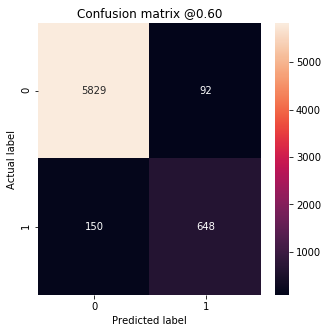

Not Planets Properly Categorized (True Negatives):  5829
Not Planets Categorized as Planets Detected (False Positives):  92
Planets Missed (False Negatives):  150
Planets Properly Categorized (True Positives):  648
Total Planets:  798
Accuracy:  0.9639827355261199


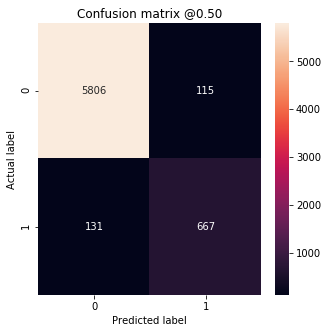

Not Planets Properly Categorized (True Negatives):  5806
Not Planets Categorized as Planets Detected (False Positives):  115
Planets Missed (False Negatives):  131
Planets Properly Categorized (True Positives):  667
Total Planets:  798
Accuracy:  0.9633874088406013


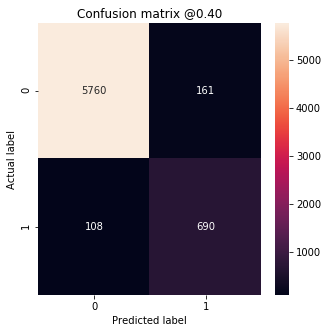

Not Planets Properly Categorized (True Negatives):  5760
Not Planets Categorized as Planets Detected (False Positives):  161
Planets Missed (False Negatives):  108
Planets Properly Categorized (True Positives):  690
Total Planets:  798
Accuracy:  0.9599642803988688


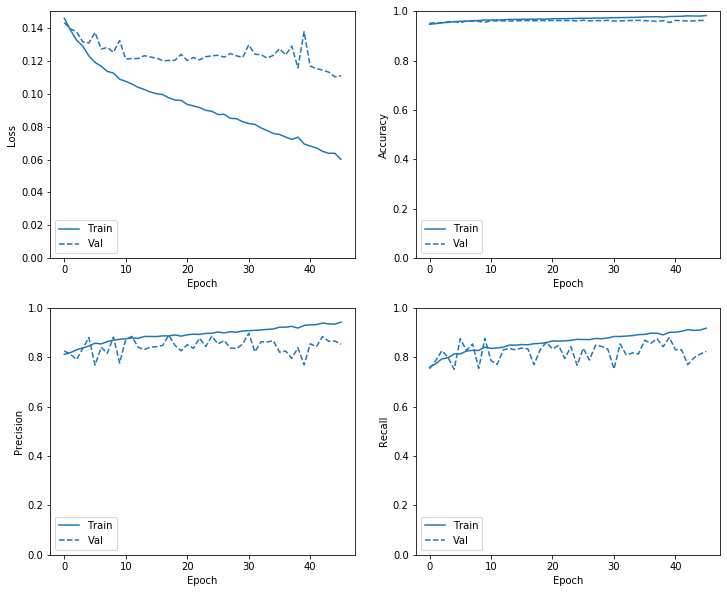

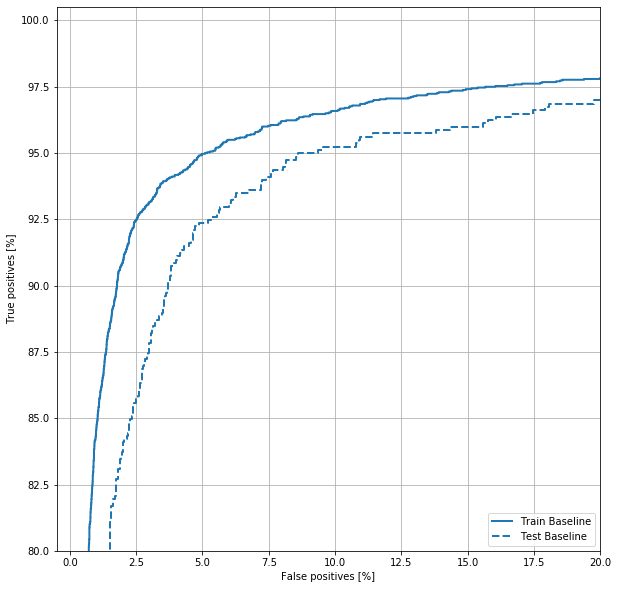

In [57]:
model_results(model)

### LSTM Model

In [115]:
def make_lstm_model():
    
    input_local = tf.keras.layers.Input(shape=[x_local_train.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global_train.shape[1],1])
    
    k_global=tf.keras.layers.LSTM(128)(input_global)
    k_local=tf.keras.layers.LSTM(128)(input_local)
     
    #flatten and concatenate
    #k_global=tf.keras.layers.Flatten()(k_global)
    #k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    #dense layers
    k=tf.keras.layers.Dense(256,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.5)(k)
    k=tf.keras.layers.Dense(256,activation='relu')(k)
    
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    learning_rate=1e-3
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=METRICS)
    return model  

In [116]:
EPOCHS=25
BATCH_SIZE=128

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

model=make_lstm_model()

tf.keras.backend.clear_session()
history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=2)

Epoch 1/25
210/210 - 27s - loss: 0.3239 - tp: 555.0000 - fp: 233.0000 - tn: 29164.0000 - fn: 3642.0000 - accuracy: 0.8847 - precision: 0.7043 - recall: 0.1322 - auc: 0.8325 - val_loss: 0.2591 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5921.0000 - val_fn: 798.0000 - val_accuracy: 0.8812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8609
Epoch 2/25
210/210 - 26s - loss: 0.2684 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23476.0000 - fn: 3399.0000 - accuracy: 0.8735 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8682 - val_loss: 0.2421 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5921.0000 - val_fn: 798.0000 - val_accuracy: 0.8812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8807
Epoch 3/25
210/210 - 27s - loss: 0.2677 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23476.0000 - fn: 3399.0000 - accuracy: 0.8735 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8697 - val_loss: 0.2477 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn

KeyboardInterrupt: 

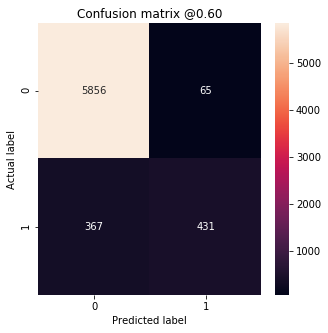

Not Planets Properly Categorized (True Negatives):  5856
Not Planets Categorized as Planets Detected (False Positives):  65
Planets Missed (False Negatives):  367
Planets Properly Categorized (True Positives):  431
Total Planets:  798
Accuracy:  0.9357047179639827


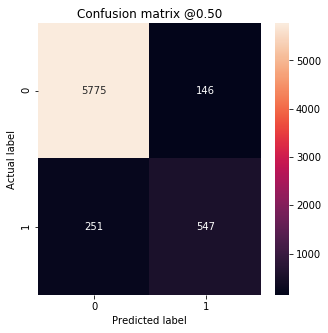

Not Planets Properly Categorized (True Negatives):  5775
Not Planets Categorized as Planets Detected (False Positives):  146
Planets Missed (False Negatives):  251
Planets Properly Categorized (True Positives):  547
Total Planets:  798
Accuracy:  0.9409138264622712


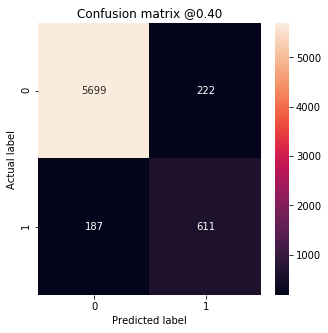

Not Planets Properly Categorized (True Negatives):  5699
Not Planets Categorized as Planets Detected (False Positives):  222
Planets Missed (False Negatives):  187
Planets Properly Categorized (True Positives):  611
Total Planets:  798
Accuracy:  0.9391278464057151


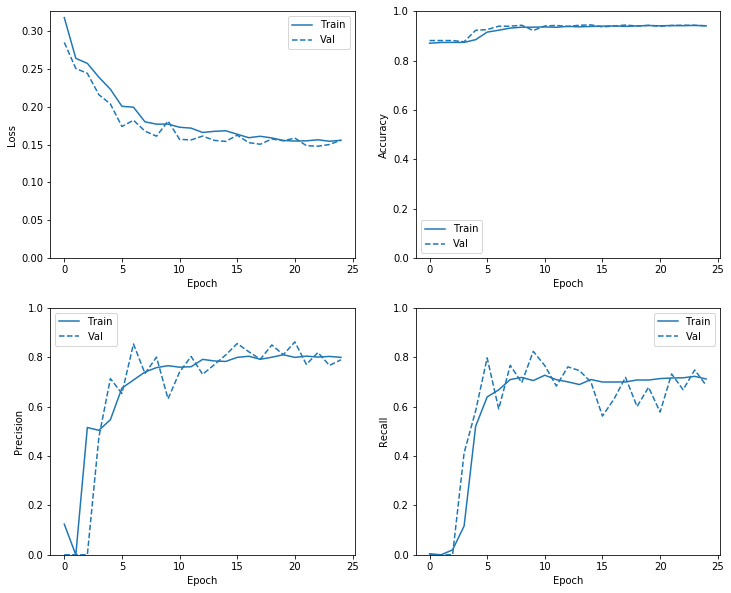

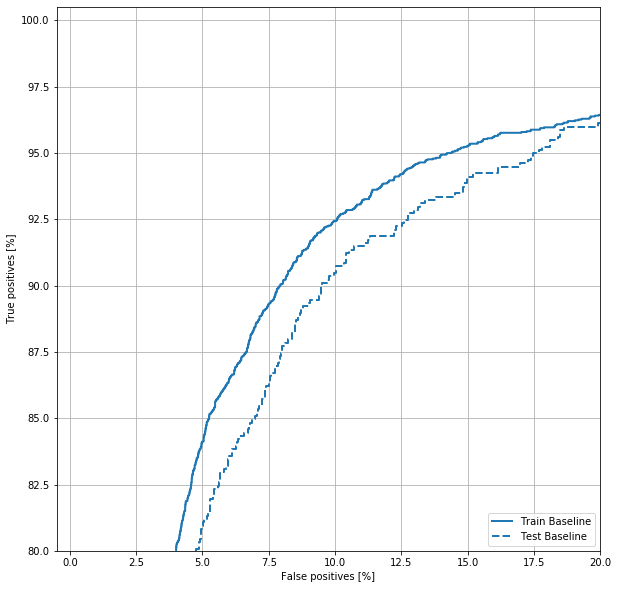

In [71]:
model_results(model)

In [72]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          66560       input_2[0][0]                    
______________________________________________________________________________________________

### CNN_LSTM

In [245]:
def make_cnn_lstm_model():
    
    input_local = tf.keras.layers.Input(shape=[x_local_train.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global_train.shape[1],1])
    
    
    k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Conv1D(filters=32,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)    
    k_global=tf.keras.layers.Conv1D(filters=64,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)    
    
    
    k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    k_local=tf.keras.layers.Conv1D(filters=32,kernel_size=5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    
    
       
    #LSTM
    k_global=tf.keras.layers.LSTM(256)(k_global)
    k_local=tf.keras.layers.LSTM(256)(k_local)
    
    #concatenate
    k =tf.keras.layers.concatenate([k_local, k_global])
    
    
    #dense layers
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.4)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.4)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.4)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    learning_rate=1e-5
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=METRICS)
    return model  

In [ ]:
EPOCHS=200
BATCH_SIZE=96

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=7,
    mode='max',
    restore_best_weights=True)

model=make_cnn_lstm_model()
print(model.summary())

tf.keras.backend.clear_session()
history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 16)     96          input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 999, 16)      0           conv1d[0][0]                     
______________________________________________________________________________________________

Epoch 10/200
280/280 - 13s - loss: 0.2194 - tp: 1329.0000 - fp: 497.0000 - tn: 22979.0000 - fn: 2070.0000 - accuracy: 0.9045 - precision: 0.7278 - recall: 0.3910 - auc: 0.9252 - val_loss: 0.2073 - val_tp: 435.0000 - val_fp: 198.0000 - val_tn: 5723.0000 - val_fn: 363.0000 - val_accuracy: 0.9165 - val_precision: 0.6872 - val_recall: 0.5451 - val_auc: 0.9300
Epoch 11/200
280/280 - 13s - loss: 0.2171 - tp: 1579.0000 - fp: 589.0000 - tn: 22887.0000 - fn: 1820.0000 - accuracy: 0.9104 - precision: 0.7283 - recall: 0.4645 - auc: 0.9268 - val_loss: 0.2044 - val_tp: 444.0000 - val_fp: 187.0000 - val_tn: 5734.0000 - val_fn: 354.0000 - val_accuracy: 0.9195 - val_precision: 0.7036 - val_recall: 0.5564 - val_auc: 0.9316
Epoch 12/200
280/280 - 13s - loss: 0.2149 - tp: 1774.0000 - fp: 716.0000 - tn: 22760.0000 - fn: 1625.0000 - accuracy: 0.9129 - precision: 0.7124 - recall: 0.5219 - auc: 0.9279 - val_loss: 0.2012 - val_tp: 449.0000 - val_fp: 185.0000 - val_tn: 5736.0000 - val_fn: 349.0000 - val_accura

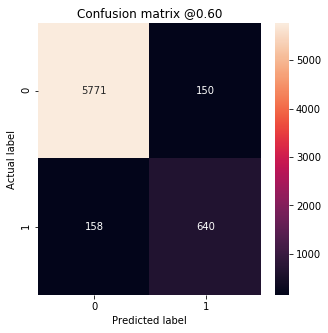

Not Planets Properly Categorized (True Negatives):  5771
Not Planets Categorized as Planets Detected (False Positives):  150
Planets Missed (False Negatives):  158
Planets Properly Categorized (True Positives):  640
Total Planets:  798
Accuracy:  0.9541598452150618


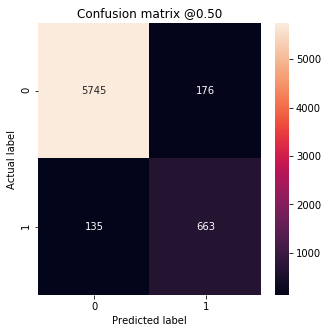

Not Planets Properly Categorized (True Negatives):  5745
Not Planets Categorized as Planets Detected (False Positives):  176
Planets Missed (False Negatives):  135
Planets Properly Categorized (True Positives):  663
Total Planets:  798
Accuracy:  0.9537133502009227


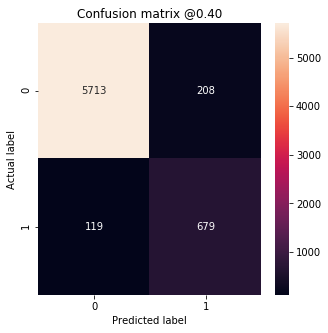

Not Planets Properly Categorized (True Negatives):  5713
Not Planets Categorized as Planets Detected (False Positives):  208
Planets Missed (False Negatives):  119
Planets Properly Categorized (True Positives):  679
Total Planets:  798
Accuracy:  0.951332043458848


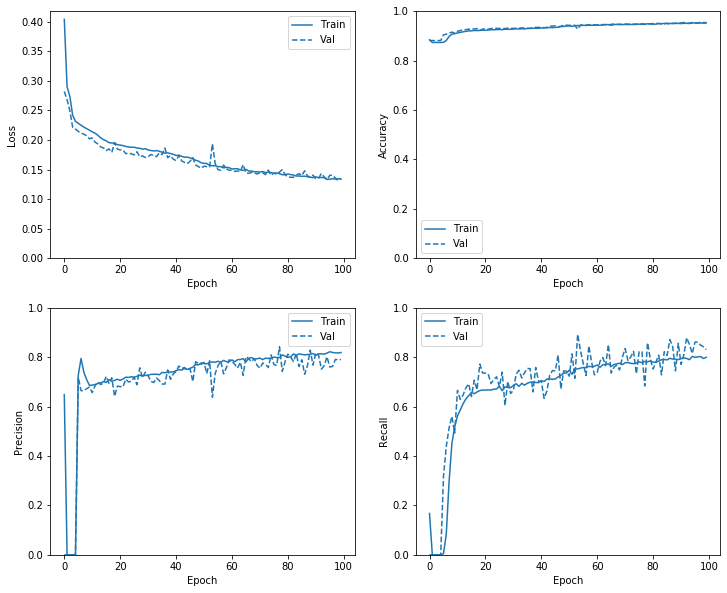

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 16)     96          input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 999, 16)      0           conv1d[0][0]                     
______________________________________________________________________________________________

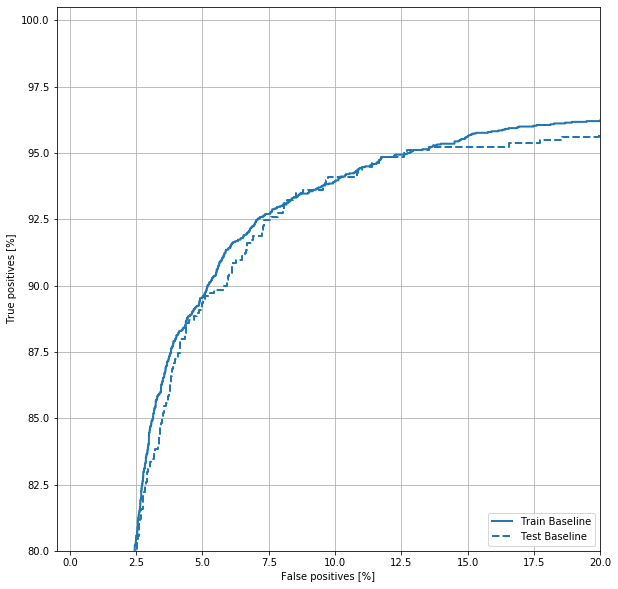

In [247]:
model_results(model)
model.summary()

In [249]:
#save model
model_name='best_cnn_lstm_model'
save_model(model_name)

INFO:tensorflow:Assets written to: models/best_cnn_lstm_model/assets


Predictions shape from w2p model: (33594, 1)
Original Y shape: (33594,)


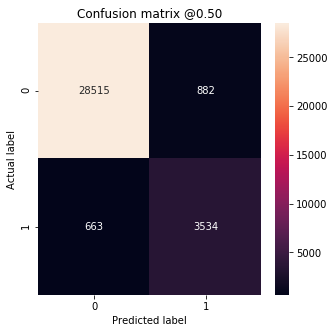

Not Planets Properly Categorized (True Negatives):  28515
Not Planets Categorized as Planets Detected (False Positives):  882
Planets Missed (False Negatives):  663
Planets Properly Categorized (True Positives):  3534
Total Planets:  4197
Accuracy:  0.9540096445793892
processed_final shape: (34032, 88)
w2p_disposition: FALSE POSITIVE    29616
CONFIRMED          4416
Name: w2p_disposition, dtype: int64
koi disposition: FALSE POSITIVE    29835
CONFIRMED          4197
Name: koi_disposition, dtype: int64
koi pdisposition: FALSE POSITIVE    29841
CANDIDATE          4191
Name: koi_pdisposition, dtype: int64
koi pdisposition: FALSE POSITIVE    29841
CANDIDATE          4191
Name: koi_pdisposition, dtype: int64
AV disposition: FALSE POSITIVE    30270
CONFIRMED          3762
Name: av_disposition, dtype: int64
          kepid  tce_plnt_num koi_disposition  w2p_score w2p_disposition  \
0       2304168             2  FALSE POSITIVE    0.00673  FALSE POSITIVE   
1       2304235             1  FALSE 

In [250]:
#create output file
model=load_model('best_cnn_lstm_model')
model_name='w2p_cnn_lstm'
processed_final=create_prediction_output(model,model_name)

In [251]:
#create picture of model
model_picture(model,model_name)

### w2p cnn model

In [237]:
def make_astronet_model():
    
    input_local = tf.keras.layers.Input(shape=[x_local_train.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global_train.shape[1],1])
    
    
    k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_global)
    #k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Conv1D(filters=32,kernel_size=5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(filters=32,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)    
    k_global=tf.keras.layers.Conv1D(filters=64,kernel_size=5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(filters=64,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)    
    #k_global=tf.keras.layers.Conv1D(filters=128,kernel_size=5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(filters=128,kernel_size=5,activation='relu')(k_global)
    #k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)    
    #k_global=tf.keras.layers.Conv1D(filters=256,kernel_size=5,activation='relu')(k_global)
    #k_global=tf.keras.layers.Conv1D(filters=256,kernel_size=5,activation='relu')(k_global)
    #k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)    
    
    
    k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_local)
    #k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    k_local=tf.keras.layers.Conv1D(filters=32,kernel_size=5,activation='relu')(k_local)
    #k_local=tf.keras.layers.Conv1D(filters=32,kernel_size=5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    
    #flatten
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    
    #concatenate
    k =tf.keras.layers.concatenate([k_local, k_global])
    
    
    #dense layers
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.4)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.4)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(0.4)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    #k=tf.keras.layers.Dropout(0.4)(k)
    
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    learning_rate=1e-5
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=METRICS)
    return model  

In [238]:
EPOCHS=100
BATCH_SIZE=64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=7,
    mode='max',
    restore_best_weights=True)

model=make_astronet_model()
print(model.summary())

tf.keras.backend.clear_session()
history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 16)     96          input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 999, 16)      0           conv1d[0][0]                     
______________________________________________________________________________________________

Epoch 10/100
420/420 - 5s - loss: 0.1336 - tp: 2713.0000 - fp: 580.0000 - tn: 22896.0000 - fn: 686.0000 - accuracy: 0.9529 - precision: 0.8239 - recall: 0.7982 - auc: 0.9675 - val_loss: 0.1302 - val_tp: 649.0000 - val_fp: 174.0000 - val_tn: 5747.0000 - val_fn: 149.0000 - val_accuracy: 0.9519 - val_precision: 0.7886 - val_recall: 0.8133 - val_auc: 0.9669
Epoch 11/100
420/420 - 5s - loss: 0.1272 - tp: 2742.0000 - fp: 564.0000 - tn: 22912.0000 - fn: 657.0000 - accuracy: 0.9546 - precision: 0.8294 - recall: 0.8067 - auc: 0.9694 - val_loss: 0.1258 - val_tp: 659.0000 - val_fp: 163.0000 - val_tn: 5758.0000 - val_fn: 139.0000 - val_accuracy: 0.9551 - val_precision: 0.8017 - val_recall: 0.8258 - val_auc: 0.9669
Epoch 12/100
420/420 - 5s - loss: 0.1227 - tp: 2774.0000 - fp: 529.0000 - tn: 22947.0000 - fn: 625.0000 - accuracy: 0.9571 - precision: 0.8398 - recall: 0.8161 - auc: 0.9716 - val_loss: 0.1196 - val_tp: 641.0000 - val_fp: 133.0000 - val_tn: 5788.0000 - val_fn: 157.0000 - val_accuracy: 0.

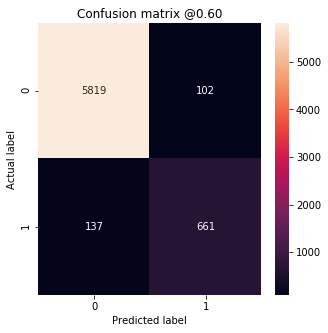

Not Planets Properly Categorized (True Negatives):  5819
Not Planets Categorized as Planets Detected (False Positives):  102
Planets Missed (False Negatives):  137
Planets Properly Categorized (True Positives):  661
Total Planets:  798
Accuracy:  0.964429230540259


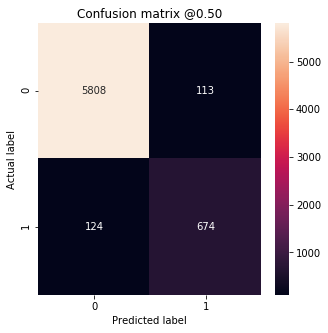

Not Planets Properly Categorized (True Negatives):  5808
Not Planets Categorized as Planets Detected (False Positives):  113
Planets Missed (False Negatives):  124
Planets Properly Categorized (True Positives):  674
Total Planets:  798
Accuracy:  0.9647268938830184


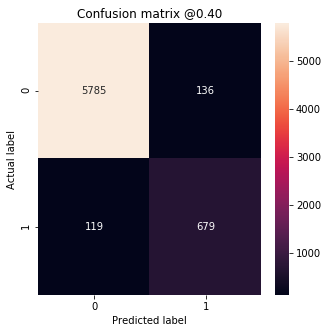

Not Planets Properly Categorized (True Negatives):  5785
Not Planets Categorized as Planets Detected (False Positives):  136
Planets Missed (False Negatives):  119
Planets Properly Categorized (True Positives):  679
Total Planets:  798
Accuracy:  0.9620479237981843


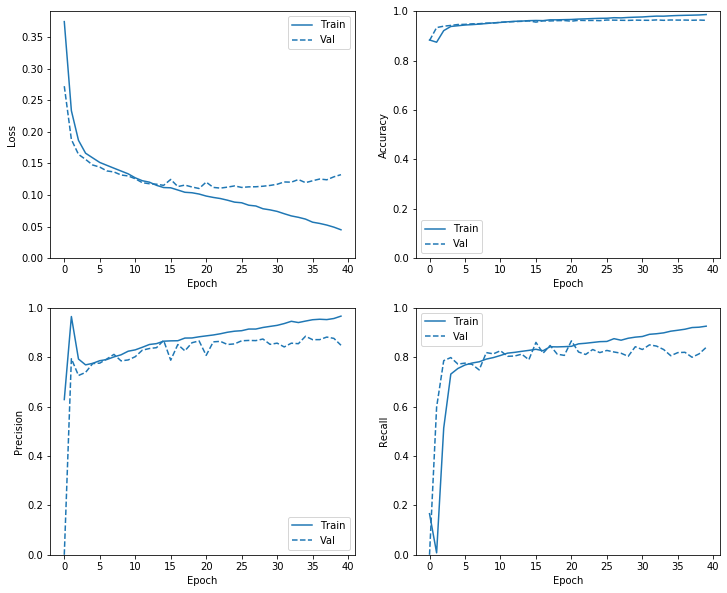

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1997, 16)     96          input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 999, 16)      0           conv1d[0][0]                     
______________________________________________________________________________________________

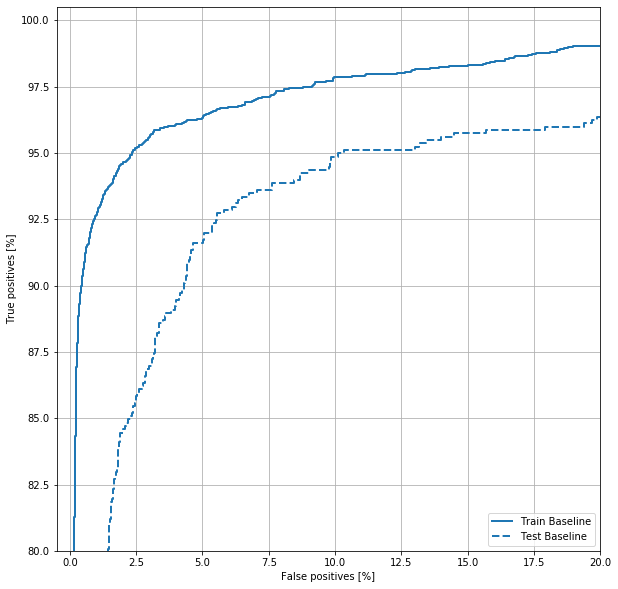

In [240]:
model_results(model)
model.summary()

In [242]:
#save model
model_name='best_cnn_model'
save_model(model_name)

INFO:tensorflow:Assets written to: models/best_cnn_model/assets


In [ ]:
#create output file
model=load_model('best_cnn_model')
model_name='w2p_cnn'
processed_final=create_prediction_output(model,model_name)

In [244]:
#create picture of model
model_picture(model,model_name)

#### Key column descriptions
- koi_disposition:  ground truth
- w2p_score: w2p probability
- w2p_disposition: w2p disposition
- koi_score: robovetter probability
- koi_pdisposition: robovetter disposition (though does not exactly match up with koi_score>0.5- unclear why)
- av_disposition: autovetter disposition (does not exactly match up with av_vf_pc>0- unclear why)
- av_vf_pc: autovetter probability (not posterior)

Links for other column descriptions:

https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html (has AV descriptions)

### Show results of different hyperparameter tuning models

In [ ]:
import json
import hiplot as hip

vis_data = []
rootdir = 'w2p_optimization'
for subdirs, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith("trial.json"):
          with open(subdirs + '/' + file, 'r') as json_file:
            data = json_file.read()
          vis_data.append(json.loads(data))

MAX_TRIALS=100

data = [{'learning_rate': vis_data[idx]['hyperparameters']['values']['learning_rate'],
         'batch_size': vis_data[idx]['hyperparameters']['values']['batch_size'], 
         'number_of_dense_layers':vis_data[idx]['hyperparameters']['values']['number_of_dense_layers'], 
         'further_global_cnn_layers':vis_data[idx]['hyperparameters']['values']['further_global_cnn_layers'], 
         'cnn_global_kernel':vis_data[idx]['hyperparameters']['values']['cnn_global_kernel'],
         'cnn_global_maxpool':vis_data[idx]['hyperparameters']['values']['cnn_global_maxpool'],
         'cnn_global_stride':vis_data[idx]['hyperparameters']['values']['cnn_global_stride'],
         'cnn_global_maxpool':vis_data[idx]['hyperparameters']['values']['cnn_global_maxpool'],
         'first_local_cnn_filters':vis_data[idx]['hyperparameters']['values']['first_local_cnn_filters'],
         'further_local_cnn_filters':vis_data[idx]['hyperparameters']['values']['further_local_cnn_filters'],
         'cnn_local_kernel':vis_data[idx]['hyperparameters']['values']['cnn_local_kernel'],
         'cnn_local_maxpool':vis_data[idx]['hyperparameters']['values']['cnn_local_maxpool'],
         'cnn_local_stride':vis_data[idx]['hyperparameters']['values']['cnn_local_stride'],
         'size_of_dense_layers':vis_data[idx]['hyperparameters']['values']['size_of_dense_layers'],
         'dense_dropout':vis_data[idx]['hyperparameters']['values']['dense_dropout'],
         'first_global_cnn_filters':vis_data[idx]['hyperparameters']['values']['first_global_cnn_filters'],         
         #'units': vis_data[idx]['hyperparameters']['values']['units'], 
         #'dense_activation': vis_data[idx]['hyperparameters']['values']['dense_activation'], 
         #'learning_rate': vis_data[idx]['hyperparameters']['values']['learning_rate'], 
         #'loss': vis_data[idx]['metrics']['metrics']['loss']['observations'][0]['value'],  
         #'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'], 
         #'accuracy': vis_data[idx]['metrics']['metrics']['accuracy']['observations'][0]['value'],
         'val_accuracy': vis_data[idx]['metrics']['metrics']['val_accuracy']['observations'][0]['value'],
         'val_auc': vis_data[idx]['metrics']['metrics']['val_auc']['observations'][0]['value'],
         'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'],
        } 
        for idx in range(MAX_TRIALS)] 
        
hip.Experiment.from_iterable(data).display()

#### Key column descriptions
- koi_disposition:  ground truth
- w2p_score: w2p probability
- w2p_disposition: w2p disposition
- koi_score: robovetter probability
- koi_pdisposition: robovetter disposition (though does not exactly match up with koi_score>0.5- unclear why)
- av_disposition: autovetter disposition (does not exactly match up with av_vf_pc>0- unclear why)
- av_vf_pc: autovetter probability (not posterior)

Links for other column descriptions:

https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html (has AV descriptions)

#### Error Analysis

In [ ]:
val_results=pd.DataFrame({'truth':Y_val, 'prediction':np.squeeze(val_predictions_baseline)})
val_results['truth_delta']=val_results.truth-val_results.prediction
val_results=val_results.sort_values('truth_delta')

val_results['result']='True Positive'
val_results.loc[val_results.truth_delta<0,'result']='True Negative' #then some get replaced by false positive
val_results.loc[val_results.truth_delta<=-0.5,'result']='False Positive'
val_results.loc[val_results.truth_delta>=0.5,'result']='False Negative'

print(val_results.result.value_counts())

cutoff=.05
val_results_mod=val_results[(val_results.truth_delta<-cutoff)|(val_results.truth_delta>cutoff)]
ax = sns.histplot(data=val_results_mod, 
                  x="truth_delta",
                  hue='result').set_title('Distribution of Deltas (excluding vast majority between -.05 and .05)')


val_results_mod=val_results[(val_results.prediction>cutoff)]
ax = sns.histplot(data=val_results_mod, 
                  x="prediction",
                  hue='result',
                  multiple='stack',
                  bins=30).set_title('Distribution of Validation Set Predictions (excluding true negatives <0.05)')

plt.axvline(0.5,0,30)

false_positives=val_results[val_results.truth_delta<=-.5]
print(false_positives.shape)
false_positives

tce_number=835
chart(tce_number,tce_id,val_results,x_global_val,x_local_val)

print(val_results.result[790])

false_negatives=val_results[val_results.truth_delta>=0.5].sort_values('truth_delta',ascending=False)
print (false_negatives.shape)
false_negatives

tce_number=629
chart_curves(9999,0,
             'FALSE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

print(val_results[val_results.result=='True Positive'].sort_values('prediction',ascending=False))
tce_number=118
chart_curves(9999,0,
             'TRUE POSITIVE',
             x_global_val[tce_number],x_local_val[tce_number])

print(val_results[val_results.result=='True Negative'].sort_values('prediction',ascending=True))
tce_number=135
chart_curves(9999,0,
             'TRUE NEGATIVE',
             x_global_val[tce_number],x_local_val[tce_number])

In [ ]:
baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#### CVRandomSearch (but using Keras Hypertune above)

In [ ]:
cnn_global_filters_opts=[[16,32,64,128,256],[16,32],[32,64,128]]
cnn_global_kernel_opts=[5,2,3,7]
cnn_global_maxpool_window_opts=[3,5,7]
cnn_global_maxpool_stride_opts=[1,2,3]
cnn_local_filters_opts=[[16,32],[8,16,32],[8,16,32,64]]
cnn_local_kernel_opts=[5,2,3,7]
cnn_local_maxpool_window_opts=[5,7,9]
cnn_local_maxpool_stride_opts=[1,2,3]
fc_dropout_rate_opts  = [0, 0.2, 0.5]
fc_layers_opts = [[64, 64, 64, 64], [128, 128, 128], [512,512,512,512],[256,256,256]]
l2_penalty_opts = [0.01, 0.1, 0.5]
activation_opts=['relu','prelu']
optimizer_opts=['adam']
epochs_opts=[10,15,20]
batch_size_opts=[64,96,128]


keras_param_options = {
    'cnn_global_filters':cnn_global_filters_opts,
    'cnn_global_kernel':cnn_global_kernel_opts,
    'cnn_global_maxpool_window':cnn_global_maxpool_window_opts,
    'cnn_global_maxpool_stride':cnn_global_maxpool_stride_opts,
    'cnn_local_filters':cnn_local_filters_opts,
    'cnn_local_kernel':cnn_local_kernel_opts,
    'cnn_local_maxpool_window':cnn_local_maxpool_window_opts,
    'cnn_local_maxpool_stride':cnn_local_maxpool_stride_opts,
    'fc_layers': fc_layers_opts,
    'fc_dropout_rate':fc_dropout_rate_opts,
    'l2_penalty': l2_penalty_opts,
    'activation':activation_opts,
    'optimizer':optimizer_opts,
    'epochs':epochs_opts,
    'batch_size':batch_size_opts
}

def make_cnn_model(param)
    model = Sequential()   
    
    
    input_local = tf.keras.layers.Input(shape=[x_local.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global.shape[1],1])
    
    #combi_input = tf.keras.layers.Input((2,)) # (None, 3)
    #input_local = Lambda(lambda x: tf.expand_dims(x[:,0],-1))(combi_input) # (None, 1) 
    #input_global = Lambda(lambda x: tf.expand_dims(x[:,1],-1))(combi_input) # (None, 1)
    
    
    
    #build global branch
    for index, filters in enumerate(cnn_global_filters):       
        if not index:
            k_global=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_global_kernel,
                                            activation=activation)(input_global)
        else:
            k_global=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_global_kernel,
                                            activation=activation)(k_global)
        
        k_global=tf.keras.layers.MaxPooling1D(pool_size=cnn_global_window,
                                              strides=cnn_global_stride,padding='same')(k_global)
    
    #build local branch
    for index, filters in enumerate(cnn_local_filters):       
        if not index:
            k_local=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_local_kernel,
                                            activation=activation)(input_local)
        else:
            k_local=tf.keras.layers.Conv1D(filters=filters,
                                            kernel_size=cnn_local_kernel,
                                            activation=activation)(k_local)
        
        k_local=tf.keras.layers.MaxPooling1D(pool_size=cnn_local_window,
                                              strides=cnn_local_stride,padding='same')(k_local)
    #flatten and concatenate
    k_global=tf.keras.layers.Flatten()(k_global)
    k_local=tf.keras.layers.Flatten()(k_local)
    k = tf.keras.layers.concatenate([k_local, k_global])
    
    #now add dense layers
    for fc_layer in fc_layers:
            k=tf.keras.layers.Dense(fc_layer,activation=activation)(k)
            k=tf.keras.layers.Dropout(fc_dropout_rate)(k)
    
    #output layer        
    output=tf.keras.layers.Dense(1,activation='sigmoid')(k)

    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=optimizer,
                  metrics=METRICS)
    return model

#randomizedsearchcv
#but will not take multiple inputs

model_keras = tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn = make_cnn_model
    )

# specify other extra parameters pass to the .fit
# number of epochs is set to a large number, we'll
# let early stopping terminate the training process
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

callbacks = [early_stop]

keras_fit_params = {   
    'callbacks': callbacks,
    'epochs': 20,
    'batch_size': 96,
    'validation_data': ([x_local_val,x_global_val], Y_val),
    'verbose': 1
}

rs_keras = RandomizedSearchCV( 
    model_keras, 
    param_distributions = keras_param_options,
    fit_params = keras_fit_params,
    scoring = 'neg_log_loss',
    n_iter = 3, 
    cv = 3,
    n_jobs = -1,
    verbose = 1
)


combi_input = np.stack([x_local_train, x_global_train], axis=-1)
#see https://stackoverflow.com/questions/56824968/grid-search-for-keras-with-multiple-inputs/62512554#62512554
rs_keras.fit([x_local_train,x_global_train], Y_train)
rs_keras.fit(combi_input, Y_train)

#rs_keras.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  batch_size=BATCH_SIZE,
#                  epochs=EPOCHS,
#                  callbacks=[early_stopping],
#                  verbose=1)

print('Best score obtained: {0}'.format(rs_keras.best_score_))
print('Parameters:')
for param, value in rs_keras.best_params_.items():
    print('\t{}: {}'.format(param, value))


#### Old model work
- setting initial bias
- train simple model

In [ ]:
#work on setting initial bias
tf.keras.backend.clear_session()
model=make_model()
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))
neg, pos = np.bincount(Y)
total = neg + pos
print(neg,pos,total)
initial_bias=np.log([pos/neg])
print(initial_bias)
model = make_model(output_bias = initial_bias)
model.predict([x_local_train[:10],x_global_train[:10]])
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

initial_weights = os.path.join(MODEL_DIR,'initial_weights')
model.save_weights(initial_weights)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

tf.keras.backend.clear_session()
model=make_model()
model.load_weights(initial_weights)

#history=model.fit([x_local_train,x_global_train],
#                  Y_train,
#                  validation_data=([x_local_val,x_global_val],Y_val),
#                  steps_per_epoch=25,
#                  epochs=EPOCHS*20,
#                  callbacks=[early_stopping],
#                  verbose=1)

EPOCHS=20

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[early_stopping],
                  verbose=1)



#### Class weighting to deal with unbalanced classes

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
#model.load_weights(initial_weights)

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  class_weight=class_weight,
                  callbacks=[early_stopping],
                  verbose=2)

In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Oversampling to deal with unbalanced classes

In [ ]:
#oversampling
bool_train_labels = Y_train != 0
pos_features_local = x_local_train[bool_train_labels]
neg_features_local = x_local_train[~bool_train_labels]
pos_features_global = x_global_train[bool_train_labels]
neg_features_global = x_global_train[~bool_train_labels]

pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features_local))
choices = np.random.choice(ids, len(neg_features_local))

res_pos_features_local = pos_features_local[choices]
res_pos_features_global = pos_features_global[choices]
res_pos_labels = pos_labels[choices]

print(res_pos_features_local.shape,res_pos_features_global.shape)

In [ ]:
res_features_local=np.concatenate([res_pos_features_local,neg_features_local],axis=0)
res_features_global=np.concatenate([res_pos_features_global,neg_features_global],axis=0)
res_labels=np.concatenate([res_pos_labels,neg_labels],axis=0)
order=np.arange(len(res_labels))
np.random.shuffle(order)
res_features_local=res_features_local[order]
res_features_global=res_features_global[order]
res_labels=res_labels[order]
print(res_features_local.shape,res_features_global.shape,res_labels.shape)

In [ ]:
tf.keras.backend.clear_session()
model=make_model()
history = model.fit(
        [res_features_local,res_features_global],
        res_labels,
        validation_data=([x_local_val,x_global_val],Y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=2)


In [ ]:
plot_metrics(history)
plot_cm(Y_val, val_predictions_baseline)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### S3 functions

In [ ]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)